# Neural network for classification of contaminants with MAT

## 1. Formulate/outline the problem: classification

Simple neural network for classification of the contaminants using MAT transcriptomes


In [1]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import wandb
import tensorflow as tf
from tensorflow import keras

# tf.debugging.set_log_device_placement(True)

2023-09-14 15:20:52.999048: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-14 15:20:53.047856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 15:20:53.997368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
file_name = "gene_counts_NN_training.csv"

In [4]:
data = pd.read_csv(file_name)

## 2. Identify inputs and outputs

In [5]:
data["sample"].value_counts()

sample
R848       5
CRX-527    5
CL-307     5
Pam3       5
LPS        5
IMDM       5
PGN        5
Fla-PA     3
LTA        3
Name: count, dtype: int64

## 3. Prepare data

In [6]:
data_features = data.drop(columns=["sample"])
target = data["sample"]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_features, target, test_size=0.2, random_state=0, shuffle=True, stratify=target
)

In [8]:
y_train.value_counts(), y_test.value_counts()

(sample
 Pam3       4
 R848       4
 IMDM       4
 PGN        4
 LPS        4
 CRX-527    4
 CL-307     4
 Fla-PA     2
 LTA        2
 Name: count, dtype: int64,
 sample
 Pam3       1
 R848       1
 Fla-PA     1
 CRX-527    1
 LPS        1
 LTA        1
 IMDM       1
 PGN        1
 CL-307     1
 Name: count, dtype: int64)

In [9]:
def to_normalize_DESeq2_style(data):
    # Ensure all values are non-negative
    data = data.applymap(lambda x: max(x, 0))

    # Take the log
    log_data = np.log1p(data)

    # Calculate the pseudo-reference sample for each gene
    log_data["pseudo_reference"] = log_data.mean(axis=1)

    # Filter out genes with -Inf as their average
    filtered_log_data = log_data[log_data["pseudo_reference"] != float("-inf")]

    # Subtract the gene pseudo-references from log counts
    ratio_data = filtered_log_data.iloc[:, :-1].sub(
        filtered_log_data["pseudo_reference"], axis=0
    )

    # Find the median of the ratios for each sample
    sample_medians = ratio_data.median(axis=0)

    # Convert medians to scaling factors
    scaling_factors = np.exp(sample_medians)

    # Divide the original counts by the scaling factors
    manually_normalized = data.div(scaling_factors)

    return manually_normalized


X_train = to_normalize_DESeq2_style(X_train)

X_test = to_normalize_DESeq2_style(X_test)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
encoded_labels = le.transform(y_train)
le_name_mapping = dict(zip(le.classes_, encoded_labels))

In [ ]:
y_train

In [10]:
le_name_mapping

NameError: name 'le_name_mapping' is not defined

In [12]:
from sklearn.feature_selection import chi2, SelectKBest


fs = SelectKBest(score_func=chi2, k=500)


X_train = fs.fit_transform(X_train, y_train)
X_test = fs.transform(X_test)

In [13]:
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)

In [25]:
target

0        R848
1     CRX-527
2      CL-307
3        Pam3
4        Pam3
5     CRX-527
6      Fla-PA
7         LPS
8      CL-307
9      CL-307
10        PGN
11       R848
12        LPS
13       IMDM
14        LTA
15       R848
16       IMDM
17    CRX-527
18        PGN
19        LTA
20        PGN
21        LPS
22       IMDM
23     CL-307
24       IMDM
25       R848
26        PGN
27    CRX-527
28    CRX-527
29     Fla-PA
30     CL-307
31       Pam3
32        LPS
33        LTA
34       R848
35        PGN
36       Pam3
37     Fla-PA
38       Pam3
39       IMDM
40        LPS
Name: sample, dtype: object

In [31]:
def plot_PCA(data, labels, title):
    hue = []

    for label in labels:
        hue.append(label)

    data = data.transpose()

    pca = PCA(n_components=2)

    pc = pca.fit_transform(data)

    outputDF = pd.DataFrame(pc, columns=["PC0", "PC1"], index=target.index)

    loadings = pd.DataFrame(
        pca.components_.transpose(), columns=["PC0", "PC1"], index=data.index
    )

    a = sns.scatterplot("PC0", "PC1", data=outputDF, hue=hue)

    a.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)
    a.set_title(title)
    print(pca.explained_variance_ratio_)
    return ()

In [32]:
plot_PCA(data, target, "title")

ValueError: could not convert string to float: 'R848'

In [19]:
pca.

array([[-1.11016327e-02, -1.48334804e-02, -2.95182968e-03,
         2.83011131e-02,  3.41926655e-02, -4.64646626e-03,
        -5.60815114e-03,  2.62776864e-02, -1.83079925e-03,
        -1.19932099e-02,  1.27669685e-02,  3.38879571e-03,
        -3.84303135e-03,  2.52419975e-02,  3.37043980e-02,
         3.92594669e-02, -9.09478380e-03, -1.74770745e-03,
        -2.02035651e-02, -2.38395355e-02, -4.90282435e-03,
         3.69392602e-02,  3.60897869e-02,  3.15107016e-02,
         4.13418376e-02,  2.80821755e-03, -1.18863898e-03,
         5.03735613e-02, -2.38419333e-03,  7.54344217e-02,
         2.46364707e-02, -3.52725909e-03, -1.02437778e-03,
        -8.14193775e-03,  1.66942088e-02,  4.36329290e-02,
        -2.04981643e-03,  3.97250457e-02,  6.03075618e-02,
         9.93293262e-04, -4.75417794e-03,  1.99965198e-03,
        -1.25243433e-02,  2.08554587e-02, -3.99798147e-03,
        -4.24984551e-03, -9.66136022e-03, -5.00887988e-03,
         3.45009735e-02, -7.04941095e-04, -5.85664048e-0

In [16]:
X_train_pca[:, 0]

array([-434.07945941, 3943.12781058, -576.61602871, -442.23332665,
       -427.87434968, -443.16768624,  410.36537656, -318.45362335,
       -390.5644237 , -383.16851827, -127.12350728,  545.69748778,
       -461.51533116, -337.4164274 , 1011.32205933, -435.40844417,
       -434.23470015,  227.52149637, -391.99344906,  455.43016521,
       -416.48218838, 1431.90124087,   52.60755159, -322.13352206,
       -431.76951987, -630.04447637,  321.88156634, -436.34695307,
       -379.07009076, -562.93593616,   -4.19968952,  386.9768968 ])

/tmp/ipykernel_2166659/4274156676.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], cmap="Set1")


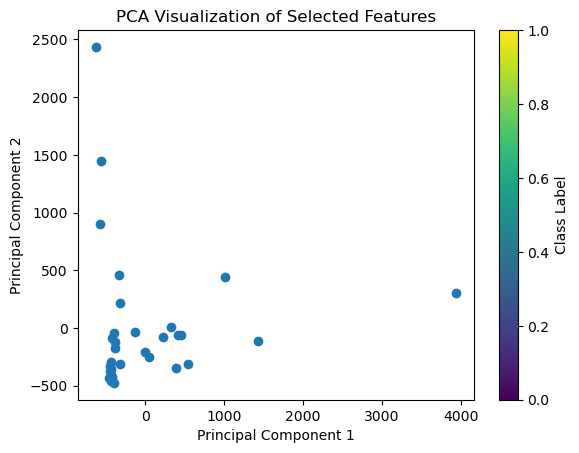

In [17]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], cmap="Set1")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Selected Features")
plt.colorbar(label="Class Label")
plt.show()

In [15]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [17]:
X_train.shape, X_test.shape

((32, 500), (9, 500))

In [18]:
y_train.shape, y_test.shape

((32, 9), (9, 9))

## Train model

In [19]:
keras.backend.clear_session()
keras.utils.set_random_seed(2)

In [20]:
WANDB_NOTEBOOK_NAME = "20230831 Small trained NN.ipynb"

In [27]:
default_config = {
    "l1": 32,
    "l2": 24,
    "batch_size": 8,
    "activation": "relu",
    "weights_limit": 0.001,
    "epochs": 600,
    "learning_rate": 0.0001,
    "loss": "categorical_crossentropy",
    "optimizer": "adam",
    "dropout_rate1": 0.1,
    "dropout_rate2": 0.2,
}

In [1]:
early_stop = keras.callbacks.EarlyStopping(monitor="loss", patience=3)


KeyboardInterrupt



In [28]:
from tensorflow.keras.initializers import HeUniform


def train():
    with tf.device("GPU:0"):
        with wandb.init(project="NN-MATseq", config=default_config) as run:
            batch_size = run.config.batch_size
            activation = run.config.activation
            weights_limit = run.config.weights_limit
            epochs = run.config.epochs
            learning_rate = run.config.learning_rate
            loss = run.config.loss
            l1 = run.config.l1
            l2 = run.config.l2
            dropout_rate1 = run.config.dropout_rate1
            dropout_rate2 = run.config.dropout_rate2

            if run.config.optimizer == "adam":
                optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
            elif run.config.optimizer == "sgd":
                optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
            elif run.config.optimizer == "rmsprop":
                optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

            inputs = keras.Input(shape=X_train.shape[1])
            x = keras.layers.UnitNormalization()(inputs)

            x = keras.layers.Dense(
                l1,
                activation=activation,
                kernel_regularizer=keras.regularizers.L2(weights_limit),
                kernel_initializer=HeUniform(),
            )(x)
            x = keras.layers.Dropout(dropout_rate1)(x)

            x = keras.layers.Dense(
                l2,
                activation=activation,
                kernel_regularizer=keras.regularizers.L2(weights_limit),
                kernel_initializer=HeUniform(),
            )(x)
            x = keras.layers.Dropout(dropout_rate2)(x)

            outputs = keras.layers.Dense(9, activation="softmax")(x)

            model = keras.Model(
                inputs=inputs, outputs=outputs, name="NN_multiclass_classifier_MATseq"
            )

            model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=[
                    "accuracy",
                    keras.metrics.AUC(name="auc"),
                ],
            )

            history = model.fit(
                X_train_scaled,
                y_train,
                validation_data=(X_test_scaled, y_test),
                epochs=epochs,
                batch_size=batch_size,
                verbose=True,
                callbacks=[wandb.keras.WandbCallback()],
            )

            # model.save("MATseq_NN_multiclass_classifier_v0.2.keras", overwrite=False)

In [29]:
model = train()

cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/600
1/4 [======>.......................] - ETA: 3s - loss: 2.3428 - accuracy: 0.0000e+00 - auc: 0.3232

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 2s 352ms/step - loss: 2.3078 - accuracy: 0.0938 - auc: 0.5277 - val_loss: 2.3064 - val_accuracy: 0.1111 - val_auc: 0.5301
Epoch 2/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2632 - accuracy: 0.2500 - auc: 0.6387

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 284ms/step - loss: 2.2966 - accuracy: 0.0625 - auc: 0.5386 - val_loss: 2.3049 - val_accuracy: 0.1111 - val_auc: 0.5293
Epoch 3/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2951 - accuracy: 0.0000e+00 - auc: 0.6074

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 2.2885 - accuracy: 0.1250 - auc: 0.6073 - val_loss: 2.3037 - val_accuracy: 0.1111 - val_auc: 0.5301
Epoch 4/600
1/4 [======>.......................] - ETA: 0s - loss: 2.3192 - accuracy: 0.0000e+00 - auc: 0.4609

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 2.2918 - accuracy: 0.0625 - auc: 0.6014 - val_loss: 2.3022 - val_accuracy: 0.1111 - val_auc: 0.5378
Epoch 5/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2967 - accuracy: 0.0000e+00 - auc: 0.5664

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 2.2846 - accuracy: 0.0625 - auc: 0.6153 - val_loss: 2.3008 - val_accuracy: 0.1111 - val_auc: 0.5502
Epoch 6/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2838 - accuracy: 0.1250 - auc: 0.6240

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 2.2901 - accuracy: 0.1250 - auc: 0.5966 - val_loss: 2.2995 - val_accuracy: 0.1111 - val_auc: 0.5502
Epoch 7/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2873 - accuracy: 0.0000e+00 - auc: 0.6025

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 357ms/step - loss: 2.2869 - accuracy: 0.0312 - auc: 0.6120 - val_loss: 2.2980 - val_accuracy: 0.2222 - val_auc: 0.5502
Epoch 8/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2939 - accuracy: 0.2500 - auc: 0.5693

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 279ms/step - loss: 2.2769 - accuracy: 0.0938 - auc: 0.6585 - val_loss: 2.2966 - val_accuracy: 0.2222 - val_auc: 0.5540
Epoch 9/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2744 - accuracy: 0.2500 - auc: 0.6816

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 2.2732 - accuracy: 0.1250 - auc: 0.6741 - val_loss: 2.2951 - val_accuracy: 0.2222 - val_auc: 0.5579
Epoch 10/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2628 - accuracy: 0.1250 - auc: 0.7539

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 2.2813 - accuracy: 0.0312 - auc: 0.6422 - val_loss: 2.2937 - val_accuracy: 0.2222 - val_auc: 0.5579
Epoch 11/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2321 - accuracy: 0.1250 - auc: 0.8418

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 288ms/step - loss: 2.2650 - accuracy: 0.1562 - auc: 0.7078 - val_loss: 2.2921 - val_accuracy: 0.2222 - val_auc: 0.5579
Epoch 12/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2784 - accuracy: 0.1250 - auc: 0.5820

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 2.2695 - accuracy: 0.1875 - auc: 0.6475 - val_loss: 2.2906 - val_accuracy: 0.2222 - val_auc: 0.5556
Epoch 13/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2600 - accuracy: 0.1250 - auc: 0.7393

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 2.2699 - accuracy: 0.0625 - auc: 0.6735 - val_loss: 2.2893 - val_accuracy: 0.2222 - val_auc: 0.5594
Epoch 14/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2495 - accuracy: 0.2500 - auc: 0.7158

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 282ms/step - loss: 2.2685 - accuracy: 0.1250 - auc: 0.6713 - val_loss: 2.2879 - val_accuracy: 0.2222 - val_auc: 0.5980
Epoch 15/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2643 - accuracy: 0.2500 - auc: 0.7549

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 2.2662 - accuracy: 0.1875 - auc: 0.6757 - val_loss: 2.2866 - val_accuracy: 0.2222 - val_auc: 0.5965
Epoch 16/600
1/4 [======>.......................] - ETA: 0s - loss: 2.3064 - accuracy: 0.0000e+00 - auc: 0.4805

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 359ms/step - loss: 2.2659 - accuracy: 0.0938 - auc: 0.6699 - val_loss: 2.2855 - val_accuracy: 0.2222 - val_auc: 0.5965
Epoch 17/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2789 - accuracy: 0.1250 - auc: 0.6201

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 2.2476 - accuracy: 0.1875 - auc: 0.7076 - val_loss: 2.2842 - val_accuracy: 0.2222 - val_auc: 0.5988
Epoch 18/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2974 - accuracy: 0.0000e+00 - auc: 0.5283

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 2.2537 - accuracy: 0.0938 - auc: 0.7292 - val_loss: 2.2829 - val_accuracy: 0.2222 - val_auc: 0.6103
Epoch 19/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2357 - accuracy: 0.2500 - auc: 0.7832

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 279ms/step - loss: 2.2581 - accuracy: 0.1562 - auc: 0.7216 - val_loss: 2.2819 - val_accuracy: 0.2222 - val_auc: 0.6111
Epoch 20/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2306 - accuracy: 0.1250 - auc: 0.7637

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 2.2425 - accuracy: 0.0938 - auc: 0.7374 - val_loss: 2.2808 - val_accuracy: 0.2222 - val_auc: 0.6173
Epoch 21/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2387 - accuracy: 0.1250 - auc: 0.8301

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 278ms/step - loss: 2.2475 - accuracy: 0.1875 - auc: 0.7476 - val_loss: 2.2797 - val_accuracy: 0.2222 - val_auc: 0.6196
Epoch 22/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2682 - accuracy: 0.1250 - auc: 0.6201

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 283ms/step - loss: 2.2617 - accuracy: 0.0625 - auc: 0.7015 - val_loss: 2.2782 - val_accuracy: 0.2222 - val_auc: 0.6188
Epoch 23/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1928 - accuracy: 0.2500 - auc: 0.8350

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 275ms/step - loss: 2.2387 - accuracy: 0.1250 - auc: 0.7451 - val_loss: 2.2767 - val_accuracy: 0.2222 - val_auc: 0.6196
Epoch 24/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2300 - accuracy: 0.3750 - auc: 0.7324

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 2.2387 - accuracy: 0.2188 - auc: 0.7188 - val_loss: 2.2751 - val_accuracy: 0.2222 - val_auc: 0.6211
Epoch 25/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2192 - accuracy: 0.3750 - auc: 0.7949

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 354ms/step - loss: 2.2243 - accuracy: 0.2812 - auc: 0.7681 - val_loss: 2.2737 - val_accuracy: 0.2222 - val_auc: 0.6327
Epoch 26/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2627 - accuracy: 0.1250 - auc: 0.6533

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 2.2483 - accuracy: 0.0938 - auc: 0.7374 - val_loss: 2.2720 - val_accuracy: 0.2222 - val_auc: 0.6350
Epoch 27/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2129 - accuracy: 0.1250 - auc: 0.7793

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 2.2430 - accuracy: 0.2188 - auc: 0.7411 - val_loss: 2.2701 - val_accuracy: 0.2222 - val_auc: 0.6350
Epoch 28/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2041 - accuracy: 0.5000 - auc: 0.8184

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 2.2198 - accuracy: 0.3750 - auc: 0.7701 - val_loss: 2.2682 - val_accuracy: 0.2222 - val_auc: 0.6705
Epoch 29/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2459 - accuracy: 0.1250 - auc: 0.7070

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 2.2232 - accuracy: 0.3125 - auc: 0.7534 - val_loss: 2.2661 - val_accuracy: 0.2222 - val_auc: 0.6682
Epoch 30/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2196 - accuracy: 0.2500 - auc: 0.8291

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 279ms/step - loss: 2.2235 - accuracy: 0.1875 - auc: 0.7823 - val_loss: 2.2645 - val_accuracy: 0.2222 - val_auc: 0.6690
Epoch 31/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2049 - accuracy: 0.3750 - auc: 0.7988

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 281ms/step - loss: 2.2165 - accuracy: 0.2812 - auc: 0.7672 - val_loss: 2.2630 - val_accuracy: 0.2222 - val_auc: 0.6682
Epoch 32/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1889 - accuracy: 0.2500 - auc: 0.8086

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 2.2067 - accuracy: 0.2500 - auc: 0.7711 - val_loss: 2.2613 - val_accuracy: 0.2222 - val_auc: 0.6667
Epoch 33/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1715 - accuracy: 0.3750 - auc: 0.8027

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 2.2059 - accuracy: 0.2500 - auc: 0.7796 - val_loss: 2.2598 - val_accuracy: 0.2222 - val_auc: 0.6667
Epoch 34/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2345 - accuracy: 0.3750 - auc: 0.7109

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 374ms/step - loss: 2.2058 - accuracy: 0.3750 - auc: 0.7878 - val_loss: 2.2582 - val_accuracy: 0.2222 - val_auc: 0.6644
Epoch 35/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1768 - accuracy: 0.3750 - auc: 0.8584

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 2.1884 - accuracy: 0.3438 - auc: 0.8033 - val_loss: 2.2561 - val_accuracy: 0.2222 - val_auc: 0.6651
Epoch 36/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1629 - accuracy: 0.7500 - auc: 0.8818

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 290ms/step - loss: 2.1889 - accuracy: 0.3750 - auc: 0.8141 - val_loss: 2.2541 - val_accuracy: 0.2222 - val_auc: 0.6597
Epoch 37/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2603 - accuracy: 0.0000e+00 - auc: 0.6650

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 2.2023 - accuracy: 0.2500 - auc: 0.7919 - val_loss: 2.2521 - val_accuracy: 0.2222 - val_auc: 0.6759
Epoch 38/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1983 - accuracy: 0.2500 - auc: 0.8223

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 260ms/step - loss: 2.1860 - accuracy: 0.3438 - auc: 0.7937 - val_loss: 2.2502 - val_accuracy: 0.2222 - val_auc: 0.6644
Epoch 39/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2476 - accuracy: 0.2500 - auc: 0.7383

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 2.1968 - accuracy: 0.3438 - auc: 0.8121 - val_loss: 2.2482 - val_accuracy: 0.3333 - val_auc: 0.6690
Epoch 40/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1985 - accuracy: 0.2500 - auc: 0.7686

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 2.1869 - accuracy: 0.3125 - auc: 0.7794 - val_loss: 2.2465 - val_accuracy: 0.3333 - val_auc: 0.6728
Epoch 41/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1682 - accuracy: 0.5000 - auc: 0.8057

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 2.1692 - accuracy: 0.4062 - auc: 0.8195 - val_loss: 2.2444 - val_accuracy: 0.3333 - val_auc: 0.6782
Epoch 42/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1887 - accuracy: 0.2500 - auc: 0.7998

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 2.1893 - accuracy: 0.1562 - auc: 0.7831 - val_loss: 2.2424 - val_accuracy: 0.3333 - val_auc: 0.6782
Epoch 43/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1970 - accuracy: 0.3750 - auc: 0.7793

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 366ms/step - loss: 2.1700 - accuracy: 0.3750 - auc: 0.8197 - val_loss: 2.2403 - val_accuracy: 0.3333 - val_auc: 0.6829
Epoch 44/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2074 - accuracy: 0.1250 - auc: 0.7520

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 2.1754 - accuracy: 0.3750 - auc: 0.8018 - val_loss: 2.2383 - val_accuracy: 0.3333 - val_auc: 0.6883
Epoch 45/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1592 - accuracy: 0.2500 - auc: 0.7988

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 2.1615 - accuracy: 0.3750 - auc: 0.8270 - val_loss: 2.2364 - val_accuracy: 0.3333 - val_auc: 0.6867
Epoch 46/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1707 - accuracy: 0.2500 - auc: 0.7705

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 285ms/step - loss: 2.1742 - accuracy: 0.3125 - auc: 0.8079 - val_loss: 2.2346 - val_accuracy: 0.3333 - val_auc: 0.6867
Epoch 47/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1172 - accuracy: 0.6250 - auc: 0.8516

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 2.1384 - accuracy: 0.5000 - auc: 0.8412 - val_loss: 2.2328 - val_accuracy: 0.2222 - val_auc: 0.6813
Epoch 48/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1631 - accuracy: 0.2500 - auc: 0.8086

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 253ms/step - loss: 2.1636 - accuracy: 0.3438 - auc: 0.8243 - val_loss: 2.2313 - val_accuracy: 0.2222 - val_auc: 0.6597
Epoch 49/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2230 - accuracy: 0.1250 - auc: 0.7490

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 2.1746 - accuracy: 0.2500 - auc: 0.7875 - val_loss: 2.2295 - val_accuracy: 0.3333 - val_auc: 0.6674
Epoch 50/600
1/4 [======>.......................] - ETA: 0s - loss: 2.2067 - accuracy: 0.3750 - auc: 0.7324

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 258ms/step - loss: 2.1483 - accuracy: 0.3750 - auc: 0.8176 - val_loss: 2.2277 - val_accuracy: 0.3333 - val_auc: 0.6674
Epoch 51/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1376 - accuracy: 0.5000 - auc: 0.8613

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 257ms/step - loss: 2.1554 - accuracy: 0.4062 - auc: 0.8071 - val_loss: 2.2258 - val_accuracy: 0.3333 - val_auc: 0.6651
Epoch 52/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0936 - accuracy: 0.5000 - auc: 0.8760

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 348ms/step - loss: 2.1505 - accuracy: 0.5000 - auc: 0.8210 - val_loss: 2.2238 - val_accuracy: 0.3333 - val_auc: 0.6775
Epoch 53/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1178 - accuracy: 0.3750 - auc: 0.8438

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 2.1276 - accuracy: 0.4062 - auc: 0.8257 - val_loss: 2.2218 - val_accuracy: 0.3333 - val_auc: 0.6790
Epoch 54/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0929 - accuracy: 0.5000 - auc: 0.8438

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 297ms/step - loss: 2.1268 - accuracy: 0.5000 - auc: 0.8304 - val_loss: 2.2199 - val_accuracy: 0.3333 - val_auc: 0.6798
Epoch 55/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1639 - accuracy: 0.3750 - auc: 0.7178

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 2.1479 - accuracy: 0.4688 - auc: 0.7952 - val_loss: 2.2180 - val_accuracy: 0.3333 - val_auc: 0.6998
Epoch 56/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1842 - accuracy: 0.3750 - auc: 0.8115

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 2.1385 - accuracy: 0.4375 - auc: 0.8389 - val_loss: 2.2162 - val_accuracy: 0.3333 - val_auc: 0.7022
Epoch 57/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1097 - accuracy: 0.5000 - auc: 0.8008

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 2.1249 - accuracy: 0.4688 - auc: 0.8224 - val_loss: 2.2143 - val_accuracy: 0.3333 - val_auc: 0.7029
Epoch 58/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0930 - accuracy: 0.3750 - auc: 0.8555

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 297ms/step - loss: 2.1268 - accuracy: 0.4375 - auc: 0.8306 - val_loss: 2.2122 - val_accuracy: 0.3333 - val_auc: 0.7029
Epoch 59/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9877 - accuracy: 0.7500 - auc: 0.9248

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 287ms/step - loss: 2.1054 - accuracy: 0.3750 - auc: 0.8463 - val_loss: 2.2103 - val_accuracy: 0.3333 - val_auc: 0.7083
Epoch 60/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1420 - accuracy: 0.2500 - auc: 0.8662

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 2.1165 - accuracy: 0.3750 - auc: 0.8456 - val_loss: 2.2080 - val_accuracy: 0.3333 - val_auc: 0.7060
Epoch 61/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0799 - accuracy: 0.6250 - auc: 0.8398

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 359ms/step - loss: 2.0965 - accuracy: 0.4375 - auc: 0.8515 - val_loss: 2.2058 - val_accuracy: 0.3333 - val_auc: 0.7052
Epoch 62/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0966 - accuracy: 0.3750 - auc: 0.8828

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 2.1164 - accuracy: 0.4688 - auc: 0.8295 - val_loss: 2.2037 - val_accuracy: 0.3333 - val_auc: 0.7083
Epoch 63/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1642 - accuracy: 0.2500 - auc: 0.8545

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 282ms/step - loss: 2.0790 - accuracy: 0.5625 - auc: 0.8728 - val_loss: 2.2015 - val_accuracy: 0.3333 - val_auc: 0.7068
Epoch 64/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0090 - accuracy: 0.6250 - auc: 0.8994

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 2.1367 - accuracy: 0.3750 - auc: 0.8097 - val_loss: 2.1992 - val_accuracy: 0.3333 - val_auc: 0.7068
Epoch 65/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0438 - accuracy: 0.7500 - auc: 0.8828

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 2.1039 - accuracy: 0.4688 - auc: 0.8473 - val_loss: 2.1969 - val_accuracy: 0.3333 - val_auc: 0.7068
Epoch 66/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0867 - accuracy: 0.2500 - auc: 0.8398

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 255ms/step - loss: 2.0784 - accuracy: 0.4688 - auc: 0.8633 - val_loss: 2.1946 - val_accuracy: 0.3333 - val_auc: 0.7106
Epoch 67/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1181 - accuracy: 0.6250 - auc: 0.8574

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 2.1004 - accuracy: 0.4375 - auc: 0.8430 - val_loss: 2.1921 - val_accuracy: 0.3333 - val_auc: 0.7207
Epoch 68/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1008 - accuracy: 0.5000 - auc: 0.8643

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 2.0788 - accuracy: 0.5312 - auc: 0.8609 - val_loss: 2.1899 - val_accuracy: 0.3333 - val_auc: 0.7346
Epoch 69/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0693 - accuracy: 0.7500 - auc: 0.9219

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 2.0900 - accuracy: 0.4688 - auc: 0.8650 - val_loss: 2.1883 - val_accuracy: 0.3333 - val_auc: 0.7377
Epoch 70/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0101 - accuracy: 0.5000 - auc: 0.8486

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 376ms/step - loss: 2.0673 - accuracy: 0.4375 - auc: 0.8495 - val_loss: 2.1862 - val_accuracy: 0.3333 - val_auc: 0.7369
Epoch 71/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0720 - accuracy: 0.5000 - auc: 0.8428

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 2.0910 - accuracy: 0.4688 - auc: 0.8240 - val_loss: 2.1843 - val_accuracy: 0.3333 - val_auc: 0.7338
Epoch 72/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0949 - accuracy: 0.3750 - auc: 0.8379

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 257ms/step - loss: 2.0817 - accuracy: 0.3750 - auc: 0.8577 - val_loss: 2.1823 - val_accuracy: 0.3333 - val_auc: 0.7338
Epoch 73/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0781 - accuracy: 0.3750 - auc: 0.8428

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 258ms/step - loss: 2.0458 - accuracy: 0.5625 - auc: 0.8680 - val_loss: 2.1804 - val_accuracy: 0.3333 - val_auc: 0.7346
Epoch 74/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0663 - accuracy: 0.3750 - auc: 0.8887

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 2.0327 - accuracy: 0.5312 - auc: 0.8727 - val_loss: 2.1782 - val_accuracy: 0.3333 - val_auc: 0.7184
Epoch 75/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0123 - accuracy: 0.5000 - auc: 0.8887

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 2.0707 - accuracy: 0.4375 - auc: 0.8554 - val_loss: 2.1762 - val_accuracy: 0.3333 - val_auc: 0.7168
Epoch 76/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0024 - accuracy: 0.3750 - auc: 0.8428

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 2.0362 - accuracy: 0.4688 - auc: 0.8376 - val_loss: 2.1740 - val_accuracy: 0.3333 - val_auc: 0.7230
Epoch 77/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0724 - accuracy: 0.6250 - auc: 0.8379

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 2.0262 - accuracy: 0.5625 - auc: 0.8512 - val_loss: 2.1717 - val_accuracy: 0.3333 - val_auc: 0.7238
Epoch 78/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9643 - accuracy: 0.6250 - auc: 0.8584

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 2.0465 - accuracy: 0.4688 - auc: 0.8273 - val_loss: 2.1694 - val_accuracy: 0.3333 - val_auc: 0.7253
Epoch 79/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0846 - accuracy: 0.2500 - auc: 0.8613

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 357ms/step - loss: 2.0293 - accuracy: 0.5000 - auc: 0.8685 - val_loss: 2.1672 - val_accuracy: 0.3333 - val_auc: 0.7215
Epoch 80/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0209 - accuracy: 0.6250 - auc: 0.8633

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 2.0429 - accuracy: 0.5938 - auc: 0.8545 - val_loss: 2.1649 - val_accuracy: 0.3333 - val_auc: 0.7245
Epoch 81/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1420 - accuracy: 0.1250 - auc: 0.7295

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 2.0457 - accuracy: 0.4375 - auc: 0.8461 - val_loss: 2.1625 - val_accuracy: 0.3333 - val_auc: 0.7106
Epoch 82/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0315 - accuracy: 0.3750 - auc: 0.8594

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 291ms/step - loss: 2.0185 - accuracy: 0.4688 - auc: 0.8750 - val_loss: 2.1599 - val_accuracy: 0.3333 - val_auc: 0.7122
Epoch 83/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0563 - accuracy: 0.5000 - auc: 0.8301

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 2.0619 - accuracy: 0.4688 - auc: 0.8354 - val_loss: 2.1577 - val_accuracy: 0.3333 - val_auc: 0.7137
Epoch 84/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9581 - accuracy: 0.6250 - auc: 0.8564

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 2.0122 - accuracy: 0.4688 - auc: 0.8402 - val_loss: 2.1556 - val_accuracy: 0.3333 - val_auc: 0.7160
Epoch 85/600
1/4 [======>.......................] - ETA: 0s - loss: 2.1514 - accuracy: 0.2500 - auc: 0.8115

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 2.0337 - accuracy: 0.4375 - auc: 0.8383 - val_loss: 2.1533 - val_accuracy: 0.3333 - val_auc: 0.7160
Epoch 86/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9924 - accuracy: 0.5000 - auc: 0.8643

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 2.0308 - accuracy: 0.3750 - auc: 0.8493 - val_loss: 2.1512 - val_accuracy: 0.3333 - val_auc: 0.7145
Epoch 87/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9409 - accuracy: 0.7500 - auc: 0.9072

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 1.9967 - accuracy: 0.5938 - auc: 0.8804 - val_loss: 2.1491 - val_accuracy: 0.3333 - val_auc: 0.7238
Epoch 88/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9119 - accuracy: 0.6250 - auc: 0.8867

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 366ms/step - loss: 2.0073 - accuracy: 0.4688 - auc: 0.8715 - val_loss: 2.1469 - val_accuracy: 0.3333 - val_auc: 0.7245
Epoch 89/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9804 - accuracy: 0.5000 - auc: 0.8682

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.9891 - accuracy: 0.4688 - auc: 0.8818 - val_loss: 2.1447 - val_accuracy: 0.3333 - val_auc: 0.7245
Epoch 90/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9447 - accuracy: 0.5000 - auc: 0.9170

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 1.9748 - accuracy: 0.5000 - auc: 0.8745 - val_loss: 2.1422 - val_accuracy: 0.4444 - val_auc: 0.7253
Epoch 91/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0729 - accuracy: 0.5000 - auc: 0.9180

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 1.9643 - accuracy: 0.5312 - auc: 0.8897 - val_loss: 2.1396 - val_accuracy: 0.4444 - val_auc: 0.7292
Epoch 92/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9665 - accuracy: 0.6250 - auc: 0.9150

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 279ms/step - loss: 1.9961 - accuracy: 0.5312 - auc: 0.8838 - val_loss: 2.1369 - val_accuracy: 0.4444 - val_auc: 0.7330
Epoch 93/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9523 - accuracy: 0.6250 - auc: 0.8584

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 279ms/step - loss: 1.9794 - accuracy: 0.5000 - auc: 0.8729 - val_loss: 2.1347 - val_accuracy: 0.4444 - val_auc: 0.7330
Epoch 94/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0411 - accuracy: 0.5000 - auc: 0.8496

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 1.9895 - accuracy: 0.4688 - auc: 0.8508 - val_loss: 2.1325 - val_accuracy: 0.4444 - val_auc: 0.7299
Epoch 95/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9489 - accuracy: 0.7500 - auc: 0.8936

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 257ms/step - loss: 1.9645 - accuracy: 0.5938 - auc: 0.8741 - val_loss: 2.1301 - val_accuracy: 0.4444 - val_auc: 0.7307
Epoch 96/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0466 - accuracy: 0.2500 - auc: 0.7998

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 1.9688 - accuracy: 0.4688 - auc: 0.8656 - val_loss: 2.1277 - val_accuracy: 0.4444 - val_auc: 0.7168
Epoch 97/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9994 - accuracy: 0.5000 - auc: 0.7969

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 349ms/step - loss: 2.0198 - accuracy: 0.4375 - auc: 0.8281 - val_loss: 2.1252 - val_accuracy: 0.4444 - val_auc: 0.7168
Epoch 98/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9384 - accuracy: 0.5000 - auc: 0.8779

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 1.9301 - accuracy: 0.4688 - auc: 0.8943 - val_loss: 2.1227 - val_accuracy: 0.3333 - val_auc: 0.7176
Epoch 99/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7512 - accuracy: 0.6250 - auc: 0.9531

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 290ms/step - loss: 1.9337 - accuracy: 0.5000 - auc: 0.8827 - val_loss: 2.1202 - val_accuracy: 0.3333 - val_auc: 0.7199
Epoch 100/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8819 - accuracy: 0.6250 - auc: 0.9092

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 293ms/step - loss: 1.9495 - accuracy: 0.4375 - auc: 0.8800 - val_loss: 2.1181 - val_accuracy: 0.3333 - val_auc: 0.7253
Epoch 101/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7878 - accuracy: 0.7500 - auc: 0.9395

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 1.9258 - accuracy: 0.5312 - auc: 0.8909 - val_loss: 2.1160 - val_accuracy: 0.3333 - val_auc: 0.7245
Epoch 102/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7428 - accuracy: 0.8750 - auc: 0.9697

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 1.9024 - accuracy: 0.6250 - auc: 0.8854 - val_loss: 2.1134 - val_accuracy: 0.3333 - val_auc: 0.7261
Epoch 103/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0006 - accuracy: 0.3750 - auc: 0.8154

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 283ms/step - loss: 1.9197 - accuracy: 0.5312 - auc: 0.8709 - val_loss: 2.1108 - val_accuracy: 0.3333 - val_auc: 0.7253
Epoch 104/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9165 - accuracy: 0.7500 - auc: 0.8691

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 1.9647 - accuracy: 0.5000 - auc: 0.8623 - val_loss: 2.1083 - val_accuracy: 0.3333 - val_auc: 0.7330
Epoch 105/600
1/4 [======>.......................] - ETA: 0s - loss: 2.0673 - accuracy: 0.1250 - auc: 0.8262

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 281ms/step - loss: 1.9343 - accuracy: 0.3438 - auc: 0.8774 - val_loss: 2.1057 - val_accuracy: 0.3333 - val_auc: 0.7353
Epoch 106/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9914 - accuracy: 0.2500 - auc: 0.8311

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 352ms/step - loss: 1.9473 - accuracy: 0.3438 - auc: 0.8632 - val_loss: 2.1029 - val_accuracy: 0.3333 - val_auc: 0.7361
Epoch 107/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8646 - accuracy: 0.5000 - auc: 0.9014

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 1.9428 - accuracy: 0.4375 - auc: 0.8812 - val_loss: 2.1003 - val_accuracy: 0.3333 - val_auc: 0.7407
Epoch 108/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9851 - accuracy: 0.5000 - auc: 0.9385

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 1.8795 - accuracy: 0.5938 - auc: 0.8903 - val_loss: 2.0978 - val_accuracy: 0.3333 - val_auc: 0.7407
Epoch 109/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8134 - accuracy: 0.7500 - auc: 0.9297

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 261ms/step - loss: 1.8999 - accuracy: 0.5625 - auc: 0.9032 - val_loss: 2.0949 - val_accuracy: 0.3333 - val_auc: 0.7384
Epoch 110/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7985 - accuracy: 0.6250 - auc: 0.9424

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 1.8915 - accuracy: 0.4375 - auc: 0.8860 - val_loss: 2.0922 - val_accuracy: 0.3333 - val_auc: 0.7377
Epoch 111/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9172 - accuracy: 0.3750 - auc: 0.8896

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 1.9009 - accuracy: 0.5000 - auc: 0.8875 - val_loss: 2.0892 - val_accuracy: 0.3333 - val_auc: 0.7377
Epoch 112/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9842 - accuracy: 0.3750 - auc: 0.8545

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 1.9053 - accuracy: 0.5000 - auc: 0.9062 - val_loss: 2.0865 - val_accuracy: 0.3333 - val_auc: 0.7261
Epoch 113/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8714 - accuracy: 0.5000 - auc: 0.8906

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 284ms/step - loss: 1.8947 - accuracy: 0.5312 - auc: 0.8985 - val_loss: 2.0839 - val_accuracy: 0.3333 - val_auc: 0.7261
Epoch 114/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9875 - accuracy: 0.3750 - auc: 0.8008

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.9026 - accuracy: 0.5000 - auc: 0.8870 - val_loss: 2.0810 - val_accuracy: 0.3333 - val_auc: 0.7253
Epoch 115/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8594 - accuracy: 0.1250 - auc: 0.9043

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 385ms/step - loss: 1.9072 - accuracy: 0.3750 - auc: 0.8885 - val_loss: 2.0783 - val_accuracy: 0.3333 - val_auc: 0.7292
Epoch 116/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9168 - accuracy: 0.3750 - auc: 0.8467

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 1.8448 - accuracy: 0.5625 - auc: 0.9143 - val_loss: 2.0757 - val_accuracy: 0.3333 - val_auc: 0.7315
Epoch 117/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9832 - accuracy: 0.3750 - auc: 0.8916

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.9183 - accuracy: 0.4688 - auc: 0.8777 - val_loss: 2.0726 - val_accuracy: 0.3333 - val_auc: 0.7315
Epoch 118/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9221 - accuracy: 0.2500 - auc: 0.8584

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 1.9334 - accuracy: 0.3125 - auc: 0.8698 - val_loss: 2.0694 - val_accuracy: 0.3333 - val_auc: 0.7384
Epoch 119/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8173 - accuracy: 0.5000 - auc: 0.8867

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 1.8498 - accuracy: 0.5625 - auc: 0.8972 - val_loss: 2.0664 - val_accuracy: 0.3333 - val_auc: 0.7415
Epoch 120/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8061 - accuracy: 0.5000 - auc: 0.9268

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 286ms/step - loss: 1.9041 - accuracy: 0.4062 - auc: 0.8859 - val_loss: 2.0634 - val_accuracy: 0.3333 - val_auc: 0.7438
Epoch 121/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7945 - accuracy: 0.7500 - auc: 0.8965

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 1.8602 - accuracy: 0.5000 - auc: 0.8932 - val_loss: 2.0604 - val_accuracy: 0.3333 - val_auc: 0.7423
Epoch 122/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8897 - accuracy: 0.5000 - auc: 0.8965

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 1.8341 - accuracy: 0.5312 - auc: 0.9036 - val_loss: 2.0572 - val_accuracy: 0.3333 - val_auc: 0.7469
Epoch 123/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9738 - accuracy: 0.3750 - auc: 0.8545

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 1.8350 - accuracy: 0.4688 - auc: 0.9089 - val_loss: 2.0541 - val_accuracy: 0.3333 - val_auc: 0.7485
Epoch 124/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7618 - accuracy: 0.7500 - auc: 0.9854

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 359ms/step - loss: 1.8305 - accuracy: 0.5625 - auc: 0.9018 - val_loss: 2.0511 - val_accuracy: 0.3333 - val_auc: 0.7485
Epoch 125/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8130 - accuracy: 0.5000 - auc: 0.9062

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 260ms/step - loss: 1.7998 - accuracy: 0.5312 - auc: 0.9069 - val_loss: 2.0482 - val_accuracy: 0.3333 - val_auc: 0.7485
Epoch 126/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6764 - accuracy: 0.7500 - auc: 0.9492

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 1.7820 - accuracy: 0.5938 - auc: 0.9150 - val_loss: 2.0451 - val_accuracy: 0.3333 - val_auc: 0.7469
Epoch 127/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6697 - accuracy: 0.6250 - auc: 0.9492

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.7979 - accuracy: 0.5000 - auc: 0.9107 - val_loss: 2.0418 - val_accuracy: 0.3333 - val_auc: 0.7431
Epoch 128/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8441 - accuracy: 0.5000 - auc: 0.8770

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.8230 - accuracy: 0.4688 - auc: 0.8892 - val_loss: 2.0385 - val_accuracy: 0.3333 - val_auc: 0.7431
Epoch 129/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7298 - accuracy: 0.5000 - auc: 0.9219

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 1.7968 - accuracy: 0.5000 - auc: 0.9107 - val_loss: 2.0353 - val_accuracy: 0.3333 - val_auc: 0.7438
Epoch 130/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5620 - accuracy: 0.7500 - auc: 0.9463

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 1.7794 - accuracy: 0.5625 - auc: 0.9131 - val_loss: 2.0321 - val_accuracy: 0.3333 - val_auc: 0.7454
Epoch 131/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8035 - accuracy: 0.3750 - auc: 0.9033

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 1.8079 - accuracy: 0.4375 - auc: 0.9146 - val_loss: 2.0289 - val_accuracy: 0.3333 - val_auc: 0.7477
Epoch 132/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7978 - accuracy: 0.3750 - auc: 0.8809

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 1.7673 - accuracy: 0.5625 - auc: 0.9172 - val_loss: 2.0264 - val_accuracy: 0.3333 - val_auc: 0.7554
Epoch 133/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8505 - accuracy: 0.5000 - auc: 0.8857

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 365ms/step - loss: 1.8138 - accuracy: 0.5312 - auc: 0.8971 - val_loss: 2.0236 - val_accuracy: 0.3333 - val_auc: 0.7600
Epoch 134/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8110 - accuracy: 0.6250 - auc: 0.9297

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 275ms/step - loss: 1.8132 - accuracy: 0.5000 - auc: 0.9009 - val_loss: 2.0209 - val_accuracy: 0.3333 - val_auc: 0.7600
Epoch 135/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7019 - accuracy: 0.3750 - auc: 0.9199

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 261ms/step - loss: 1.7840 - accuracy: 0.4688 - auc: 0.9020 - val_loss: 2.0180 - val_accuracy: 0.3333 - val_auc: 0.7639
Epoch 136/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6882 - accuracy: 0.7500 - auc: 0.9639

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 261ms/step - loss: 1.7635 - accuracy: 0.5938 - auc: 0.9331 - val_loss: 2.0150 - val_accuracy: 0.3333 - val_auc: 0.7639
Epoch 137/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7414 - accuracy: 0.5000 - auc: 0.9082

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 1.7910 - accuracy: 0.5312 - auc: 0.9037 - val_loss: 2.0118 - val_accuracy: 0.3333 - val_auc: 0.7623
Epoch 138/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6648 - accuracy: 0.5000 - auc: 0.9189

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 253ms/step - loss: 1.7512 - accuracy: 0.5000 - auc: 0.9118 - val_loss: 2.0087 - val_accuracy: 0.3333 - val_auc: 0.7608
Epoch 139/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8410 - accuracy: 0.6250 - auc: 0.8682

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 1.7730 - accuracy: 0.5625 - auc: 0.9033 - val_loss: 2.0053 - val_accuracy: 0.3333 - val_auc: 0.7616
Epoch 140/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6736 - accuracy: 0.6250 - auc: 0.9395

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 1.7643 - accuracy: 0.5000 - auc: 0.9164 - val_loss: 2.0017 - val_accuracy: 0.3333 - val_auc: 0.7623
Epoch 141/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6793 - accuracy: 0.6250 - auc: 0.9307

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 1.7256 - accuracy: 0.5625 - auc: 0.9129 - val_loss: 1.9981 - val_accuracy: 0.3333 - val_auc: 0.7631
Epoch 142/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5618 - accuracy: 0.6250 - auc: 0.9395

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 361ms/step - loss: 1.7705 - accuracy: 0.5312 - auc: 0.9051 - val_loss: 1.9947 - val_accuracy: 0.3333 - val_auc: 0.7639
Epoch 143/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7117 - accuracy: 0.6250 - auc: 0.8994

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 290ms/step - loss: 1.7434 - accuracy: 0.5625 - auc: 0.9073 - val_loss: 1.9913 - val_accuracy: 0.3333 - val_auc: 0.7670
Epoch 144/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7805 - accuracy: 0.6250 - auc: 0.9053

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 1.7233 - accuracy: 0.5312 - auc: 0.9317 - val_loss: 1.9877 - val_accuracy: 0.3333 - val_auc: 0.7670
Epoch 145/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3874 - accuracy: 0.8750 - auc: 0.9814

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 1.6752 - accuracy: 0.6250 - auc: 0.9327 - val_loss: 1.9841 - val_accuracy: 0.3333 - val_auc: 0.7747
Epoch 146/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8856 - accuracy: 0.5000 - auc: 0.8271

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 305ms/step - loss: 1.7764 - accuracy: 0.5000 - auc: 0.8955 - val_loss: 1.9809 - val_accuracy: 0.3333 - val_auc: 0.7747
Epoch 147/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8615 - accuracy: 0.5000 - auc: 0.9170

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 1.7392 - accuracy: 0.5312 - auc: 0.9145 - val_loss: 1.9774 - val_accuracy: 0.3333 - val_auc: 0.7747
Epoch 148/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8375 - accuracy: 0.3750 - auc: 0.8867

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 1.7356 - accuracy: 0.5938 - auc: 0.9164 - val_loss: 1.9739 - val_accuracy: 0.3333 - val_auc: 0.7755
Epoch 149/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7944 - accuracy: 0.5000 - auc: 0.9521

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 1.7090 - accuracy: 0.5000 - auc: 0.9269 - val_loss: 1.9706 - val_accuracy: 0.3333 - val_auc: 0.7778
Epoch 150/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8168 - accuracy: 0.5000 - auc: 0.8975

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.6746 - accuracy: 0.5938 - auc: 0.9179 - val_loss: 1.9673 - val_accuracy: 0.3333 - val_auc: 0.7770
Epoch 151/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6492 - accuracy: 0.5000 - auc: 0.9316

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 353ms/step - loss: 1.7056 - accuracy: 0.4688 - auc: 0.9299 - val_loss: 1.9637 - val_accuracy: 0.3333 - val_auc: 0.7878
Epoch 152/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7911 - accuracy: 0.6250 - auc: 0.9160

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 1.6775 - accuracy: 0.6875 - auc: 0.9320 - val_loss: 1.9601 - val_accuracy: 0.3333 - val_auc: 0.7878
Epoch 153/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7778 - accuracy: 0.3750 - auc: 0.9219

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 280ms/step - loss: 1.6791 - accuracy: 0.5312 - auc: 0.9257 - val_loss: 1.9567 - val_accuracy: 0.3333 - val_auc: 0.7932
Epoch 154/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7856 - accuracy: 0.7500 - auc: 0.9502

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 280ms/step - loss: 1.6796 - accuracy: 0.6562 - auc: 0.9288 - val_loss: 1.9533 - val_accuracy: 0.3333 - val_auc: 0.7940
Epoch 155/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7103 - accuracy: 0.5000 - auc: 0.9209

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 1.6265 - accuracy: 0.5938 - auc: 0.9512 - val_loss: 1.9496 - val_accuracy: 0.3333 - val_auc: 0.7948
Epoch 156/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5040 - accuracy: 0.7500 - auc: 0.9521

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 1.6244 - accuracy: 0.6250 - auc: 0.9381 - val_loss: 1.9467 - val_accuracy: 0.3333 - val_auc: 0.7924
Epoch 157/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7352 - accuracy: 0.6250 - auc: 0.9287

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 1.6631 - accuracy: 0.5938 - auc: 0.9106 - val_loss: 1.9436 - val_accuracy: 0.3333 - val_auc: 0.7909
Epoch 158/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5745 - accuracy: 0.7500 - auc: 0.9336

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 1.7235 - accuracy: 0.5312 - auc: 0.9085 - val_loss: 1.9405 - val_accuracy: 0.3333 - val_auc: 0.7924
Epoch 159/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6251 - accuracy: 0.5000 - auc: 0.9346

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 286ms/step - loss: 1.6156 - accuracy: 0.5312 - auc: 0.9426 - val_loss: 1.9379 - val_accuracy: 0.3333 - val_auc: 0.7940
Epoch 160/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5106 - accuracy: 0.6250 - auc: 0.9463

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 353ms/step - loss: 1.6279 - accuracy: 0.5625 - auc: 0.9318 - val_loss: 1.9349 - val_accuracy: 0.3333 - val_auc: 0.7932
Epoch 161/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5986 - accuracy: 0.7500 - auc: 0.9697

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.6375 - accuracy: 0.5938 - auc: 0.9326 - val_loss: 1.9318 - val_accuracy: 0.3333 - val_auc: 0.7940
Epoch 162/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6342 - accuracy: 0.6250 - auc: 0.9102

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 1.6697 - accuracy: 0.6562 - auc: 0.9326 - val_loss: 1.9289 - val_accuracy: 0.3333 - val_auc: 0.7894
Epoch 163/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4726 - accuracy: 0.6250 - auc: 0.9736

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 1.6331 - accuracy: 0.5625 - auc: 0.9335 - val_loss: 1.9260 - val_accuracy: 0.3333 - val_auc: 0.7901
Epoch 164/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5247 - accuracy: 0.6250 - auc: 0.9414

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 1.6693 - accuracy: 0.5000 - auc: 0.9087 - val_loss: 1.9232 - val_accuracy: 0.3333 - val_auc: 0.7971
Epoch 165/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4394 - accuracy: 0.6250 - auc: 0.9531

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 278ms/step - loss: 1.6058 - accuracy: 0.5312 - auc: 0.9319 - val_loss: 1.9204 - val_accuracy: 0.3333 - val_auc: 0.8009
Epoch 166/600
1/4 [======>.......................] - ETA: 0s - loss: 1.8880 - accuracy: 0.2500 - auc: 0.8203

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 1.6689 - accuracy: 0.5000 - auc: 0.9193 - val_loss: 1.9175 - val_accuracy: 0.3333 - val_auc: 0.8017
Epoch 167/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5959 - accuracy: 0.6250 - auc: 0.9062

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 1.6544 - accuracy: 0.5625 - auc: 0.9191 - val_loss: 1.9145 - val_accuracy: 0.3333 - val_auc: 0.8032
Epoch 168/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5387 - accuracy: 0.8750 - auc: 0.9658

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 278ms/step - loss: 1.5955 - accuracy: 0.6250 - auc: 0.9336 - val_loss: 1.9116 - val_accuracy: 0.3333 - val_auc: 0.8040
Epoch 169/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6420 - accuracy: 0.8750 - auc: 0.9512

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 358ms/step - loss: 1.6333 - accuracy: 0.6875 - auc: 0.9385 - val_loss: 1.9086 - val_accuracy: 0.3333 - val_auc: 0.8040
Epoch 170/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4164 - accuracy: 0.5000 - auc: 0.9502

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 308ms/step - loss: 1.5287 - accuracy: 0.6562 - auc: 0.9573 - val_loss: 1.9058 - val_accuracy: 0.3333 - val_auc: 0.8086
Epoch 171/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7357 - accuracy: 0.3750 - auc: 0.8594

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 275ms/step - loss: 1.5891 - accuracy: 0.6875 - auc: 0.9356 - val_loss: 1.9030 - val_accuracy: 0.3333 - val_auc: 0.8102
Epoch 172/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5416 - accuracy: 0.6250 - auc: 0.9473

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.5588 - accuracy: 0.5938 - auc: 0.9376 - val_loss: 1.9004 - val_accuracy: 0.3333 - val_auc: 0.8063
Epoch 173/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6900 - accuracy: 0.6250 - auc: 0.9268

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 1.6481 - accuracy: 0.5000 - auc: 0.9243 - val_loss: 1.8974 - val_accuracy: 0.3333 - val_auc: 0.8063
Epoch 174/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5791 - accuracy: 0.7500 - auc: 0.9414

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 1.5991 - accuracy: 0.5312 - auc: 0.9351 - val_loss: 1.8946 - val_accuracy: 0.3333 - val_auc: 0.8040
Epoch 175/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7692 - accuracy: 0.5000 - auc: 0.8984

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 1.4840 - accuracy: 0.7500 - auc: 0.9506 - val_loss: 1.8916 - val_accuracy: 0.3333 - val_auc: 0.8056
Epoch 176/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7512 - accuracy: 0.3750 - auc: 0.8984

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 1.5910 - accuracy: 0.4688 - auc: 0.9274 - val_loss: 1.8884 - val_accuracy: 0.3333 - val_auc: 0.8048
Epoch 177/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5676 - accuracy: 0.6250 - auc: 0.9316

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.5162 - accuracy: 0.6562 - auc: 0.9390 - val_loss: 1.8855 - val_accuracy: 0.3333 - val_auc: 0.8040
Epoch 178/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7273 - accuracy: 0.5000 - auc: 0.9102

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 355ms/step - loss: 1.5984 - accuracy: 0.5938 - auc: 0.9349 - val_loss: 1.8829 - val_accuracy: 0.3333 - val_auc: 0.8056
Epoch 179/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5860 - accuracy: 0.7500 - auc: 0.9482

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 278ms/step - loss: 1.6481 - accuracy: 0.6250 - auc: 0.9006 - val_loss: 1.8802 - val_accuracy: 0.3333 - val_auc: 0.8086
Epoch 180/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5880 - accuracy: 0.6250 - auc: 0.9238

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 1.5510 - accuracy: 0.6562 - auc: 0.9338 - val_loss: 1.8776 - val_accuracy: 0.3333 - val_auc: 0.8125
Epoch 181/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6420 - accuracy: 0.6250 - auc: 0.9502

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 1.5982 - accuracy: 0.6562 - auc: 0.9214 - val_loss: 1.8750 - val_accuracy: 0.3333 - val_auc: 0.8125
Epoch 182/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5933 - accuracy: 0.6250 - auc: 0.9297

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 1.4819 - accuracy: 0.7188 - auc: 0.9503 - val_loss: 1.8724 - val_accuracy: 0.3333 - val_auc: 0.8140
Epoch 183/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6410 - accuracy: 0.6250 - auc: 0.9102

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 261ms/step - loss: 1.5578 - accuracy: 0.6250 - auc: 0.9357 - val_loss: 1.8697 - val_accuracy: 0.3333 - val_auc: 0.8140
Epoch 184/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7483 - accuracy: 0.3750 - auc: 0.9209

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 261ms/step - loss: 1.5347 - accuracy: 0.5312 - auc: 0.9354 - val_loss: 1.8669 - val_accuracy: 0.3333 - val_auc: 0.8148
Epoch 185/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3425 - accuracy: 0.7500 - auc: 0.9541

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 298ms/step - loss: 1.5752 - accuracy: 0.5625 - auc: 0.9302 - val_loss: 1.8641 - val_accuracy: 0.3333 - val_auc: 0.8148
Epoch 186/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2786 - accuracy: 0.7500 - auc: 0.9736

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 1.5013 - accuracy: 0.6562 - auc: 0.9519 - val_loss: 1.8613 - val_accuracy: 0.3333 - val_auc: 0.8156
Epoch 187/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3556 - accuracy: 0.7500 - auc: 0.9619

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 377ms/step - loss: 1.4828 - accuracy: 0.6562 - auc: 0.9490 - val_loss: 1.8583 - val_accuracy: 0.3333 - val_auc: 0.8148
Epoch 188/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5762 - accuracy: 0.5000 - auc: 0.9424

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.5651 - accuracy: 0.6562 - auc: 0.9461 - val_loss: 1.8554 - val_accuracy: 0.3333 - val_auc: 0.8171
Epoch 189/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5108 - accuracy: 0.6250 - auc: 0.9512

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 1.4532 - accuracy: 0.6875 - auc: 0.9637 - val_loss: 1.8527 - val_accuracy: 0.3333 - val_auc: 0.8156
Epoch 190/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5052 - accuracy: 0.7500 - auc: 0.9541

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 292ms/step - loss: 1.4813 - accuracy: 0.7188 - auc: 0.9594 - val_loss: 1.8501 - val_accuracy: 0.3333 - val_auc: 0.8125
Epoch 191/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5677 - accuracy: 0.7500 - auc: 0.9336

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 1.5067 - accuracy: 0.6250 - auc: 0.9369 - val_loss: 1.8477 - val_accuracy: 0.3333 - val_auc: 0.8117
Epoch 192/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5417 - accuracy: 0.5000 - auc: 0.9395

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 1.4786 - accuracy: 0.6562 - auc: 0.9515 - val_loss: 1.8453 - val_accuracy: 0.3333 - val_auc: 0.8110
Epoch 193/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4613 - accuracy: 0.7500 - auc: 0.9355

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 254ms/step - loss: 1.4484 - accuracy: 0.7812 - auc: 0.9579 - val_loss: 1.8429 - val_accuracy: 0.3333 - val_auc: 0.8140
Epoch 194/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2621 - accuracy: 0.7500 - auc: 0.9697

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 292ms/step - loss: 1.4512 - accuracy: 0.6562 - auc: 0.9582 - val_loss: 1.8403 - val_accuracy: 0.3333 - val_auc: 0.8187
Epoch 195/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0832 - accuracy: 1.0000 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.4206 - accuracy: 0.7812 - auc: 0.9579 - val_loss: 1.8376 - val_accuracy: 0.3333 - val_auc: 0.8187
Epoch 196/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7442 - accuracy: 0.6250 - auc: 0.8916

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 366ms/step - loss: 1.5502 - accuracy: 0.6250 - auc: 0.9264 - val_loss: 1.8351 - val_accuracy: 0.3333 - val_auc: 0.8187
Epoch 197/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4469 - accuracy: 0.6250 - auc: 0.9717

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 1.4471 - accuracy: 0.6250 - auc: 0.9552 - val_loss: 1.8329 - val_accuracy: 0.3333 - val_auc: 0.8194
Epoch 198/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5168 - accuracy: 0.5000 - auc: 0.9121

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 1.4061 - accuracy: 0.6562 - auc: 0.9554 - val_loss: 1.8304 - val_accuracy: 0.3333 - val_auc: 0.8194
Epoch 199/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4903 - accuracy: 0.5000 - auc: 0.9287

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 1.3947 - accuracy: 0.6562 - auc: 0.9659 - val_loss: 1.8279 - val_accuracy: 0.3333 - val_auc: 0.8233
Epoch 200/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4553 - accuracy: 0.5000 - auc: 0.9375

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 1.4196 - accuracy: 0.6875 - auc: 0.9442 - val_loss: 1.8252 - val_accuracy: 0.3333 - val_auc: 0.8241
Epoch 201/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1093 - accuracy: 1.0000 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 1.4127 - accuracy: 0.7812 - auc: 0.9523 - val_loss: 1.8224 - val_accuracy: 0.3333 - val_auc: 0.8248
Epoch 202/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1333 - accuracy: 1.0000 - auc: 0.9932

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 279ms/step - loss: 1.3943 - accuracy: 0.7812 - auc: 0.9578 - val_loss: 1.8197 - val_accuracy: 0.3333 - val_auc: 0.8248
Epoch 203/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3806 - accuracy: 0.7500 - auc: 0.9600

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 283ms/step - loss: 1.4190 - accuracy: 0.7188 - auc: 0.9595 - val_loss: 1.8171 - val_accuracy: 0.3333 - val_auc: 0.8248
Epoch 204/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5421 - accuracy: 0.6250 - auc: 0.9590

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 1.4561 - accuracy: 0.6250 - auc: 0.9513 - val_loss: 1.8145 - val_accuracy: 0.3333 - val_auc: 0.8225
Epoch 205/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3376 - accuracy: 0.7500 - auc: 0.9688

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 350ms/step - loss: 1.4482 - accuracy: 0.6562 - auc: 0.9473 - val_loss: 1.8119 - val_accuracy: 0.3333 - val_auc: 0.8233
Epoch 206/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3413 - accuracy: 0.8750 - auc: 0.9619

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 254ms/step - loss: 1.4435 - accuracy: 0.6562 - auc: 0.9435 - val_loss: 1.8094 - val_accuracy: 0.3333 - val_auc: 0.8241
Epoch 207/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4785 - accuracy: 0.5000 - auc: 0.9463

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 1.3675 - accuracy: 0.7188 - auc: 0.9645 - val_loss: 1.8065 - val_accuracy: 0.3333 - val_auc: 0.8241
Epoch 208/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5176 - accuracy: 0.6250 - auc: 0.9189

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 1.3333 - accuracy: 0.7812 - auc: 0.9710 - val_loss: 1.8041 - val_accuracy: 0.3333 - val_auc: 0.8233
Epoch 209/600
1/4 [======>.......................] - ETA: 0s - loss: 1.7350 - accuracy: 0.1250 - auc: 0.9062

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 1.3992 - accuracy: 0.5625 - auc: 0.9460 - val_loss: 1.8017 - val_accuracy: 0.3333 - val_auc: 0.8241
Epoch 210/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3293 - accuracy: 0.7500 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 1.4290 - accuracy: 0.6875 - auc: 0.9581 - val_loss: 1.7990 - val_accuracy: 0.3333 - val_auc: 0.8241
Epoch 211/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3463 - accuracy: 1.0000 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 1.3563 - accuracy: 0.6562 - auc: 0.9579 - val_loss: 1.7963 - val_accuracy: 0.3333 - val_auc: 0.8264
Epoch 212/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3389 - accuracy: 0.5000 - auc: 0.9434

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 1.3429 - accuracy: 0.6250 - auc: 0.9589 - val_loss: 1.7934 - val_accuracy: 0.3333 - val_auc: 0.8287
Epoch 213/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6888 - accuracy: 0.3750 - auc: 0.9141

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 256ms/step - loss: 1.4535 - accuracy: 0.5312 - auc: 0.9367 - val_loss: 1.7903 - val_accuracy: 0.3333 - val_auc: 0.8287
Epoch 214/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1450 - accuracy: 1.0000 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 357ms/step - loss: 1.3446 - accuracy: 0.7188 - auc: 0.9705 - val_loss: 1.7873 - val_accuracy: 0.3333 - val_auc: 0.8295
Epoch 215/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6196 - accuracy: 0.5000 - auc: 0.9326

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 1.3809 - accuracy: 0.7188 - auc: 0.9570 - val_loss: 1.7849 - val_accuracy: 0.3333 - val_auc: 0.8302
Epoch 216/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2457 - accuracy: 0.8750 - auc: 0.9717

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 1.3669 - accuracy: 0.6875 - auc: 0.9624 - val_loss: 1.7825 - val_accuracy: 0.3333 - val_auc: 0.8318
Epoch 217/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3862 - accuracy: 0.6250 - auc: 0.9307

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 275ms/step - loss: 1.4313 - accuracy: 0.7500 - auc: 0.9523 - val_loss: 1.7805 - val_accuracy: 0.3333 - val_auc: 0.8318
Epoch 218/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5641 - accuracy: 0.5000 - auc: 0.9111

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 1.4299 - accuracy: 0.6562 - auc: 0.9448 - val_loss: 1.7781 - val_accuracy: 0.3333 - val_auc: 0.8341
Epoch 219/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5323 - accuracy: 0.6250 - auc: 0.9521

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 1.4165 - accuracy: 0.6250 - auc: 0.9415 - val_loss: 1.7759 - val_accuracy: 0.3333 - val_auc: 0.8341
Epoch 220/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2274 - accuracy: 0.8750 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 1.2798 - accuracy: 0.7812 - auc: 0.9681 - val_loss: 1.7739 - val_accuracy: 0.3333 - val_auc: 0.8349
Epoch 221/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0910 - accuracy: 0.8750 - auc: 0.9785

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 281ms/step - loss: 1.2815 - accuracy: 0.7812 - auc: 0.9719 - val_loss: 1.7718 - val_accuracy: 0.3333 - val_auc: 0.8310
Epoch 222/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3378 - accuracy: 0.6250 - auc: 0.9473

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.3420 - accuracy: 0.8125 - auc: 0.9639 - val_loss: 1.7697 - val_accuracy: 0.3333 - val_auc: 0.8310
Epoch 223/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3685 - accuracy: 0.6250 - auc: 0.9521

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 357ms/step - loss: 1.2917 - accuracy: 0.7188 - auc: 0.9629 - val_loss: 1.7674 - val_accuracy: 0.3333 - val_auc: 0.8326
Epoch 224/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6014 - accuracy: 0.3750 - auc: 0.8848

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 1.3873 - accuracy: 0.6875 - auc: 0.9481 - val_loss: 1.7652 - val_accuracy: 0.3333 - val_auc: 0.8318
Epoch 225/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3076 - accuracy: 0.7500 - auc: 0.9629

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.2884 - accuracy: 0.8125 - auc: 0.9652 - val_loss: 1.7633 - val_accuracy: 0.3333 - val_auc: 0.8310
Epoch 226/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3047 - accuracy: 0.8750 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 1.3634 - accuracy: 0.7812 - auc: 0.9655 - val_loss: 1.7607 - val_accuracy: 0.3333 - val_auc: 0.8326
Epoch 227/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3614 - accuracy: 0.5000 - auc: 0.9287

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 1.3440 - accuracy: 0.6875 - auc: 0.9583 - val_loss: 1.7583 - val_accuracy: 0.3333 - val_auc: 0.8341
Epoch 228/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0986 - accuracy: 1.0000 - auc: 0.9932

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 286ms/step - loss: 1.3683 - accuracy: 0.6562 - auc: 0.9559 - val_loss: 1.7559 - val_accuracy: 0.4444 - val_auc: 0.8341
Epoch 229/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1924 - accuracy: 0.7500 - auc: 0.9746

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 275ms/step - loss: 1.3026 - accuracy: 0.7500 - auc: 0.9732 - val_loss: 1.7535 - val_accuracy: 0.3333 - val_auc: 0.8349
Epoch 230/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4194 - accuracy: 0.5000 - auc: 0.9404

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 260ms/step - loss: 1.3339 - accuracy: 0.6875 - auc: 0.9587 - val_loss: 1.7512 - val_accuracy: 0.3333 - val_auc: 0.8341
Epoch 231/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3187 - accuracy: 0.7500 - auc: 0.9609

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.2779 - accuracy: 0.7812 - auc: 0.9635 - val_loss: 1.7487 - val_accuracy: 0.4444 - val_auc: 0.8349
Epoch 232/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4992 - accuracy: 0.6250 - auc: 0.9443

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 412ms/step - loss: 1.3586 - accuracy: 0.6250 - auc: 0.9492 - val_loss: 1.7458 - val_accuracy: 0.3333 - val_auc: 0.8349
Epoch 233/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0252 - accuracy: 0.8750 - auc: 0.9912

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 281ms/step - loss: 1.2055 - accuracy: 0.8125 - auc: 0.9777 - val_loss: 1.7431 - val_accuracy: 0.4444 - val_auc: 0.8372
Epoch 234/600
1/4 [======>.......................] - ETA: 0s - loss: 1.6396 - accuracy: 0.5000 - auc: 0.9053

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 282ms/step - loss: 1.3208 - accuracy: 0.6875 - auc: 0.9564 - val_loss: 1.7409 - val_accuracy: 0.4444 - val_auc: 0.8380
Epoch 235/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3991 - accuracy: 0.7500 - auc: 0.9648

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 1.3216 - accuracy: 0.7812 - auc: 0.9750 - val_loss: 1.7387 - val_accuracy: 0.4444 - val_auc: 0.8380
Epoch 236/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1250 - accuracy: 0.8750 - auc: 0.9834

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 1.3408 - accuracy: 0.6875 - auc: 0.9561 - val_loss: 1.7366 - val_accuracy: 0.4444 - val_auc: 0.8372
Epoch 237/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5697 - accuracy: 0.5000 - auc: 0.9131

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 1.2547 - accuracy: 0.7812 - auc: 0.9606 - val_loss: 1.7346 - val_accuracy: 0.3333 - val_auc: 0.8380
Epoch 238/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4053 - accuracy: 0.6250 - auc: 0.9307

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 1.2369 - accuracy: 0.7812 - auc: 0.9641 - val_loss: 1.7321 - val_accuracy: 0.3333 - val_auc: 0.8395
Epoch 239/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1287 - accuracy: 0.7500 - auc: 0.9688

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 1.2721 - accuracy: 0.7812 - auc: 0.9689 - val_loss: 1.7295 - val_accuracy: 0.3333 - val_auc: 0.8395
Epoch 240/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5844 - accuracy: 0.5000 - auc: 0.9131

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 1.3562 - accuracy: 0.6875 - auc: 0.9547 - val_loss: 1.7272 - val_accuracy: 0.4444 - val_auc: 0.8395
Epoch 241/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4776 - accuracy: 0.6250 - auc: 0.9346

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 384ms/step - loss: 1.3110 - accuracy: 0.6875 - auc: 0.9615 - val_loss: 1.7251 - val_accuracy: 0.4444 - val_auc: 0.8395
Epoch 242/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5151 - accuracy: 0.3750 - auc: 0.9453

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 1.3125 - accuracy: 0.5625 - auc: 0.9529 - val_loss: 1.7227 - val_accuracy: 0.3333 - val_auc: 0.8380
Epoch 243/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0137 - accuracy: 1.0000 - auc: 0.9951

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 289ms/step - loss: 1.1988 - accuracy: 0.8125 - auc: 0.9730 - val_loss: 1.7206 - val_accuracy: 0.3333 - val_auc: 0.8387
Epoch 244/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2885 - accuracy: 0.5000 - auc: 0.9609

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 1.2140 - accuracy: 0.7188 - auc: 0.9704 - val_loss: 1.7185 - val_accuracy: 0.3333 - val_auc: 0.8410
Epoch 245/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1758 - accuracy: 0.7500 - auc: 0.9766

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 1.2125 - accuracy: 0.7812 - auc: 0.9740 - val_loss: 1.7161 - val_accuracy: 0.3333 - val_auc: 0.8395
Epoch 246/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3695 - accuracy: 0.7500 - auc: 0.9805

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 1.3192 - accuracy: 0.7188 - auc: 0.9614 - val_loss: 1.7134 - val_accuracy: 0.3333 - val_auc: 0.8403
Epoch 247/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0604 - accuracy: 0.8750 - auc: 0.9863

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.1808 - accuracy: 0.7500 - auc: 0.9730 - val_loss: 1.7110 - val_accuracy: 0.3333 - val_auc: 0.8410
Epoch 248/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9719 - accuracy: 0.8750 - auc: 0.9902

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 282ms/step - loss: 1.3494 - accuracy: 0.6562 - auc: 0.9459 - val_loss: 1.7087 - val_accuracy: 0.3333 - val_auc: 0.8410
Epoch 249/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0807 - accuracy: 1.0000 - auc: 0.9883

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 283ms/step - loss: 1.1945 - accuracy: 0.7188 - auc: 0.9706 - val_loss: 1.7065 - val_accuracy: 0.3333 - val_auc: 0.8426
Epoch 250/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9605 - accuracy: 0.8750 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 352ms/step - loss: 1.2876 - accuracy: 0.7188 - auc: 0.9573 - val_loss: 1.7038 - val_accuracy: 0.3333 - val_auc: 0.8449
Epoch 251/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2105 - accuracy: 1.0000 - auc: 0.9873

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 278ms/step - loss: 1.2123 - accuracy: 0.8125 - auc: 0.9788 - val_loss: 1.7014 - val_accuracy: 0.4444 - val_auc: 0.8441
Epoch 252/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1926 - accuracy: 0.8750 - auc: 0.9902

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 1.2512 - accuracy: 0.6875 - auc: 0.9625 - val_loss: 1.6992 - val_accuracy: 0.4444 - val_auc: 0.8441
Epoch 253/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3575 - accuracy: 0.6250 - auc: 0.9521

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 283ms/step - loss: 1.1351 - accuracy: 0.8438 - auc: 0.9825 - val_loss: 1.6973 - val_accuracy: 0.3333 - val_auc: 0.8441
Epoch 254/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1745 - accuracy: 0.7500 - auc: 0.9834

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.2339 - accuracy: 0.7500 - auc: 0.9705 - val_loss: 1.6953 - val_accuracy: 0.4444 - val_auc: 0.8441
Epoch 255/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3542 - accuracy: 0.7500 - auc: 0.9678

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 279ms/step - loss: 1.2457 - accuracy: 0.7812 - auc: 0.9746 - val_loss: 1.6933 - val_accuracy: 0.4444 - val_auc: 0.8465
Epoch 256/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1627 - accuracy: 1.0000 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 1.1083 - accuracy: 0.9062 - auc: 0.9766 - val_loss: 1.6913 - val_accuracy: 0.4444 - val_auc: 0.8465
Epoch 257/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9803 - accuracy: 1.0000 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 1.1796 - accuracy: 0.8750 - auc: 0.9706 - val_loss: 1.6891 - val_accuracy: 0.4444 - val_auc: 0.8472
Epoch 258/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4080 - accuracy: 0.8750 - auc: 0.9424

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 1.2815 - accuracy: 0.8750 - auc: 0.9589 - val_loss: 1.6870 - val_accuracy: 0.4444 - val_auc: 0.8457
Epoch 259/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2417 - accuracy: 0.6250 - auc: 0.9600

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 372ms/step - loss: 1.1720 - accuracy: 0.7188 - auc: 0.9650 - val_loss: 1.6850 - val_accuracy: 0.4444 - val_auc: 0.8472
Epoch 260/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1319 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 1.1752 - accuracy: 0.8438 - auc: 0.9799 - val_loss: 1.6833 - val_accuracy: 0.4444 - val_auc: 0.8465
Epoch 261/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3874 - accuracy: 0.7500 - auc: 0.9453

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 1.2271 - accuracy: 0.8125 - auc: 0.9739 - val_loss: 1.6814 - val_accuracy: 0.4444 - val_auc: 0.8488
Epoch 262/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1435 - accuracy: 0.8750 - auc: 0.9736

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 1.1771 - accuracy: 0.8438 - auc: 0.9747 - val_loss: 1.6796 - val_accuracy: 0.4444 - val_auc: 0.8488
Epoch 263/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0903 - accuracy: 0.8750 - auc: 0.9883

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 1.2284 - accuracy: 0.7500 - auc: 0.9686 - val_loss: 1.6777 - val_accuracy: 0.4444 - val_auc: 0.8488
Epoch 264/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1645 - accuracy: 0.8750 - auc: 0.9854

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 305ms/step - loss: 1.2720 - accuracy: 0.7188 - auc: 0.9659 - val_loss: 1.6756 - val_accuracy: 0.4444 - val_auc: 0.8488
Epoch 265/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2115 - accuracy: 0.7500 - auc: 0.9746

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 1.1430 - accuracy: 0.7812 - auc: 0.9742 - val_loss: 1.6735 - val_accuracy: 0.4444 - val_auc: 0.8457
Epoch 266/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8499 - accuracy: 1.0000 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 279ms/step - loss: 1.0946 - accuracy: 0.8750 - auc: 0.9827 - val_loss: 1.6712 - val_accuracy: 0.4444 - val_auc: 0.8465
Epoch 267/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9383 - accuracy: 0.8750 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 261ms/step - loss: 1.1745 - accuracy: 0.7812 - auc: 0.9742 - val_loss: 1.6692 - val_accuracy: 0.4444 - val_auc: 0.8472
Epoch 268/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1059 - accuracy: 0.7500 - auc: 0.9727

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 360ms/step - loss: 1.1870 - accuracy: 0.7188 - auc: 0.9725 - val_loss: 1.6671 - val_accuracy: 0.4444 - val_auc: 0.8472
Epoch 269/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2811 - accuracy: 0.6250 - auc: 0.9658

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 1.2075 - accuracy: 0.7188 - auc: 0.9711 - val_loss: 1.6653 - val_accuracy: 0.5556 - val_auc: 0.8488
Epoch 270/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0615 - accuracy: 1.0000 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 1.1057 - accuracy: 0.8438 - auc: 0.9832 - val_loss: 1.6632 - val_accuracy: 0.5556 - val_auc: 0.8480
Epoch 271/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3122 - accuracy: 0.7500 - auc: 0.9688

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 279ms/step - loss: 1.0587 - accuracy: 0.8750 - auc: 0.9812 - val_loss: 1.6612 - val_accuracy: 0.5556 - val_auc: 0.8488
Epoch 272/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2808 - accuracy: 0.6250 - auc: 0.9355

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 1.1892 - accuracy: 0.7812 - auc: 0.9620 - val_loss: 1.6592 - val_accuracy: 0.5556 - val_auc: 0.8503
Epoch 273/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1432 - accuracy: 0.6250 - auc: 0.9629

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 283ms/step - loss: 1.0952 - accuracy: 0.8125 - auc: 0.9746 - val_loss: 1.6573 - val_accuracy: 0.5556 - val_auc: 0.8503
Epoch 274/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2277 - accuracy: 0.6250 - auc: 0.9639

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 260ms/step - loss: 1.0388 - accuracy: 0.8750 - auc: 0.9878 - val_loss: 1.6553 - val_accuracy: 0.5556 - val_auc: 0.8503
Epoch 275/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2073 - accuracy: 0.7500 - auc: 0.9727

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 1.1320 - accuracy: 0.8125 - auc: 0.9791 - val_loss: 1.6531 - val_accuracy: 0.5556 - val_auc: 0.8495
Epoch 276/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9623 - accuracy: 1.0000 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 1.1700 - accuracy: 0.7812 - auc: 0.9761 - val_loss: 1.6510 - val_accuracy: 0.5556 - val_auc: 0.8495
Epoch 277/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1066 - accuracy: 0.6250 - auc: 0.9492

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 344ms/step - loss: 1.0937 - accuracy: 0.8438 - auc: 0.9789 - val_loss: 1.6487 - val_accuracy: 0.5556 - val_auc: 0.8511
Epoch 278/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0112 - accuracy: 0.8750 - auc: 0.9873

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 1.1310 - accuracy: 0.7500 - auc: 0.9735 - val_loss: 1.6465 - val_accuracy: 0.5556 - val_auc: 0.8511
Epoch 279/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0856 - accuracy: 1.0000 - auc: 0.9932

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 1.1124 - accuracy: 0.7812 - auc: 0.9810 - val_loss: 1.6443 - val_accuracy: 0.5556 - val_auc: 0.8534
Epoch 280/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1622 - accuracy: 0.8750 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 1.0525 - accuracy: 0.8125 - auc: 0.9838 - val_loss: 1.6421 - val_accuracy: 0.5556 - val_auc: 0.8526
Epoch 281/600
1/4 [======>.......................] - ETA: 0s - loss: 1.4738 - accuracy: 0.7500 - auc: 0.9131

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 1.1462 - accuracy: 0.8438 - auc: 0.9706 - val_loss: 1.6399 - val_accuracy: 0.5556 - val_auc: 0.8534
Epoch 282/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9976 - accuracy: 0.8750 - auc: 0.9902

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 275ms/step - loss: 1.0359 - accuracy: 0.8125 - auc: 0.9805 - val_loss: 1.6378 - val_accuracy: 0.5556 - val_auc: 0.8534
Epoch 283/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1010 - accuracy: 0.7500 - auc: 0.9805

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 257ms/step - loss: 1.0846 - accuracy: 0.8750 - auc: 0.9833 - val_loss: 1.6362 - val_accuracy: 0.5556 - val_auc: 0.8534
Epoch 284/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9650 - accuracy: 1.0000 - auc: 0.9902

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 1.0537 - accuracy: 0.8125 - auc: 0.9728 - val_loss: 1.6348 - val_accuracy: 0.5556 - val_auc: 0.8526
Epoch 285/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7838 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 1.0451 - accuracy: 0.9062 - auc: 0.9843 - val_loss: 1.6330 - val_accuracy: 0.5556 - val_auc: 0.8549
Epoch 286/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7743 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 375ms/step - loss: 1.0142 - accuracy: 0.9062 - auc: 0.9910 - val_loss: 1.6309 - val_accuracy: 0.5556 - val_auc: 0.8542
Epoch 287/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0717 - accuracy: 0.6250 - auc: 0.9639

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 1.1323 - accuracy: 0.8125 - auc: 0.9681 - val_loss: 1.6288 - val_accuracy: 0.5556 - val_auc: 0.8557
Epoch 288/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8717 - accuracy: 1.0000 - auc: 0.9883

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 0.9819 - accuracy: 0.8750 - auc: 0.9820 - val_loss: 1.6265 - val_accuracy: 0.5556 - val_auc: 0.8580
Epoch 289/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0679 - accuracy: 0.8750 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 1.0500 - accuracy: 0.8750 - auc: 0.9883 - val_loss: 1.6246 - val_accuracy: 0.5556 - val_auc: 0.8549
Epoch 290/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9272 - accuracy: 0.7500 - auc: 0.9824

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 1.0334 - accuracy: 0.8750 - auc: 0.9860 - val_loss: 1.6229 - val_accuracy: 0.5556 - val_auc: 0.8549
Epoch 291/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0549 - accuracy: 0.7500 - auc: 0.9785

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 1.1090 - accuracy: 0.7500 - auc: 0.9770 - val_loss: 1.6211 - val_accuracy: 0.6667 - val_auc: 0.8549
Epoch 292/600
1/4 [======>.......................] - ETA: 0s - loss: 1.5165 - accuracy: 0.5000 - auc: 0.8975

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 1.0703 - accuracy: 0.8125 - auc: 0.9753 - val_loss: 1.6191 - val_accuracy: 0.6667 - val_auc: 0.8573
Epoch 293/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0969 - accuracy: 0.7500 - auc: 0.9805

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 1.0677 - accuracy: 0.7812 - auc: 0.9741 - val_loss: 1.6170 - val_accuracy: 0.6667 - val_auc: 0.8573
Epoch 294/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1534 - accuracy: 0.6250 - auc: 0.9746

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 258ms/step - loss: 1.0158 - accuracy: 0.8125 - auc: 0.9841 - val_loss: 1.6150 - val_accuracy: 0.6667 - val_auc: 0.8580
Epoch 295/600
1/4 [======>.......................] - ETA: 0s - loss: 1.3612 - accuracy: 0.6250 - auc: 0.9150

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 364ms/step - loss: 0.9904 - accuracy: 0.8438 - auc: 0.9794 - val_loss: 1.6131 - val_accuracy: 0.6667 - val_auc: 0.8588
Epoch 296/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0229 - accuracy: 0.8750 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 280ms/step - loss: 1.0048 - accuracy: 0.8750 - auc: 0.9902 - val_loss: 1.6115 - val_accuracy: 0.6667 - val_auc: 0.8596
Epoch 297/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0923 - accuracy: 1.0000 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 1.0766 - accuracy: 0.9062 - auc: 0.9837 - val_loss: 1.6099 - val_accuracy: 0.6667 - val_auc: 0.8596
Epoch 298/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0877 - accuracy: 0.7500 - auc: 0.9805

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 1.0179 - accuracy: 0.7812 - auc: 0.9863 - val_loss: 1.6085 - val_accuracy: 0.6667 - val_auc: 0.8596
Epoch 299/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9696 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 0.9939 - accuracy: 0.9062 - auc: 0.9902 - val_loss: 1.6071 - val_accuracy: 0.6667 - val_auc: 0.8611
Epoch 300/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2336 - accuracy: 0.7500 - auc: 0.9609

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 1.0792 - accuracy: 0.8438 - auc: 0.9829 - val_loss: 1.6059 - val_accuracy: 0.6667 - val_auc: 0.8611
Epoch 301/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0121 - accuracy: 0.7500 - auc: 0.9824

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 1.0259 - accuracy: 0.7500 - auc: 0.9777 - val_loss: 1.6039 - val_accuracy: 0.6667 - val_auc: 0.8627
Epoch 302/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0697 - accuracy: 1.0000 - auc: 0.9951

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 1.0429 - accuracy: 0.9062 - auc: 0.9855 - val_loss: 1.6018 - val_accuracy: 0.6667 - val_auc: 0.8634
Epoch 303/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9093 - accuracy: 0.7500 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 280ms/step - loss: 1.0116 - accuracy: 0.8125 - auc: 0.9885 - val_loss: 1.5993 - val_accuracy: 0.6667 - val_auc: 0.8665
Epoch 304/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0743 - accuracy: 0.7500 - auc: 0.9805

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 393ms/step - loss: 1.0767 - accuracy: 0.7188 - auc: 0.9752 - val_loss: 1.5973 - val_accuracy: 0.6667 - val_auc: 0.8665
Epoch 305/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8784 - accuracy: 0.8750 - auc: 0.9863

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.9886 - accuracy: 0.8750 - auc: 0.9880 - val_loss: 1.5953 - val_accuracy: 0.6667 - val_auc: 0.8688
Epoch 306/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2532 - accuracy: 0.7500 - auc: 0.9551

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 1.1518 - accuracy: 0.8125 - auc: 0.9740 - val_loss: 1.5932 - val_accuracy: 0.6667 - val_auc: 0.8688
Epoch 307/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2117 - accuracy: 0.8750 - auc: 0.9609

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 1.0990 - accuracy: 0.7500 - auc: 0.9730 - val_loss: 1.5910 - val_accuracy: 0.6667 - val_auc: 0.8696
Epoch 308/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1304 - accuracy: 0.7500 - auc: 0.9590

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 261ms/step - loss: 0.9270 - accuracy: 0.9062 - auc: 0.9886 - val_loss: 1.5887 - val_accuracy: 0.6667 - val_auc: 0.8696
Epoch 309/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0995 - accuracy: 0.8750 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 280ms/step - loss: 1.0046 - accuracy: 0.8438 - auc: 0.9891 - val_loss: 1.5868 - val_accuracy: 0.6667 - val_auc: 0.8688
Epoch 310/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9557 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 286ms/step - loss: 1.0374 - accuracy: 0.8125 - auc: 0.9827 - val_loss: 1.5854 - val_accuracy: 0.6667 - val_auc: 0.8688
Epoch 311/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1747 - accuracy: 0.8750 - auc: 0.9824

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.9983 - accuracy: 0.8750 - auc: 0.9850 - val_loss: 1.5838 - val_accuracy: 0.6667 - val_auc: 0.8704
Epoch 312/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1459 - accuracy: 0.6250 - auc: 0.9609

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 1.0695 - accuracy: 0.7500 - auc: 0.9730 - val_loss: 1.5821 - val_accuracy: 0.6667 - val_auc: 0.8704
Epoch 313/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8861 - accuracy: 0.8750 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 361ms/step - loss: 1.0370 - accuracy: 0.8750 - auc: 0.9867 - val_loss: 1.5803 - val_accuracy: 0.6667 - val_auc: 0.8696
Epoch 314/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1056 - accuracy: 0.8750 - auc: 0.9863

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 1.0823 - accuracy: 0.8438 - auc: 0.9802 - val_loss: 1.5784 - val_accuracy: 0.6667 - val_auc: 0.8696
Epoch 315/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1533 - accuracy: 0.7500 - auc: 0.9814

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 280ms/step - loss: 0.9850 - accuracy: 0.8750 - auc: 0.9880 - val_loss: 1.5767 - val_accuracy: 0.6667 - val_auc: 0.8665
Epoch 316/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1195 - accuracy: 0.7500 - auc: 0.9678

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 1.0956 - accuracy: 0.8438 - auc: 0.9722 - val_loss: 1.5751 - val_accuracy: 0.6667 - val_auc: 0.8673
Epoch 317/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0591 - accuracy: 0.7500 - auc: 0.9658

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 0.9930 - accuracy: 0.8125 - auc: 0.9844 - val_loss: 1.5733 - val_accuracy: 0.6667 - val_auc: 0.8665
Epoch 318/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8342 - accuracy: 1.0000 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 0.9148 - accuracy: 0.9062 - auc: 0.9915 - val_loss: 1.5713 - val_accuracy: 0.6667 - val_auc: 0.8665
Epoch 319/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1694 - accuracy: 0.8750 - auc: 0.9805

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 1.0455 - accuracy: 0.8438 - auc: 0.9843 - val_loss: 1.5693 - val_accuracy: 0.6667 - val_auc: 0.8673
Epoch 320/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1108 - accuracy: 0.8750 - auc: 0.9824

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 1.0570 - accuracy: 0.7812 - auc: 0.9818 - val_loss: 1.5676 - val_accuracy: 0.6667 - val_auc: 0.8704
Epoch 321/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1379 - accuracy: 0.8750 - auc: 0.9775

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 0.9776 - accuracy: 0.9062 - auc: 0.9843 - val_loss: 1.5664 - val_accuracy: 0.6667 - val_auc: 0.8711
Epoch 322/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2142 - accuracy: 0.7500 - auc: 0.9492

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 354ms/step - loss: 1.0626 - accuracy: 0.8125 - auc: 0.9771 - val_loss: 1.5652 - val_accuracy: 0.6667 - val_auc: 0.8727
Epoch 323/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7986 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 1.0285 - accuracy: 0.8750 - auc: 0.9811 - val_loss: 1.5640 - val_accuracy: 0.6667 - val_auc: 0.8727
Epoch 324/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9238 - accuracy: 1.0000 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 0.9917 - accuracy: 0.8750 - auc: 0.9861 - val_loss: 1.5631 - val_accuracy: 0.6667 - val_auc: 0.8727
Epoch 325/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7962 - accuracy: 0.8750 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 0.9426 - accuracy: 0.7812 - auc: 0.9841 - val_loss: 1.5617 - val_accuracy: 0.6667 - val_auc: 0.8719
Epoch 326/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9259 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 0.9341 - accuracy: 0.8750 - auc: 0.9919 - val_loss: 1.5603 - val_accuracy: 0.6667 - val_auc: 0.8727
Epoch 327/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0773 - accuracy: 1.0000 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 282ms/step - loss: 0.9804 - accuracy: 0.8438 - auc: 0.9884 - val_loss: 1.5589 - val_accuracy: 0.6667 - val_auc: 0.8727
Epoch 328/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0761 - accuracy: 0.8750 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 0.9339 - accuracy: 0.9062 - auc: 0.9887 - val_loss: 1.5573 - val_accuracy: 0.6667 - val_auc: 0.8742
Epoch 329/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0466 - accuracy: 0.7500 - auc: 0.9863

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 1.0149 - accuracy: 0.8125 - auc: 0.9822 - val_loss: 1.5553 - val_accuracy: 0.6667 - val_auc: 0.8750
Epoch 330/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8275 - accuracy: 1.0000 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 0.8936 - accuracy: 0.9375 - auc: 0.9911 - val_loss: 1.5537 - val_accuracy: 0.6667 - val_auc: 0.8750
Epoch 331/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0052 - accuracy: 0.8750 - auc: 0.9795

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 362ms/step - loss: 0.9283 - accuracy: 0.8750 - auc: 0.9860 - val_loss: 1.5520 - val_accuracy: 0.6667 - val_auc: 0.8750
Epoch 332/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8785 - accuracy: 1.0000 - auc: 0.9912

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 0.9838 - accuracy: 0.9062 - auc: 0.9830 - val_loss: 1.5501 - val_accuracy: 0.6667 - val_auc: 0.8758
Epoch 333/600
1/4 [======>.......................] - ETA: 0s - loss: 1.2318 - accuracy: 0.3750 - auc: 0.9424

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 261ms/step - loss: 1.0252 - accuracy: 0.6250 - auc: 0.9731 - val_loss: 1.5483 - val_accuracy: 0.6667 - val_auc: 0.8758
Epoch 334/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1452 - accuracy: 0.6250 - auc: 0.9756

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 256ms/step - loss: 0.8367 - accuracy: 0.8438 - auc: 0.9941 - val_loss: 1.5464 - val_accuracy: 0.6667 - val_auc: 0.8758
Epoch 335/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7621 - accuracy: 1.0000 - auc: 0.9990

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 0.9519 - accuracy: 0.9062 - auc: 0.9879 - val_loss: 1.5446 - val_accuracy: 0.6667 - val_auc: 0.8765
Epoch 336/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0709 - accuracy: 0.8750 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 0.9430 - accuracy: 0.8125 - auc: 0.9873 - val_loss: 1.5426 - val_accuracy: 0.6667 - val_auc: 0.8758
Epoch 337/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6512 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 261ms/step - loss: 0.9565 - accuracy: 0.7812 - auc: 0.9868 - val_loss: 1.5413 - val_accuracy: 0.6667 - val_auc: 0.8758
Epoch 338/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7917 - accuracy: 0.8750 - auc: 0.9902

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 0.8268 - accuracy: 0.9062 - auc: 0.9943 - val_loss: 1.5396 - val_accuracy: 0.6667 - val_auc: 0.8765
Epoch 339/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8396 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 0.8760 - accuracy: 0.9375 - auc: 0.9933 - val_loss: 1.5379 - val_accuracy: 0.6667 - val_auc: 0.8765
Epoch 340/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1286 - accuracy: 0.8750 - auc: 0.9717

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 373ms/step - loss: 1.1051 - accuracy: 0.7812 - auc: 0.9714 - val_loss: 1.5360 - val_accuracy: 0.6667 - val_auc: 0.8765
Epoch 341/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0569 - accuracy: 0.8750 - auc: 0.9893

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 0.9616 - accuracy: 0.9375 - auc: 0.9905 - val_loss: 1.5342 - val_accuracy: 0.6667 - val_auc: 0.8773
Epoch 342/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9987 - accuracy: 0.8750 - auc: 0.9883

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 287ms/step - loss: 0.9639 - accuracy: 0.7812 - auc: 0.9843 - val_loss: 1.5325 - val_accuracy: 0.6667 - val_auc: 0.8781
Epoch 343/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8805 - accuracy: 0.8750 - auc: 0.9902

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.8511 - accuracy: 0.8125 - auc: 0.9877 - val_loss: 1.5305 - val_accuracy: 0.6667 - val_auc: 0.8789
Epoch 344/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9452 - accuracy: 1.0000 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 279ms/step - loss: 0.8761 - accuracy: 0.9688 - auc: 0.9942 - val_loss: 1.5289 - val_accuracy: 0.6667 - val_auc: 0.8796
Epoch 345/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8523 - accuracy: 0.8750 - auc: 0.9863

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 0.8865 - accuracy: 0.8750 - auc: 0.9898 - val_loss: 1.5273 - val_accuracy: 0.6667 - val_auc: 0.8773
Epoch 346/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8374 - accuracy: 0.8750 - auc: 0.9912

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 258ms/step - loss: 0.9433 - accuracy: 0.8125 - auc: 0.9855 - val_loss: 1.5260 - val_accuracy: 0.6667 - val_auc: 0.8789
Epoch 347/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7873 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 0.8083 - accuracy: 0.8750 - auc: 0.9933 - val_loss: 1.5249 - val_accuracy: 0.6667 - val_auc: 0.8789
Epoch 348/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0011 - accuracy: 0.7500 - auc: 0.9766

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 0.8964 - accuracy: 0.8750 - auc: 0.9905 - val_loss: 1.5235 - val_accuracy: 0.6667 - val_auc: 0.8781
Epoch 349/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0532 - accuracy: 0.6250 - auc: 0.9697

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 374ms/step - loss: 0.8497 - accuracy: 0.8125 - auc: 0.9883 - val_loss: 1.5220 - val_accuracy: 0.6667 - val_auc: 0.8781
Epoch 350/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8469 - accuracy: 0.8750 - auc: 0.9814

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 280ms/step - loss: 0.8298 - accuracy: 0.8750 - auc: 0.9896 - val_loss: 1.5205 - val_accuracy: 0.6667 - val_auc: 0.8796
Epoch 351/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6705 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 0.8411 - accuracy: 0.8750 - auc: 0.9923 - val_loss: 1.5194 - val_accuracy: 0.6667 - val_auc: 0.8796
Epoch 352/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0307 - accuracy: 0.7500 - auc: 0.9814

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 0.9065 - accuracy: 0.7500 - auc: 0.9850 - val_loss: 1.5177 - val_accuracy: 0.6667 - val_auc: 0.8789
Epoch 353/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7866 - accuracy: 0.8750 - auc: 0.9932

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 289ms/step - loss: 0.9177 - accuracy: 0.9062 - auc: 0.9918 - val_loss: 1.5158 - val_accuracy: 0.6667 - val_auc: 0.8781
Epoch 354/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1243 - accuracy: 0.7500 - auc: 0.9746

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 286ms/step - loss: 0.9664 - accuracy: 0.8125 - auc: 0.9865 - val_loss: 1.5141 - val_accuracy: 0.6667 - val_auc: 0.8789
Epoch 355/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9433 - accuracy: 0.8750 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 282ms/step - loss: 0.8051 - accuracy: 0.9062 - auc: 0.9893 - val_loss: 1.5131 - val_accuracy: 0.6667 - val_auc: 0.8796
Epoch 356/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8327 - accuracy: 0.7500 - auc: 0.9805

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 0.9184 - accuracy: 0.9062 - auc: 0.9866 - val_loss: 1.5121 - val_accuracy: 0.6667 - val_auc: 0.8796
Epoch 357/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8504 - accuracy: 0.8750 - auc: 0.9883

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 0.8272 - accuracy: 0.9062 - auc: 0.9911 - val_loss: 1.5106 - val_accuracy: 0.6667 - val_auc: 0.8796
Epoch 358/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8802 - accuracy: 0.7500 - auc: 0.9766

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 355ms/step - loss: 0.9193 - accuracy: 0.8438 - auc: 0.9836 - val_loss: 1.5091 - val_accuracy: 0.6667 - val_auc: 0.8804
Epoch 359/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9004 - accuracy: 0.8750 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 0.8867 - accuracy: 0.8438 - auc: 0.9869 - val_loss: 1.5074 - val_accuracy: 0.6667 - val_auc: 0.8804
Epoch 360/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7143 - accuracy: 1.0000 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 292ms/step - loss: 0.8798 - accuracy: 0.8438 - auc: 0.9875 - val_loss: 1.5058 - val_accuracy: 0.6667 - val_auc: 0.8804
Epoch 361/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0345 - accuracy: 0.8750 - auc: 0.9736

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 0.9067 - accuracy: 0.8750 - auc: 0.9838 - val_loss: 1.5038 - val_accuracy: 0.6667 - val_auc: 0.8804
Epoch 362/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6013 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 0.8035 - accuracy: 0.8125 - auc: 0.9906 - val_loss: 1.5022 - val_accuracy: 0.6667 - val_auc: 0.8804
Epoch 363/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0862 - accuracy: 0.6250 - auc: 0.9707

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 0.7964 - accuracy: 0.8750 - auc: 0.9946 - val_loss: 1.5008 - val_accuracy: 0.6667 - val_auc: 0.8812
Epoch 364/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9610 - accuracy: 0.8750 - auc: 0.9805

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 278ms/step - loss: 0.8991 - accuracy: 0.9062 - auc: 0.9870 - val_loss: 1.4996 - val_accuracy: 0.6667 - val_auc: 0.8812
Epoch 365/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6266 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 261ms/step - loss: 0.8264 - accuracy: 0.9062 - auc: 0.9923 - val_loss: 1.4985 - val_accuracy: 0.6667 - val_auc: 0.8812
Epoch 366/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9215 - accuracy: 0.8750 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 281ms/step - loss: 0.9234 - accuracy: 0.9062 - auc: 0.9888 - val_loss: 1.4973 - val_accuracy: 0.6667 - val_auc: 0.8812
Epoch 367/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7416 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 360ms/step - loss: 0.8548 - accuracy: 0.9062 - auc: 0.9908 - val_loss: 1.4959 - val_accuracy: 0.6667 - val_auc: 0.8819
Epoch 368/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0689 - accuracy: 0.7500 - auc: 0.9688

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 0.9018 - accuracy: 0.9062 - auc: 0.9896 - val_loss: 1.4942 - val_accuracy: 0.6667 - val_auc: 0.8819
Epoch 369/600
1/4 [======>.......................] - ETA: 0s - loss: 1.1553 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 0.8398 - accuracy: 0.8750 - auc: 0.9955 - val_loss: 1.4929 - val_accuracy: 0.6667 - val_auc: 0.8819
Epoch 370/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8041 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 0.8493 - accuracy: 0.9062 - auc: 0.9942 - val_loss: 1.4919 - val_accuracy: 0.6667 - val_auc: 0.8827
Epoch 371/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7805 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 0.8816 - accuracy: 0.8438 - auc: 0.9895 - val_loss: 1.4909 - val_accuracy: 0.6667 - val_auc: 0.8835
Epoch 372/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6677 - accuracy: 0.8750 - auc: 0.9951

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 308ms/step - loss: 0.7747 - accuracy: 0.8750 - auc: 0.9928 - val_loss: 1.4898 - val_accuracy: 0.6667 - val_auc: 0.8835
Epoch 373/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6100 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 291ms/step - loss: 0.7071 - accuracy: 0.9062 - auc: 0.9965 - val_loss: 1.4886 - val_accuracy: 0.6667 - val_auc: 0.8835
Epoch 374/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6823 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 0.7515 - accuracy: 0.8750 - auc: 0.9945 - val_loss: 1.4874 - val_accuracy: 0.6667 - val_auc: 0.8843
Epoch 375/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6610 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 0.7517 - accuracy: 0.9062 - auc: 0.9946 - val_loss: 1.4861 - val_accuracy: 0.6667 - val_auc: 0.8835
Epoch 376/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6143 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 381ms/step - loss: 0.8388 - accuracy: 0.8125 - auc: 0.9905 - val_loss: 1.4847 - val_accuracy: 0.6667 - val_auc: 0.8835
Epoch 377/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8781 - accuracy: 0.7500 - auc: 0.9893

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 0.8611 - accuracy: 0.8438 - auc: 0.9908 - val_loss: 1.4834 - val_accuracy: 0.6667 - val_auc: 0.8843
Epoch 378/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6318 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 0.8021 - accuracy: 0.9062 - auc: 0.9933 - val_loss: 1.4823 - val_accuracy: 0.6667 - val_auc: 0.8843
Epoch 379/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7895 - accuracy: 0.8750 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 0.7962 - accuracy: 0.8750 - auc: 0.9919 - val_loss: 1.4809 - val_accuracy: 0.6667 - val_auc: 0.8843
Epoch 380/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8689 - accuracy: 0.8750 - auc: 0.9824

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 0.8216 - accuracy: 0.8750 - auc: 0.9915 - val_loss: 1.4797 - val_accuracy: 0.6667 - val_auc: 0.8843
Epoch 381/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7710 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 0.8407 - accuracy: 0.8750 - auc: 0.9916 - val_loss: 1.4781 - val_accuracy: 0.6667 - val_auc: 0.8850
Epoch 382/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8487 - accuracy: 0.7500 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 0.7992 - accuracy: 0.8438 - auc: 0.9946 - val_loss: 1.4763 - val_accuracy: 0.6667 - val_auc: 0.8850
Epoch 383/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0056 - accuracy: 0.5000 - auc: 0.9600

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 295ms/step - loss: 0.9058 - accuracy: 0.7188 - auc: 0.9827 - val_loss: 1.4749 - val_accuracy: 0.6667 - val_auc: 0.8850
Epoch 384/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8467 - accuracy: 0.8750 - auc: 0.9893

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 287ms/step - loss: 0.8617 - accuracy: 0.8438 - auc: 0.9896 - val_loss: 1.4733 - val_accuracy: 0.6667 - val_auc: 0.8850
Epoch 385/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6943 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 351ms/step - loss: 0.8374 - accuracy: 0.8125 - auc: 0.9887 - val_loss: 1.4721 - val_accuracy: 0.6667 - val_auc: 0.8858
Epoch 386/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8737 - accuracy: 0.8750 - auc: 0.9883

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 0.7418 - accuracy: 0.9062 - auc: 0.9927 - val_loss: 1.4708 - val_accuracy: 0.6667 - val_auc: 0.8858
Epoch 387/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7853 - accuracy: 0.8750 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 0.7837 - accuracy: 0.8750 - auc: 0.9957 - val_loss: 1.4694 - val_accuracy: 0.6667 - val_auc: 0.8866
Epoch 388/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5866 - accuracy: 1.0000 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 0.7726 - accuracy: 0.8750 - auc: 0.9929 - val_loss: 1.4682 - val_accuracy: 0.6667 - val_auc: 0.8866
Epoch 389/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9273 - accuracy: 0.7500 - auc: 0.9785

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 0.7738 - accuracy: 0.9062 - auc: 0.9915 - val_loss: 1.4672 - val_accuracy: 0.6667 - val_auc: 0.8873
Epoch 390/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7444 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 0.8595 - accuracy: 0.9062 - auc: 0.9887 - val_loss: 1.4665 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 391/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9135 - accuracy: 0.8750 - auc: 0.9824

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.8774 - accuracy: 0.8750 - auc: 0.9900 - val_loss: 1.4654 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 392/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7139 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 0.7592 - accuracy: 0.9375 - auc: 0.9969 - val_loss: 1.4643 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 393/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7374 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 0.8167 - accuracy: 0.9062 - auc: 0.9937 - val_loss: 1.4632 - val_accuracy: 0.6667 - val_auc: 0.8835
Epoch 394/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5404 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 377ms/step - loss: 0.7247 - accuracy: 0.9375 - auc: 0.9956 - val_loss: 1.4623 - val_accuracy: 0.6667 - val_auc: 0.8835
Epoch 395/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9128 - accuracy: 0.7500 - auc: 0.9863

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 0.8443 - accuracy: 0.8750 - auc: 0.9908 - val_loss: 1.4614 - val_accuracy: 0.6667 - val_auc: 0.8843
Epoch 396/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8203 - accuracy: 1.0000 - auc: 0.9971

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 0.8025 - accuracy: 0.9688 - auc: 0.9933 - val_loss: 1.4600 - val_accuracy: 0.6667 - val_auc: 0.8843
Epoch 397/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6038 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 300ms/step - loss: 0.7896 - accuracy: 0.8750 - auc: 0.9913 - val_loss: 1.4587 - val_accuracy: 0.6667 - val_auc: 0.8850
Epoch 398/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7432 - accuracy: 0.8750 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 0.7640 - accuracy: 0.8438 - auc: 0.9922 - val_loss: 1.4576 - val_accuracy: 0.6667 - val_auc: 0.8843
Epoch 399/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9818 - accuracy: 0.7500 - auc: 0.9766

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 280ms/step - loss: 0.7231 - accuracy: 0.8750 - auc: 0.9944 - val_loss: 1.4565 - val_accuracy: 0.6667 - val_auc: 0.8843
Epoch 400/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8622 - accuracy: 0.8750 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 0.9156 - accuracy: 0.8438 - auc: 0.9883 - val_loss: 1.4555 - val_accuracy: 0.6667 - val_auc: 0.8850
Epoch 401/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8113 - accuracy: 1.0000 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 258ms/step - loss: 0.7758 - accuracy: 0.8750 - auc: 0.9929 - val_loss: 1.4542 - val_accuracy: 0.6667 - val_auc: 0.8858
Epoch 402/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8399 - accuracy: 1.0000 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.7580 - accuracy: 0.9062 - auc: 0.9955 - val_loss: 1.4526 - val_accuracy: 0.6667 - val_auc: 0.8858
Epoch 403/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8776 - accuracy: 0.8750 - auc: 0.9883

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 366ms/step - loss: 0.8388 - accuracy: 0.9062 - auc: 0.9910 - val_loss: 1.4515 - val_accuracy: 0.6667 - val_auc: 0.8858
Epoch 404/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6814 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 283ms/step - loss: 0.6971 - accuracy: 0.9062 - auc: 0.9963 - val_loss: 1.4506 - val_accuracy: 0.6667 - val_auc: 0.8858
Epoch 405/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7477 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 0.7668 - accuracy: 0.9375 - auc: 0.9944 - val_loss: 1.4498 - val_accuracy: 0.6667 - val_auc: 0.8858
Epoch 406/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8384 - accuracy: 0.6250 - auc: 0.9766

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 0.7773 - accuracy: 0.8750 - auc: 0.9915 - val_loss: 1.4487 - val_accuracy: 0.6667 - val_auc: 0.8858
Epoch 407/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8632 - accuracy: 0.8750 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 0.8162 - accuracy: 0.8750 - auc: 0.9938 - val_loss: 1.4480 - val_accuracy: 0.6667 - val_auc: 0.8866
Epoch 408/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7157 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 282ms/step - loss: 0.6907 - accuracy: 0.9688 - auc: 0.9967 - val_loss: 1.4469 - val_accuracy: 0.6667 - val_auc: 0.8866
Epoch 409/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8899 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.7532 - accuracy: 0.9062 - auc: 0.9946 - val_loss: 1.4462 - val_accuracy: 0.6667 - val_auc: 0.8866
Epoch 410/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9447 - accuracy: 0.8750 - auc: 0.9932

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 0.7355 - accuracy: 0.9375 - auc: 0.9953 - val_loss: 1.4456 - val_accuracy: 0.6667 - val_auc: 0.8866
Epoch 411/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5437 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 0.6811 - accuracy: 0.9688 - auc: 0.9980 - val_loss: 1.4447 - val_accuracy: 0.6667 - val_auc: 0.8866
Epoch 412/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9673 - accuracy: 0.8750 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 349ms/step - loss: 0.7783 - accuracy: 0.9062 - auc: 0.9944 - val_loss: 1.4437 - val_accuracy: 0.6667 - val_auc: 0.8873
Epoch 413/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9199 - accuracy: 0.8750 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 0.7844 - accuracy: 0.9062 - auc: 0.9949 - val_loss: 1.4429 - val_accuracy: 0.6667 - val_auc: 0.8873
Epoch 414/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4638 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 0.6796 - accuracy: 0.9688 - auc: 0.9965 - val_loss: 1.4421 - val_accuracy: 0.6667 - val_auc: 0.8873
Epoch 415/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6846 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 0.8134 - accuracy: 0.9062 - auc: 0.9917 - val_loss: 1.4413 - val_accuracy: 0.6667 - val_auc: 0.8866
Epoch 416/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8539 - accuracy: 0.7500 - auc: 0.9746

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 0.7600 - accuracy: 0.8750 - auc: 0.9928 - val_loss: 1.4406 - val_accuracy: 0.6667 - val_auc: 0.8873
Epoch 417/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8581 - accuracy: 0.8750 - auc: 0.9854

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 254ms/step - loss: 0.8357 - accuracy: 0.9062 - auc: 0.9871 - val_loss: 1.4396 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 418/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9551 - accuracy: 0.7500 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 364ms/step - loss: 0.7815 - accuracy: 0.8750 - auc: 0.9915 - val_loss: 1.4386 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 419/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9259 - accuracy: 0.7500 - auc: 0.9824

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 285ms/step - loss: 0.8661 - accuracy: 0.8125 - auc: 0.9833 - val_loss: 1.4381 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 420/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8649 - accuracy: 1.0000 - auc: 0.9883

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.8958 - accuracy: 0.8125 - auc: 0.9825 - val_loss: 1.4370 - val_accuracy: 0.6667 - val_auc: 0.8873
Epoch 421/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7972 - accuracy: 1.0000 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 424ms/step - loss: 0.7816 - accuracy: 0.9688 - auc: 0.9949 - val_loss: 1.4358 - val_accuracy: 0.6667 - val_auc: 0.8873
Epoch 422/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5524 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 0.7078 - accuracy: 1.0000 - auc: 0.9980 - val_loss: 1.4347 - val_accuracy: 0.6667 - val_auc: 0.8889
Epoch 423/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5511 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 260ms/step - loss: 0.6952 - accuracy: 0.9688 - auc: 0.9951 - val_loss: 1.4340 - val_accuracy: 0.6667 - val_auc: 0.8889
Epoch 424/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4571 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 0.6992 - accuracy: 0.9375 - auc: 0.9975 - val_loss: 1.4334 - val_accuracy: 0.6667 - val_auc: 0.8850
Epoch 425/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8873 - accuracy: 0.8750 - auc: 0.9863

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 282ms/step - loss: 0.8411 - accuracy: 0.7812 - auc: 0.9860 - val_loss: 1.4321 - val_accuracy: 0.6667 - val_auc: 0.8850
Epoch 426/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6293 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 0.7420 - accuracy: 0.9062 - auc: 0.9963 - val_loss: 1.4306 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 427/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6590 - accuracy: 0.8750 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 0.6808 - accuracy: 0.9375 - auc: 0.9967 - val_loss: 1.4291 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 428/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6483 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 278ms/step - loss: 0.7530 - accuracy: 0.9062 - auc: 0.9974 - val_loss: 1.4276 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 429/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5299 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 288ms/step - loss: 0.7622 - accuracy: 0.9688 - auc: 0.9922 - val_loss: 1.4259 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 430/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6339 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 361ms/step - loss: 0.7248 - accuracy: 0.8750 - auc: 0.9948 - val_loss: 1.4247 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 431/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7450 - accuracy: 0.8750 - auc: 0.9902

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 0.7484 - accuracy: 0.8750 - auc: 0.9908 - val_loss: 1.4231 - val_accuracy: 0.6667 - val_auc: 0.8889
Epoch 432/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6314 - accuracy: 0.8750 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 0.6044 - accuracy: 0.9688 - auc: 0.9985 - val_loss: 1.4218 - val_accuracy: 0.6667 - val_auc: 0.8889
Epoch 433/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5573 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 0.6368 - accuracy: 0.9375 - auc: 0.9984 - val_loss: 1.4207 - val_accuracy: 0.6667 - val_auc: 0.8889
Epoch 434/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6743 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 0.7394 - accuracy: 0.8438 - auc: 0.9932 - val_loss: 1.4192 - val_accuracy: 0.6667 - val_auc: 0.8889
Epoch 435/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7260 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 0.6707 - accuracy: 0.9062 - auc: 0.9972 - val_loss: 1.4183 - val_accuracy: 0.6667 - val_auc: 0.8889
Epoch 436/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5585 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 258ms/step - loss: 0.7012 - accuracy: 0.9375 - auc: 0.9966 - val_loss: 1.4177 - val_accuracy: 0.6667 - val_auc: 0.8889
Epoch 437/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6614 - accuracy: 0.8750 - auc: 0.9873

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 0.6635 - accuracy: 0.9688 - auc: 0.9955 - val_loss: 1.4171 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 438/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7558 - accuracy: 0.8750 - auc: 0.9902

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 0.7152 - accuracy: 0.9375 - auc: 0.9948 - val_loss: 1.4166 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 439/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6276 - accuracy: 0.8750 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 353ms/step - loss: 0.6672 - accuracy: 0.9375 - auc: 0.9966 - val_loss: 1.4159 - val_accuracy: 0.6667 - val_auc: 0.8889
Epoch 440/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9452 - accuracy: 0.7500 - auc: 0.9785

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 0.7438 - accuracy: 0.9062 - auc: 0.9943 - val_loss: 1.4153 - val_accuracy: 0.6667 - val_auc: 0.8889
Epoch 441/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7160 - accuracy: 1.0000 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 282ms/step - loss: 0.6667 - accuracy: 0.9375 - auc: 0.9967 - val_loss: 1.4145 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 442/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5901 - accuracy: 0.7500 - auc: 0.9902

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 0.7132 - accuracy: 0.9062 - auc: 0.9942 - val_loss: 1.4136 - val_accuracy: 0.6667 - val_auc: 0.8881
Epoch 443/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5572 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 0.7407 - accuracy: 0.9062 - auc: 0.9918 - val_loss: 1.4131 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 444/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9490 - accuracy: 0.8750 - auc: 0.9824

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 278ms/step - loss: 0.6339 - accuracy: 0.9375 - auc: 0.9968 - val_loss: 1.4125 - val_accuracy: 0.6667 - val_auc: 0.8889
Epoch 445/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6873 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 0.5812 - accuracy: 0.9375 - auc: 0.9982 - val_loss: 1.4118 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 446/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8815 - accuracy: 0.8750 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 283ms/step - loss: 0.7621 - accuracy: 0.8750 - auc: 0.9924 - val_loss: 1.4112 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 447/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8756 - accuracy: 0.7500 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 0.6948 - accuracy: 0.8438 - auc: 0.9952 - val_loss: 1.4108 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 448/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6419 - accuracy: 0.8750 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 351ms/step - loss: 0.6279 - accuracy: 0.9375 - auc: 0.9976 - val_loss: 1.4103 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 449/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7417 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 0.6567 - accuracy: 1.0000 - auc: 0.9984 - val_loss: 1.4102 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 450/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8449 - accuracy: 0.8750 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.7338 - accuracy: 0.9062 - auc: 0.9959 - val_loss: 1.4098 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 451/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5801 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 279ms/step - loss: 0.6531 - accuracy: 0.9688 - auc: 0.9991 - val_loss: 1.4094 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 452/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4415 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 0.6937 - accuracy: 0.9062 - auc: 0.9929 - val_loss: 1.4085 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 453/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5826 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 258ms/step - loss: 0.7125 - accuracy: 0.9375 - auc: 0.9974 - val_loss: 1.4075 - val_accuracy: 0.6667 - val_auc: 0.8889
Epoch 454/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6002 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 0.6952 - accuracy: 0.9062 - auc: 0.9927 - val_loss: 1.4061 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 455/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7039 - accuracy: 0.8750 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 0.7064 - accuracy: 0.9375 - auc: 0.9968 - val_loss: 1.4047 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 456/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6882 - accuracy: 1.0000 - auc: 0.9932

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.7443 - accuracy: 0.9062 - auc: 0.9951 - val_loss: 1.4035 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 457/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9232 - accuracy: 0.8750 - auc: 0.9883

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 6s 2s/step - loss: 0.7086 - accuracy: 0.8750 - auc: 0.9940 - val_loss: 1.4024 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 458/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6405 - accuracy: 0.8750 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 280ms/step - loss: 0.6847 - accuracy: 0.8750 - auc: 0.9948 - val_loss: 1.4012 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 459/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8327 - accuracy: 0.8750 - auc: 0.9863

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 0.6472 - accuracy: 0.9688 - auc: 0.9971 - val_loss: 1.3999 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 460/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9118 - accuracy: 0.8750 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 0.6799 - accuracy: 0.9062 - auc: 0.9973 - val_loss: 1.3990 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 461/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6414 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 0.5915 - accuracy: 1.0000 - auc: 0.9988 - val_loss: 1.3979 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 462/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6500 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 293ms/step - loss: 0.7798 - accuracy: 0.8750 - auc: 0.9898 - val_loss: 1.3969 - val_accuracy: 0.6667 - val_auc: 0.8927
Epoch 463/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6715 - accuracy: 1.0000 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 275ms/step - loss: 0.5857 - accuracy: 0.9375 - auc: 0.9983 - val_loss: 1.3962 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 464/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4091 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 0.5931 - accuracy: 0.9062 - auc: 0.9971 - val_loss: 1.3954 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 465/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6792 - accuracy: 0.8750 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 0.6629 - accuracy: 0.9062 - auc: 0.9968 - val_loss: 1.3947 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 466/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6684 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 370ms/step - loss: 0.6791 - accuracy: 0.9375 - auc: 0.9967 - val_loss: 1.3941 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 467/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4714 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 0.5853 - accuracy: 0.9688 - auc: 0.9996 - val_loss: 1.3932 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 468/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5491 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 300ms/step - loss: 0.6165 - accuracy: 0.9688 - auc: 0.9989 - val_loss: 1.3926 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 469/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6455 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.6323 - accuracy: 0.9375 - auc: 0.9973 - val_loss: 1.3914 - val_accuracy: 0.6667 - val_auc: 0.8927
Epoch 470/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6657 - accuracy: 0.8750 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 261ms/step - loss: 0.6399 - accuracy: 0.9062 - auc: 0.9980 - val_loss: 1.3901 - val_accuracy: 0.6667 - val_auc: 0.8927
Epoch 471/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6145 - accuracy: 1.0000 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 0.6064 - accuracy: 0.9375 - auc: 0.9973 - val_loss: 1.3887 - val_accuracy: 0.6667 - val_auc: 0.8935
Epoch 472/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5993 - accuracy: 1.0000 - auc: 0.9990

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 272ms/step - loss: 0.6491 - accuracy: 0.9375 - auc: 0.9973 - val_loss: 1.3878 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 473/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6349 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 0.6383 - accuracy: 0.9375 - auc: 0.9988 - val_loss: 1.3869 - val_accuracy: 0.6667 - val_auc: 0.8927
Epoch 474/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7847 - accuracy: 0.7500 - auc: 0.9893

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 0.7039 - accuracy: 0.7812 - auc: 0.9922 - val_loss: 1.3857 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 475/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8172 - accuracy: 0.8750 - auc: 0.9990

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 358ms/step - loss: 0.6641 - accuracy: 0.9062 - auc: 0.9980 - val_loss: 1.3848 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 476/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5110 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 0.6505 - accuracy: 0.9375 - auc: 0.9980 - val_loss: 1.3842 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 477/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6932 - accuracy: 0.8750 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 284ms/step - loss: 0.6824 - accuracy: 0.8750 - auc: 0.9959 - val_loss: 1.3838 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 478/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6488 - accuracy: 0.8750 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 279ms/step - loss: 0.5990 - accuracy: 0.9375 - auc: 0.9980 - val_loss: 1.3830 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 479/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6779 - accuracy: 1.0000 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 0.6084 - accuracy: 0.9375 - auc: 0.9968 - val_loss: 1.3822 - val_accuracy: 0.6667 - val_auc: 0.8935
Epoch 480/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5191 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 260ms/step - loss: 0.5875 - accuracy: 1.0000 - auc: 0.9998 - val_loss: 1.3818 - val_accuracy: 0.6667 - val_auc: 0.8927
Epoch 481/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5262 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 0.6608 - accuracy: 0.8438 - auc: 0.9951 - val_loss: 1.3815 - val_accuracy: 0.6667 - val_auc: 0.8935
Epoch 482/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5348 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 0.6440 - accuracy: 0.9375 - auc: 0.9973 - val_loss: 1.3809 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 483/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4931 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.6260 - accuracy: 0.9688 - auc: 0.9967 - val_loss: 1.3804 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 484/600
1/4 [======>.......................] - ETA: 0s - loss: 0.9847 - accuracy: 0.8750 - auc: 0.9854

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 372ms/step - loss: 0.6607 - accuracy: 0.9688 - auc: 0.9980 - val_loss: 1.3798 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 485/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8046 - accuracy: 0.8750 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 0.5812 - accuracy: 0.9688 - auc: 0.9983 - val_loss: 1.3788 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 486/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5982 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 0.6153 - accuracy: 0.9688 - auc: 0.9990 - val_loss: 1.3776 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 487/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4875 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 286ms/step - loss: 0.6353 - accuracy: 0.9375 - auc: 0.9968 - val_loss: 1.3766 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 488/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5339 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 0.5457 - accuracy: 1.0000 - auc: 0.9995 - val_loss: 1.3759 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 489/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4328 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 287ms/step - loss: 0.6491 - accuracy: 0.9375 - auc: 0.9965 - val_loss: 1.3755 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 490/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5902 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 256ms/step - loss: 0.5950 - accuracy: 0.9375 - auc: 0.9979 - val_loss: 1.3749 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 491/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7825 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 0.6496 - accuracy: 0.9375 - auc: 0.9984 - val_loss: 1.3745 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 492/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5946 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 0.6695 - accuracy: 0.9062 - auc: 0.9962 - val_loss: 1.3742 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 493/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4849 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 359ms/step - loss: 0.6479 - accuracy: 0.9062 - auc: 0.9977 - val_loss: 1.3738 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 494/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6931 - accuracy: 0.8750 - auc: 0.9912

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 282ms/step - loss: 0.6347 - accuracy: 0.9062 - auc: 0.9962 - val_loss: 1.3734 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 495/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7234 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 0.5250 - accuracy: 1.0000 - auc: 0.9998 - val_loss: 1.3726 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 496/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5900 - accuracy: 1.0000 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 0.5309 - accuracy: 0.9688 - auc: 0.9987 - val_loss: 1.3717 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 497/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5608 - accuracy: 1.0000 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 0.6306 - accuracy: 0.9062 - auc: 0.9954 - val_loss: 1.3713 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 498/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7014 - accuracy: 0.7500 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 0.6444 - accuracy: 0.8750 - auc: 0.9954 - val_loss: 1.3708 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 499/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4850 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 0.5184 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3706 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 500/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4926 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 0.6041 - accuracy: 0.9375 - auc: 0.9982 - val_loss: 1.3704 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 501/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4297 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 0.5715 - accuracy: 0.9375 - auc: 0.9980 - val_loss: 1.3703 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 502/600
4/4 [==============================] - 0s 19ms/step - loss: 0.5780 - accuracy: 0.9688 - auc: 0.9972 - val_loss: 1.3706 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 503/600
4/4 [==============================] - 0s 19ms/step - loss: 0.5680 - accuracy: 0.9688 - auc: 0.9984 - val_loss: 1.3707 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 504/600
4/4 [==============================] - 0s 19ms/step - loss: 0.6456 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3706 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 505/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5150 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 0.5671 - accuracy: 0.9375 - auc: 0.9971 - val_loss: 1.3699 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 506/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5764 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 360ms/step - loss: 0.6906 - accuracy: 0.8750 - auc: 0.9961 - val_loss: 1.3690 - val_accuracy: 0.6667 - val_auc: 0.8897
Epoch 507/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7169 - accuracy: 0.8750 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 271ms/step - loss: 0.6083 - accuracy: 0.8750 - auc: 0.9958 - val_loss: 1.3680 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 508/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5874 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.6075 - accuracy: 0.9688 - auc: 0.9994 - val_loss: 1.3669 - val_accuracy: 0.6667 - val_auc: 0.8904
Epoch 509/600
1/4 [======>.......................] - ETA: 0s - loss: 0.8101 - accuracy: 0.8750 - auc: 0.9932

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 0.6132 - accuracy: 0.9688 - auc: 0.9977 - val_loss: 1.3660 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 510/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6680 - accuracy: 1.0000 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 0.6078 - accuracy: 0.9375 - auc: 0.9971 - val_loss: 1.3649 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 511/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7690 - accuracy: 0.7500 - auc: 0.9873

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 0.6150 - accuracy: 0.8438 - auc: 0.9948 - val_loss: 1.3635 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 512/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5700 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 0.5141 - accuracy: 0.9688 - auc: 0.9995 - val_loss: 1.3630 - val_accuracy: 0.6667 - val_auc: 0.8927
Epoch 513/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5220 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 281ms/step - loss: 0.5609 - accuracy: 0.9375 - auc: 0.9980 - val_loss: 1.3622 - val_accuracy: 0.6667 - val_auc: 0.8927
Epoch 514/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5815 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 0.6006 - accuracy: 0.9688 - auc: 0.9990 - val_loss: 1.3611 - val_accuracy: 0.6667 - val_auc: 0.8927
Epoch 515/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5552 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 354ms/step - loss: 0.6575 - accuracy: 0.9688 - auc: 0.9962 - val_loss: 1.3602 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 516/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3596 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.5832 - accuracy: 0.9375 - auc: 0.9967 - val_loss: 1.3593 - val_accuracy: 0.6667 - val_auc: 0.8927
Epoch 517/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4607 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 0.5684 - accuracy: 0.9062 - auc: 0.9963 - val_loss: 1.3582 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 518/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4762 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 292ms/step - loss: 0.5384 - accuracy: 0.9062 - auc: 0.9976 - val_loss: 1.3575 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 519/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5516 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 0.5534 - accuracy: 0.9062 - auc: 0.9950 - val_loss: 1.3573 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 520/600
1/4 [======>.......................] - ETA: 0s - loss: 1.0845 - accuracy: 0.6250 - auc: 0.9746

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 278ms/step - loss: 0.7079 - accuracy: 0.8125 - auc: 0.9900 - val_loss: 1.3571 - val_accuracy: 0.6667 - val_auc: 0.8927
Epoch 521/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4829 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 287ms/step - loss: 0.4993 - accuracy: 1.0000 - auc: 0.9998 - val_loss: 1.3571 - val_accuracy: 0.6667 - val_auc: 0.8927
Epoch 522/600
4/4 [==============================] - 0s 19ms/step - loss: 0.5781 - accuracy: 0.9062 - auc: 0.9978 - val_loss: 1.3572 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 523/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4737 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 0.5102 - accuracy: 0.9375 - auc: 0.9994 - val_loss: 1.3570 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 524/600
4/4 [==============================] - 0s 18ms/step - loss: 0.5413 - accuracy: 0.9688 - auc: 0.9994 - val_loss: 1.3572 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 525/600
4/4 [==============================] - 0s 19ms/step - loss: 0.5913 - accuracy: 0.9062 - auc: 0.9958 - val_loss: 1.3572 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 526/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5572 - accuracy: 0.8750 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 255ms/step - loss: 0.6010 - accuracy: 0.8750 - auc: 0.9963 - val_loss: 1.3570 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 527/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6499 - accuracy: 0.8750 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 430ms/step - loss: 0.5306 - accuracy: 0.9375 - auc: 0.9989 - val_loss: 1.3558 - val_accuracy: 0.6667 - val_auc: 0.8958
Epoch 528/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4569 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 0.5737 - accuracy: 0.9375 - auc: 0.9974 - val_loss: 1.3547 - val_accuracy: 0.6667 - val_auc: 0.8958
Epoch 529/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3519 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 0.4831 - accuracy: 0.9688 - auc: 0.9996 - val_loss: 1.3541 - val_accuracy: 0.6667 - val_auc: 0.8958
Epoch 530/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6900 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.5720 - accuracy: 0.9688 - auc: 0.9996 - val_loss: 1.3533 - val_accuracy: 0.6667 - val_auc: 0.8958
Epoch 531/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5555 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 262ms/step - loss: 0.5913 - accuracy: 0.9688 - auc: 0.9989 - val_loss: 1.3521 - val_accuracy: 0.6667 - val_auc: 0.8958
Epoch 532/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3354 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 0.5198 - accuracy: 0.9688 - auc: 0.9988 - val_loss: 1.3508 - val_accuracy: 0.6667 - val_auc: 0.8958
Epoch 533/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5126 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 284ms/step - loss: 0.6023 - accuracy: 0.9375 - auc: 0.9944 - val_loss: 1.3494 - val_accuracy: 0.6667 - val_auc: 0.8958
Epoch 534/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7815 - accuracy: 0.8750 - auc: 0.9902

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 275ms/step - loss: 0.5955 - accuracy: 0.9688 - auc: 0.9984 - val_loss: 1.3484 - val_accuracy: 0.6667 - val_auc: 0.8958
Epoch 535/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5328 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 285ms/step - loss: 0.5424 - accuracy: 0.9688 - auc: 0.9993 - val_loss: 1.3481 - val_accuracy: 0.6667 - val_auc: 0.8935
Epoch 536/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3906 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 0.5218 - accuracy: 0.9375 - auc: 0.9990 - val_loss: 1.3474 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 537/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3149 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 361ms/step - loss: 0.4951 - accuracy: 0.9688 - auc: 0.9995 - val_loss: 1.3471 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 538/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7587 - accuracy: 0.8750 - auc: 0.9873

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 0.5811 - accuracy: 0.9062 - auc: 0.9959 - val_loss: 1.3469 - val_accuracy: 0.6667 - val_auc: 0.8951
Epoch 539/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5048 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 282ms/step - loss: 0.5636 - accuracy: 0.9375 - auc: 0.9982 - val_loss: 1.3463 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 540/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4377 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 0.6499 - accuracy: 0.9375 - auc: 0.9955 - val_loss: 1.3452 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 541/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4973 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 274ms/step - loss: 0.5914 - accuracy: 0.9688 - auc: 0.9991 - val_loss: 1.3439 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 542/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4786 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 0.6094 - accuracy: 0.9062 - auc: 0.9965 - val_loss: 1.3426 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 543/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5473 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 290ms/step - loss: 0.5644 - accuracy: 0.9375 - auc: 0.9990 - val_loss: 1.3423 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 544/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5893 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 0.5953 - accuracy: 0.8750 - auc: 0.9966 - val_loss: 1.3419 - val_accuracy: 0.6667 - val_auc: 0.8951
Epoch 545/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4794 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 0.5562 - accuracy: 0.9688 - auc: 0.9986 - val_loss: 1.3413 - val_accuracy: 0.6667 - val_auc: 0.8951
Epoch 546/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4567 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 0.5352 - accuracy: 0.9688 - auc: 0.9998 - val_loss: 1.3407 - val_accuracy: 0.6667 - val_auc: 0.8958
Epoch 547/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3360 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 349ms/step - loss: 0.5017 - accuracy: 0.9688 - auc: 0.9988 - val_loss: 1.3401 - val_accuracy: 0.6667 - val_auc: 0.8958
Epoch 548/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3877 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.5886 - accuracy: 0.9688 - auc: 0.9985 - val_loss: 1.3394 - val_accuracy: 0.6667 - val_auc: 0.8958
Epoch 549/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4110 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 275ms/step - loss: 0.4847 - accuracy: 1.0000 - auc: 0.9999 - val_loss: 1.3387 - val_accuracy: 0.6667 - val_auc: 0.8966
Epoch 550/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5429 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 266ms/step - loss: 0.5348 - accuracy: 0.9062 - auc: 0.9975 - val_loss: 1.3380 - val_accuracy: 0.6667 - val_auc: 0.8966
Epoch 551/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3845 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 286ms/step - loss: 0.4564 - accuracy: 0.9688 - auc: 0.9999 - val_loss: 1.3376 - val_accuracy: 0.6667 - val_auc: 0.8966
Epoch 552/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5752 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 276ms/step - loss: 0.5412 - accuracy: 0.9375 - auc: 0.9974 - val_loss: 1.3369 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 553/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3925 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 261ms/step - loss: 0.5476 - accuracy: 0.9062 - auc: 0.9977 - val_loss: 1.3360 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 554/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4234 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 289ms/step - loss: 0.5461 - accuracy: 0.9688 - auc: 0.9991 - val_loss: 1.3355 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 555/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3309 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 263ms/step - loss: 0.5376 - accuracy: 0.9375 - auc: 0.9984 - val_loss: 1.3351 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 556/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5510 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 283ms/step - loss: 0.4787 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3345 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 557/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4840 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 355ms/step - loss: 0.5102 - accuracy: 0.9375 - auc: 0.9983 - val_loss: 1.3343 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 558/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6279 - accuracy: 0.7500 - auc: 0.9883

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 259ms/step - loss: 0.5483 - accuracy: 0.8750 - auc: 0.9972 - val_loss: 1.3340 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 559/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4616 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 257ms/step - loss: 0.5395 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3335 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 560/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5052 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 283ms/step - loss: 0.4969 - accuracy: 1.0000 - auc: 0.9999 - val_loss: 1.3326 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 561/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4020 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 0.5311 - accuracy: 0.9688 - auc: 0.9996 - val_loss: 1.3321 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 562/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6598 - accuracy: 0.8750 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 0.4681 - accuracy: 0.9688 - auc: 0.9995 - val_loss: 1.3315 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 563/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4317 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 275ms/step - loss: 0.5337 - accuracy: 0.9688 - auc: 0.9979 - val_loss: 1.3307 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 564/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5825 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 264ms/step - loss: 0.5347 - accuracy: 0.9375 - auc: 0.9971 - val_loss: 1.3299 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 565/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3622 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 283ms/step - loss: 0.5657 - accuracy: 0.9062 - auc: 0.9964 - val_loss: 1.3292 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 566/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3915 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 287ms/step - loss: 0.4197 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3285 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 567/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3373 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 357ms/step - loss: 0.4340 - accuracy: 0.9688 - auc: 0.9996 - val_loss: 1.3278 - val_accuracy: 0.6667 - val_auc: 0.8920
Epoch 568/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5176 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 278ms/step - loss: 0.5605 - accuracy: 0.9688 - auc: 0.9973 - val_loss: 1.3267 - val_accuracy: 0.6667 - val_auc: 0.8927
Epoch 569/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5425 - accuracy: 0.7500 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 265ms/step - loss: 0.5771 - accuracy: 0.8750 - auc: 0.9974 - val_loss: 1.3253 - val_accuracy: 0.6667 - val_auc: 0.8927
Epoch 570/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4856 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 0.5118 - accuracy: 0.9375 - auc: 0.9984 - val_loss: 1.3242 - val_accuracy: 0.6667 - val_auc: 0.8935
Epoch 571/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4526 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 273ms/step - loss: 0.5542 - accuracy: 0.9375 - auc: 0.9977 - val_loss: 1.3232 - val_accuracy: 0.6667 - val_auc: 0.8935
Epoch 572/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5483 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 0.4898 - accuracy: 1.0000 - auc: 0.9993 - val_loss: 1.3223 - val_accuracy: 0.6667 - val_auc: 0.8935
Epoch 573/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6642 - accuracy: 0.8750 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 0.5542 - accuracy: 0.9688 - auc: 0.9984 - val_loss: 1.3221 - val_accuracy: 0.6667 - val_auc: 0.8935
Epoch 574/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3940 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 270ms/step - loss: 0.4521 - accuracy: 0.9688 - auc: 0.9994 - val_loss: 1.3218 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 575/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3385 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 260ms/step - loss: 0.4440 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3216 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 576/600
4/4 [==============================] - 0s 20ms/step - loss: 0.5005 - accuracy: 0.9688 - auc: 0.9996 - val_loss: 1.3217 - val_accuracy: 0.6667 - val_auc: 0.8943
Epoch 577/600
1/4 [======>.......................] - ETA: 0s - loss: 0.6683 - accuracy: 0.8750 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 260ms/step - loss: 0.4343 - accuracy: 0.9688 - auc: 0.9994 - val_loss: 1.3215 - val_accuracy: 0.6667 - val_auc: 0.8951
Epoch 578/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4976 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 365ms/step - loss: 0.4204 - accuracy: 0.9688 - auc: 0.9996 - val_loss: 1.3212 - val_accuracy: 0.6667 - val_auc: 0.8958
Epoch 579/600
4/4 [==============================] - 0s 26ms/step - loss: 0.5588 - accuracy: 0.9062 - auc: 0.9967 - val_loss: 1.3213 - val_accuracy: 0.6667 - val_auc: 0.8951
Epoch 580/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5720 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 294ms/step - loss: 0.5512 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3210 - val_accuracy: 0.6667 - val_auc: 0.8966
Epoch 581/600
1/4 [======>.......................] - ETA: 0s - loss: 0.5980 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 268ms/step - loss: 0.5390 - accuracy: 0.9375 - auc: 0.9987 - val_loss: 1.3206 - val_accuracy: 0.6667 - val_auc: 0.8966
Epoch 582/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3631 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 0.4543 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3205 - val_accuracy: 0.6667 - val_auc: 0.8974
Epoch 583/600
4/4 [==============================] - 0s 19ms/step - loss: 0.4532 - accuracy: 0.9375 - auc: 0.9991 - val_loss: 1.3205 - val_accuracy: 0.6667 - val_auc: 0.9012
Epoch 584/600
4/4 [==============================] - 0s 19ms/step - loss: 0.4500 - accuracy: 0.9688 - auc: 0.9998 - val_loss: 1.3205 - val_accuracy: 0.6667 - val_auc: 0.9012
Epoch 585/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3553 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 275ms/step - loss: 0.4376 - accuracy: 0.9688 - auc: 0.9999 - val_loss: 1.3204 - val_accuracy: 0.6667 - val_auc: 0.9012
Epoch 586/600
4/4 [==============================] - 0s 21ms/step - loss: 0.5550 - accuracy: 0.9062 - auc: 0.9977 - val_loss: 1.3206 - val_accuracy: 0.6667 - val_auc: 0.9012
Epoch 587/600
4/4 [==============================] - 0s 20ms/step - loss: 0.4425 - accuracy: 0.9688 - auc: 0.9993 - val_loss: 1.3208 - val_accuracy: 0.6667 - val_auc: 0.9020
Epoch 588/600
4/4 [==============================] - 0s 20ms/step - loss: 0.4644 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3207 - val_accuracy: 0.6667 - val_auc: 0.9028
Epoch 589/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3756 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 267ms/step - loss: 0.4748 - accuracy: 0.9688 - auc: 0.9995 - val_loss: 1.3204 - val_accuracy: 0.6667 - val_auc: 0.9028
Epoch 590/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3578 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 279ms/step - loss: 0.4352 - accuracy: 0.9688 - auc: 0.9996 - val_loss: 1.3201 - val_accuracy: 0.6667 - val_auc: 0.9035
Epoch 591/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7194 - accuracy: 0.7500 - auc: 0.9824

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 289ms/step - loss: 0.4932 - accuracy: 0.9375 - auc: 0.9984 - val_loss: 1.3198 - val_accuracy: 0.6667 - val_auc: 0.9035
Epoch 592/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4631 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.5311 - accuracy: 0.9375 - auc: 0.9988 - val_loss: 1.3192 - val_accuracy: 0.6667 - val_auc: 0.9028
Epoch 593/600
1/4 [======>.......................] - ETA: 0s - loss: 0.4761 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 355ms/step - loss: 0.4602 - accuracy: 0.9688 - auc: 0.9991 - val_loss: 1.3184 - val_accuracy: 0.6667 - val_auc: 0.9028
Epoch 594/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3375 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 297ms/step - loss: 0.4185 - accuracy: 0.9688 - auc: 0.9993 - val_loss: 1.3176 - val_accuracy: 0.6667 - val_auc: 0.9028
Epoch 595/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3453 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 277ms/step - loss: 0.4941 - accuracy: 0.9688 - auc: 0.9998 - val_loss: 1.3173 - val_accuracy: 0.6667 - val_auc: 0.9035
Epoch 596/600
4/4 [==============================] - 0s 21ms/step - loss: 0.4041 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3173 - val_accuracy: 0.6667 - val_auc: 0.9028
Epoch 597/600
4/4 [==============================] - 0s 18ms/step - loss: 0.4760 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3173 - val_accuracy: 0.6667 - val_auc: 0.9035
Epoch 598/600
4/4 [==============================] - 0s 20ms/step - loss: 0.4896 - accuracy: 0.9375 - auc: 0.9989 - val_loss: 1.3174 - val_accuracy: 0.6667 - val_auc: 0.9035
Epoch 599/600
1/4 [======>.......................] - ETA: 0s - loss: 0.3997 - accuracy: 0.8750 - auc: 0.9980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.4806 - accuracy: 0.9375 - auc: 0.9985 - val_loss: 1.3169 - val_accuracy: 0.6667 - val_auc: 0.9035
Epoch 600/600
1/4 [======>.......................] - ETA: 0s - loss: 0.7211 - accuracy: 0.8750 - auc: 0.9941

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_153421-4tdm3w8z/files/model-best)... Done. 0.0s


4/4 [==============================] - 1s 269ms/step - loss: 0.5766 - accuracy: 0.9062 - auc: 0.9985 - val_loss: 1.3160 - val_accuracy: 0.6667 - val_auc: 0.9043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▁▂▃▃▅▄▄▄▄▆▅▄▆▆▅▅▆▇▇▆▆▇▆▇▇▇▇██▇███▇████▇
auc,▁▁▃▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇██▇███████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁
val_accuracy,▁▁▁▁▃▃▄▃▃▃▃▃▃▃▃▃▃▄▆█████████████████████
val_auc,▁▂▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████
val_loss,████▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,0.90625
auc,0.99854
best_epoch,599
best_val_loss,1.31599


Wanted to try tanh function

In [71]:
from sklearn.preprocessing import StandardScaler

# Create a MinMaxScaler object
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [75]:
default_config = {
    "l1": 32,
    "l2": 24,
    "batch_size": 12,
    "activation": "tanh",
    "weights_limit": 0.001,
    "epochs": 320,
    "learning_rate": 0.002,
    "loss": "categorical_crossentropy",
    "optimizer": "sgd",
    "dropout_rate1": 0.1,
    "dropout_rate2": 0.2,
}

In [76]:
from keras.initializers import glorot_normal


def train():
    with tf.device("CPU:0"):
        with wandb.init(project="NN-MATseq", config=default_config) as run:
            batch_size = run.config.batch_size
            activation = run.config.activation
            weights_limit = run.config.weights_limit
            epochs = run.config.epochs
            learning_rate = run.config.learning_rate
            loss = run.config.loss
            l1 = run.config.l1
            l2 = run.config.l2
            dropout_rate1 = run.config.dropout_rate1
            dropout_rate2 = run.config.dropout_rate2

            if run.config.optimizer == "adam":
                optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
            elif run.config.optimizer == "sgd":
                optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
            elif run.config.optimizer == "rmsprop":
                optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

            inputs = keras.Input(shape=X_train.shape[1])
            x = keras.layers.UnitNormalization()(inputs)

            x = keras.layers.Dense(
                l1,
                activation=activation,
                kernel_regularizer=keras.regularizers.L2(weights_limit),
                kernel_initializer=glorot_normal(),
            )(x)
            x = keras.layers.Dropout(dropout_rate1)(x)

            x = keras.layers.Dense(
                l2,
                activation=activation,
                kernel_regularizer=keras.regularizers.L2(weights_limit),
                kernel_initializer=glorot_normal(),
            )(x)
            x = keras.layers.Dropout(dropout_rate2)(x)

            outputs = keras.layers.Dense(9, activation="softmax")(x)

            model = keras.Model(
                inputs=inputs, outputs=outputs, name="NN_multiclass_classifier_MATseq"
            )

            model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=[
                    "accuracy",
                    keras.metrics.AUC(name="auc"),
                ],
            )

            model.fit(
                X_train_scaled,
                y_train,
                validation_data=(X_test_scaled, y_test),
                epochs=epochs,
                batch_size=batch_size,
                verbose=True,
                callbacks=[wandb.keras.WandbCallback()],
            )

            # model.save("MATseq_NN_multiclass_classifier_v0.1.keras", overwrite=False)

In [77]:
model = train()

cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3320 - accuracy: 0.0000e+00 - auc: 0.3793

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 2s 588ms/step - loss: 2.2960 - accuracy: 0.0625 - auc: 0.4868 - val_loss: 2.3301 - val_accuracy: 0.0000e+00 - val_auc: 0.3588
Epoch 2/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2831 - accuracy: 0.0000e+00 - auc: 0.5382

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 361ms/step - loss: 2.3065 - accuracy: 0.0312 - auc: 0.4564 - val_loss: 2.3298 - val_accuracy: 0.0000e+00 - val_auc: 0.3611
Epoch 3/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3374 - accuracy: 0.0000e+00 - auc: 0.3316

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 375ms/step - loss: 2.3061 - accuracy: 0.0312 - auc: 0.4585 - val_loss: 2.3294 - val_accuracy: 0.0000e+00 - val_auc: 0.3588
Epoch 4/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3557 - accuracy: 0.0000e+00 - auc: 0.2895

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 378ms/step - loss: 2.3003 - accuracy: 0.0938 - auc: 0.4556 - val_loss: 2.3290 - val_accuracy: 0.0000e+00 - val_auc: 0.3588
Epoch 5/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3651 - accuracy: 0.0000e+00 - auc: 0.2587

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 375ms/step - loss: 2.3096 - accuracy: 0.0625 - auc: 0.4370 - val_loss: 2.3287 - val_accuracy: 0.0000e+00 - val_auc: 0.3565
Epoch 6/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2808 - accuracy: 0.0833 - auc: 0.5482

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 460ms/step - loss: 2.2876 - accuracy: 0.1562 - auc: 0.5350 - val_loss: 2.3283 - val_accuracy: 0.0000e+00 - val_auc: 0.3588
Epoch 7/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3064 - accuracy: 0.0000e+00 - auc: 0.4280

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 409ms/step - loss: 2.3004 - accuracy: 0.0312 - auc: 0.4765 - val_loss: 2.3281 - val_accuracy: 0.0000e+00 - val_auc: 0.3565
Epoch 8/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3052 - accuracy: 0.0833 - auc: 0.4345

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 373ms/step - loss: 2.3002 - accuracy: 0.0938 - auc: 0.4580 - val_loss: 2.3278 - val_accuracy: 0.0000e+00 - val_auc: 0.3557
Epoch 9/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2884 - accuracy: 0.0833 - auc: 0.5421

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 368ms/step - loss: 2.2965 - accuracy: 0.0625 - auc: 0.4927 - val_loss: 2.3274 - val_accuracy: 0.0000e+00 - val_auc: 0.3557
Epoch 10/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2652 - accuracy: 0.0000e+00 - auc: 0.6003

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 501ms/step - loss: 2.2812 - accuracy: 0.0625 - auc: 0.5494 - val_loss: 2.3270 - val_accuracy: 0.0000e+00 - val_auc: 0.3519
Epoch 11/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2503 - accuracy: 0.1667 - auc: 0.6602

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 370ms/step - loss: 2.2695 - accuracy: 0.1250 - auc: 0.5692 - val_loss: 2.3267 - val_accuracy: 0.0000e+00 - val_auc: 0.3542
Epoch 12/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2868 - accuracy: 0.0000e+00 - auc: 0.5408

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 378ms/step - loss: 2.2986 - accuracy: 0.0312 - auc: 0.5048 - val_loss: 2.3264 - val_accuracy: 0.0000e+00 - val_auc: 0.3812
Epoch 13/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3163 - accuracy: 0.0000e+00 - auc: 0.3828

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 375ms/step - loss: 2.2799 - accuracy: 0.1250 - auc: 0.5259 - val_loss: 2.3261 - val_accuracy: 0.0000e+00 - val_auc: 0.3781
Epoch 14/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2863 - accuracy: 0.0833 - auc: 0.4957

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 383ms/step - loss: 2.2825 - accuracy: 0.1875 - auc: 0.5249 - val_loss: 2.3257 - val_accuracy: 0.0000e+00 - val_auc: 0.3781
Epoch 15/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3121 - accuracy: 0.0833 - auc: 0.4154

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 370ms/step - loss: 2.2832 - accuracy: 0.0312 - auc: 0.5316 - val_loss: 2.3255 - val_accuracy: 0.0000e+00 - val_auc: 0.3789
Epoch 16/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2824 - accuracy: 0.0833 - auc: 0.5399

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 385ms/step - loss: 2.2761 - accuracy: 0.1562 - auc: 0.5817 - val_loss: 2.3251 - val_accuracy: 0.0000e+00 - val_auc: 0.3812
Epoch 17/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3079 - accuracy: 0.0833 - auc: 0.4258

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 368ms/step - loss: 2.2825 - accuracy: 0.2188 - auc: 0.5508 - val_loss: 2.3248 - val_accuracy: 0.0000e+00 - val_auc: 0.3789
Epoch 18/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2560 - accuracy: 0.1667 - auc: 0.6385

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 368ms/step - loss: 2.2844 - accuracy: 0.1562 - auc: 0.5446 - val_loss: 2.3245 - val_accuracy: 0.0000e+00 - val_auc: 0.3519
Epoch 19/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3070 - accuracy: 0.0833 - auc: 0.4557

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 371ms/step - loss: 2.2836 - accuracy: 0.1250 - auc: 0.5396 - val_loss: 2.3242 - val_accuracy: 0.0000e+00 - val_auc: 0.3735
Epoch 20/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3072 - accuracy: 0.1667 - auc: 0.4418

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 545ms/step - loss: 2.2823 - accuracy: 0.2188 - auc: 0.5437 - val_loss: 2.3239 - val_accuracy: 0.0000e+00 - val_auc: 0.3773
Epoch 21/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2706 - accuracy: 0.1667 - auc: 0.5786

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 392ms/step - loss: 2.2887 - accuracy: 0.1562 - auc: 0.5136 - val_loss: 2.3236 - val_accuracy: 0.0000e+00 - val_auc: 0.3773
Epoch 22/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3115 - accuracy: 0.0833 - auc: 0.4674

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 372ms/step - loss: 2.2817 - accuracy: 0.1562 - auc: 0.5423 - val_loss: 2.3233 - val_accuracy: 0.0000e+00 - val_auc: 0.3773
Epoch 23/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2781 - accuracy: 0.0833 - auc: 0.5421

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 357ms/step - loss: 2.2823 - accuracy: 0.0938 - auc: 0.5491 - val_loss: 2.3230 - val_accuracy: 0.0000e+00 - val_auc: 0.3781
Epoch 24/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2757 - accuracy: 0.0833 - auc: 0.5608

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 365ms/step - loss: 2.2893 - accuracy: 0.0625 - auc: 0.5035 - val_loss: 2.3227 - val_accuracy: 0.0000e+00 - val_auc: 0.3812
Epoch 25/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2965 - accuracy: 0.1667 - auc: 0.5278

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 355ms/step - loss: 2.2840 - accuracy: 0.1562 - auc: 0.5315 - val_loss: 2.3223 - val_accuracy: 0.0000e+00 - val_auc: 0.3742
Epoch 26/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2706 - accuracy: 0.1667 - auc: 0.5998

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 380ms/step - loss: 2.2860 - accuracy: 0.1875 - auc: 0.5413 - val_loss: 2.3221 - val_accuracy: 0.0000e+00 - val_auc: 0.3742
Epoch 27/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3240 - accuracy: 0.0833 - auc: 0.4293

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 382ms/step - loss: 2.2875 - accuracy: 0.2500 - auc: 0.5264 - val_loss: 2.3217 - val_accuracy: 0.0000e+00 - val_auc: 0.3750
Epoch 28/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2916 - accuracy: 0.0833 - auc: 0.4900

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 379ms/step - loss: 2.2753 - accuracy: 0.1875 - auc: 0.5532 - val_loss: 2.3215 - val_accuracy: 0.0000e+00 - val_auc: 0.3750
Epoch 29/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2575 - accuracy: 0.3333 - auc: 0.6727

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 486ms/step - loss: 2.2665 - accuracy: 0.1562 - auc: 0.6010 - val_loss: 2.3211 - val_accuracy: 0.0000e+00 - val_auc: 0.3796
Epoch 30/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2412 - accuracy: 0.3333 - auc: 0.6675

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 379ms/step - loss: 2.2485 - accuracy: 0.3750 - auc: 0.6422 - val_loss: 2.3208 - val_accuracy: 0.0000e+00 - val_auc: 0.3843
Epoch 31/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2930 - accuracy: 0.0833 - auc: 0.5009

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 370ms/step - loss: 2.2813 - accuracy: 0.1250 - auc: 0.5389 - val_loss: 2.3205 - val_accuracy: 0.1111 - val_auc: 0.3843
Epoch 32/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2759 - accuracy: 0.0833 - auc: 0.5499

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.2712 - accuracy: 0.2188 - auc: 0.5897 - val_loss: 2.3202 - val_accuracy: 0.1111 - val_auc: 0.4028
Epoch 33/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2400 - accuracy: 0.2500 - auc: 0.7010

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 363ms/step - loss: 2.2739 - accuracy: 0.2188 - auc: 0.5879 - val_loss: 2.3199 - val_accuracy: 0.1111 - val_auc: 0.4028
Epoch 34/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2699 - accuracy: 0.3333 - auc: 0.6680

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 374ms/step - loss: 2.2716 - accuracy: 0.1875 - auc: 0.6017 - val_loss: 2.3196 - val_accuracy: 0.1111 - val_auc: 0.4028
Epoch 35/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2558 - accuracy: 0.2500 - auc: 0.6402

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 370ms/step - loss: 2.2582 - accuracy: 0.3125 - auc: 0.6061 - val_loss: 2.3192 - val_accuracy: 0.1111 - val_auc: 0.4028
Epoch 36/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3332 - accuracy: 0.1667 - auc: 0.3902

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 360ms/step - loss: 2.2757 - accuracy: 0.1562 - auc: 0.5579 - val_loss: 2.3189 - val_accuracy: 0.1111 - val_auc: 0.4051
Epoch 37/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2749 - accuracy: 0.0833 - auc: 0.6280

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 357ms/step - loss: 2.2770 - accuracy: 0.1875 - auc: 0.5685 - val_loss: 2.3187 - val_accuracy: 0.1111 - val_auc: 0.4213
Epoch 38/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2696 - accuracy: 0.1667 - auc: 0.5868

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 362ms/step - loss: 2.2844 - accuracy: 0.1562 - auc: 0.5352 - val_loss: 2.3184 - val_accuracy: 0.1111 - val_auc: 0.4213
Epoch 39/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2854 - accuracy: 0.1667 - auc: 0.5252

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 503ms/step - loss: 2.2778 - accuracy: 0.1250 - auc: 0.5476 - val_loss: 2.3180 - val_accuracy: 0.1111 - val_auc: 0.4267
Epoch 40/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2771 - accuracy: 0.3333 - auc: 0.5790

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 365ms/step - loss: 2.2746 - accuracy: 0.2188 - auc: 0.5819 - val_loss: 2.3176 - val_accuracy: 0.1111 - val_auc: 0.4306
Epoch 41/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2284 - accuracy: 0.3333 - auc: 0.6901

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.2704 - accuracy: 0.2188 - auc: 0.5887 - val_loss: 2.3173 - val_accuracy: 0.1111 - val_auc: 0.4506
Epoch 42/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2641 - accuracy: 0.0833 - auc: 0.6089

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 362ms/step - loss: 2.2744 - accuracy: 0.1250 - auc: 0.5635 - val_loss: 2.3170 - val_accuracy: 0.1111 - val_auc: 0.4506
Epoch 43/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2680 - accuracy: 0.2500 - auc: 0.5773

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 355ms/step - loss: 2.2762 - accuracy: 0.2500 - auc: 0.5639 - val_loss: 2.3168 - val_accuracy: 0.1111 - val_auc: 0.4506
Epoch 44/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2632 - accuracy: 0.2500 - auc: 0.6345

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 373ms/step - loss: 2.2720 - accuracy: 0.1875 - auc: 0.6057 - val_loss: 2.3165 - val_accuracy: 0.1111 - val_auc: 0.4483
Epoch 45/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2334 - accuracy: 0.3333 - auc: 0.6836

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 383ms/step - loss: 2.2633 - accuracy: 0.2500 - auc: 0.5915 - val_loss: 2.3162 - val_accuracy: 0.1111 - val_auc: 0.4460
Epoch 46/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2780 - accuracy: 0.1667 - auc: 0.5408

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 365ms/step - loss: 2.2797 - accuracy: 0.1875 - auc: 0.5399 - val_loss: 2.3159 - val_accuracy: 0.1111 - val_auc: 0.4460
Epoch 47/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2776 - accuracy: 0.0000e+00 - auc: 0.5677

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 375ms/step - loss: 2.2652 - accuracy: 0.1562 - auc: 0.6022 - val_loss: 2.3156 - val_accuracy: 0.2222 - val_auc: 0.4444
Epoch 48/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2838 - accuracy: 0.1667 - auc: 0.5347

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.2674 - accuracy: 0.1875 - auc: 0.5835 - val_loss: 2.3154 - val_accuracy: 0.2222 - val_auc: 0.4460
Epoch 49/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2606 - accuracy: 0.0833 - auc: 0.5955

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 495ms/step - loss: 2.2693 - accuracy: 0.2188 - auc: 0.5789 - val_loss: 2.3151 - val_accuracy: 0.2222 - val_auc: 0.4460
Epoch 50/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2265 - accuracy: 0.2500 - auc: 0.7248

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 427ms/step - loss: 2.2740 - accuracy: 0.1875 - auc: 0.5795 - val_loss: 2.3148 - val_accuracy: 0.2222 - val_auc: 0.4460
Epoch 51/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2444 - accuracy: 0.2500 - auc: 0.6797

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.2590 - accuracy: 0.2500 - auc: 0.6392 - val_loss: 2.3145 - val_accuracy: 0.2222 - val_auc: 0.4444
Epoch 52/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2711 - accuracy: 0.0833 - auc: 0.5677

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 372ms/step - loss: 2.2606 - accuracy: 0.2500 - auc: 0.6230 - val_loss: 2.3143 - val_accuracy: 0.2222 - val_auc: 0.4444
Epoch 53/320
1/3 [=========>....................] - ETA: 0s - loss: 2.3014 - accuracy: 0.0833 - auc: 0.4944

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.2588 - accuracy: 0.1875 - auc: 0.6187 - val_loss: 2.3140 - val_accuracy: 0.2222 - val_auc: 0.4437
Epoch 54/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2838 - accuracy: 0.3333 - auc: 0.5512

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 368ms/step - loss: 2.2561 - accuracy: 0.2500 - auc: 0.6320 - val_loss: 2.3138 - val_accuracy: 0.2222 - val_auc: 0.4452
Epoch 55/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2831 - accuracy: 0.0833 - auc: 0.5747

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.2596 - accuracy: 0.2188 - auc: 0.6141 - val_loss: 2.3135 - val_accuracy: 0.2222 - val_auc: 0.4491
Epoch 56/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2673 - accuracy: 0.4167 - auc: 0.6211

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 359ms/step - loss: 2.2511 - accuracy: 0.3125 - auc: 0.6462 - val_loss: 2.3132 - val_accuracy: 0.2222 - val_auc: 0.4491
Epoch 57/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2584 - accuracy: 0.0833 - auc: 0.5890

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 370ms/step - loss: 2.2505 - accuracy: 0.3438 - auc: 0.6285 - val_loss: 2.3129 - val_accuracy: 0.2222 - val_auc: 0.4452
Epoch 58/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2638 - accuracy: 0.1667 - auc: 0.6328

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 489ms/step - loss: 2.2499 - accuracy: 0.2188 - auc: 0.6335 - val_loss: 2.3126 - val_accuracy: 0.2222 - val_auc: 0.4452
Epoch 59/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2213 - accuracy: 0.5000 - auc: 0.7370

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 364ms/step - loss: 2.2571 - accuracy: 0.2500 - auc: 0.6254 - val_loss: 2.3122 - val_accuracy: 0.2222 - val_auc: 0.4452
Epoch 60/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2233 - accuracy: 0.2500 - auc: 0.6944

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 405ms/step - loss: 2.2533 - accuracy: 0.2188 - auc: 0.6330 - val_loss: 2.3120 - val_accuracy: 0.2222 - val_auc: 0.4452
Epoch 61/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2991 - accuracy: 0.2500 - auc: 0.4848

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 376ms/step - loss: 2.2858 - accuracy: 0.2188 - auc: 0.5281 - val_loss: 2.3118 - val_accuracy: 0.2222 - val_auc: 0.4228
Epoch 62/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2390 - accuracy: 0.3333 - auc: 0.6628

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.2483 - accuracy: 0.2812 - auc: 0.6508 - val_loss: 2.3115 - val_accuracy: 0.2222 - val_auc: 0.4182
Epoch 63/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2267 - accuracy: 0.4167 - auc: 0.6610

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 359ms/step - loss: 2.2451 - accuracy: 0.3438 - auc: 0.6483 - val_loss: 2.3112 - val_accuracy: 0.2222 - val_auc: 0.4182
Epoch 64/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2387 - accuracy: 0.4167 - auc: 0.6853

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.2497 - accuracy: 0.2812 - auc: 0.6538 - val_loss: 2.3109 - val_accuracy: 0.2222 - val_auc: 0.4205
Epoch 65/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2175 - accuracy: 0.3333 - auc: 0.6988

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 359ms/step - loss: 2.2357 - accuracy: 0.4062 - auc: 0.6782 - val_loss: 2.3106 - val_accuracy: 0.2222 - val_auc: 0.4244
Epoch 66/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2254 - accuracy: 0.1667 - auc: 0.7161

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 364ms/step - loss: 2.2370 - accuracy: 0.2812 - auc: 0.6718 - val_loss: 2.3103 - val_accuracy: 0.2222 - val_auc: 0.4421
Epoch 67/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2792 - accuracy: 0.3333 - auc: 0.5838

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 360ms/step - loss: 2.2567 - accuracy: 0.2812 - auc: 0.6487 - val_loss: 2.3100 - val_accuracy: 0.2222 - val_auc: 0.4460
Epoch 68/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2843 - accuracy: 0.0000e+00 - auc: 0.5343

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 532ms/step - loss: 2.2609 - accuracy: 0.1562 - auc: 0.6041 - val_loss: 2.3097 - val_accuracy: 0.2222 - val_auc: 0.4460
Epoch 69/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2481 - accuracy: 0.2500 - auc: 0.6363

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.2530 - accuracy: 0.2188 - auc: 0.6197 - val_loss: 2.3095 - val_accuracy: 0.2222 - val_auc: 0.4583
Epoch 70/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2461 - accuracy: 0.0833 - auc: 0.6576

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 379ms/step - loss: 2.2562 - accuracy: 0.2500 - auc: 0.6453 - val_loss: 2.3091 - val_accuracy: 0.2222 - val_auc: 0.4583
Epoch 71/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2331 - accuracy: 0.5000 - auc: 0.6532

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 386ms/step - loss: 2.2357 - accuracy: 0.4375 - auc: 0.6831 - val_loss: 2.3087 - val_accuracy: 0.2222 - val_auc: 0.4591
Epoch 72/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2765 - accuracy: 0.1667 - auc: 0.5256

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 361ms/step - loss: 2.2369 - accuracy: 0.3125 - auc: 0.6486 - val_loss: 2.3085 - val_accuracy: 0.2222 - val_auc: 0.4545
Epoch 73/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2812 - accuracy: 0.2500 - auc: 0.5768

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 361ms/step - loss: 2.2537 - accuracy: 0.3125 - auc: 0.6361 - val_loss: 2.3082 - val_accuracy: 0.2222 - val_auc: 0.4745
Epoch 74/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2021 - accuracy: 0.3333 - auc: 0.8003

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.2318 - accuracy: 0.3125 - auc: 0.6987 - val_loss: 2.3080 - val_accuracy: 0.2222 - val_auc: 0.4745
Epoch 75/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2125 - accuracy: 0.2500 - auc: 0.7622

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 375ms/step - loss: 2.2458 - accuracy: 0.2812 - auc: 0.6666 - val_loss: 2.3077 - val_accuracy: 0.2222 - val_auc: 0.4745
Epoch 76/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2543 - accuracy: 0.4167 - auc: 0.5942

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 354ms/step - loss: 2.2284 - accuracy: 0.3438 - auc: 0.6699 - val_loss: 2.3075 - val_accuracy: 0.2222 - val_auc: 0.4745
Epoch 77/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2443 - accuracy: 0.3333 - auc: 0.6636

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 491ms/step - loss: 2.2299 - accuracy: 0.3125 - auc: 0.6902 - val_loss: 2.3073 - val_accuracy: 0.2222 - val_auc: 0.4745
Epoch 78/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2140 - accuracy: 0.3333 - auc: 0.7561

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 370ms/step - loss: 2.2510 - accuracy: 0.2812 - auc: 0.6487 - val_loss: 2.3069 - val_accuracy: 0.2222 - val_auc: 0.4722
Epoch 79/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2798 - accuracy: 0.3333 - auc: 0.5590

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 377ms/step - loss: 2.2432 - accuracy: 0.3438 - auc: 0.6492 - val_loss: 2.3066 - val_accuracy: 0.2222 - val_auc: 0.4753
Epoch 80/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2327 - accuracy: 0.2500 - auc: 0.6884

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 380ms/step - loss: 2.2395 - accuracy: 0.1875 - auc: 0.6698 - val_loss: 2.3063 - val_accuracy: 0.2222 - val_auc: 0.4784
Epoch 81/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2325 - accuracy: 0.4167 - auc: 0.6602

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 373ms/step - loss: 2.2327 - accuracy: 0.3438 - auc: 0.6803 - val_loss: 2.3061 - val_accuracy: 0.2222 - val_auc: 0.4761
Epoch 82/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2694 - accuracy: 0.2500 - auc: 0.6120

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 381ms/step - loss: 2.2564 - accuracy: 0.3438 - auc: 0.6368 - val_loss: 2.3058 - val_accuracy: 0.2222 - val_auc: 0.4761
Epoch 83/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2820 - accuracy: 0.0833 - auc: 0.5408

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 380ms/step - loss: 2.2505 - accuracy: 0.2500 - auc: 0.6389 - val_loss: 2.3055 - val_accuracy: 0.2222 - val_auc: 0.4761
Epoch 84/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2383 - accuracy: 0.5000 - auc: 0.6849

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.2239 - accuracy: 0.4062 - auc: 0.6960 - val_loss: 2.3052 - val_accuracy: 0.2222 - val_auc: 0.4761
Epoch 85/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2577 - accuracy: 0.3333 - auc: 0.6324

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 393ms/step - loss: 2.2254 - accuracy: 0.3438 - auc: 0.6981 - val_loss: 2.3049 - val_accuracy: 0.2222 - val_auc: 0.4769
Epoch 86/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2410 - accuracy: 0.2500 - auc: 0.6771

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 395ms/step - loss: 2.2304 - accuracy: 0.3438 - auc: 0.6860 - val_loss: 2.3047 - val_accuracy: 0.2222 - val_auc: 0.5046
Epoch 87/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2720 - accuracy: 0.3333 - auc: 0.5512

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 556ms/step - loss: 2.2443 - accuracy: 0.3438 - auc: 0.6143 - val_loss: 2.3044 - val_accuracy: 0.2222 - val_auc: 0.5046
Epoch 88/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2092 - accuracy: 0.4167 - auc: 0.7630

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 375ms/step - loss: 2.2336 - accuracy: 0.4062 - auc: 0.6888 - val_loss: 2.3040 - val_accuracy: 0.2222 - val_auc: 0.5046
Epoch 89/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2416 - accuracy: 0.2500 - auc: 0.6771

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 365ms/step - loss: 2.2293 - accuracy: 0.3125 - auc: 0.6929 - val_loss: 2.3037 - val_accuracy: 0.2222 - val_auc: 0.5046
Epoch 90/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2345 - accuracy: 0.2500 - auc: 0.6849

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 377ms/step - loss: 2.2330 - accuracy: 0.2500 - auc: 0.6755 - val_loss: 2.3033 - val_accuracy: 0.2222 - val_auc: 0.5039
Epoch 91/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2580 - accuracy: 0.2500 - auc: 0.6363

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 364ms/step - loss: 2.2385 - accuracy: 0.4062 - auc: 0.6574 - val_loss: 2.3030 - val_accuracy: 0.2222 - val_auc: 0.5031
Epoch 92/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2615 - accuracy: 0.3333 - auc: 0.6306

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 374ms/step - loss: 2.2507 - accuracy: 0.2812 - auc: 0.6374 - val_loss: 2.3027 - val_accuracy: 0.2222 - val_auc: 0.5015
Epoch 93/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2103 - accuracy: 0.3333 - auc: 0.7418

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 386ms/step - loss: 2.2321 - accuracy: 0.2812 - auc: 0.7001 - val_loss: 2.3023 - val_accuracy: 0.2222 - val_auc: 0.5008
Epoch 94/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2177 - accuracy: 0.2500 - auc: 0.7209

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 391ms/step - loss: 2.2188 - accuracy: 0.3125 - auc: 0.7062 - val_loss: 2.3020 - val_accuracy: 0.2222 - val_auc: 0.5000
Epoch 95/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2073 - accuracy: 0.3333 - auc: 0.7305

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 371ms/step - loss: 2.2287 - accuracy: 0.3750 - auc: 0.6890 - val_loss: 2.3017 - val_accuracy: 0.2222 - val_auc: 0.5000
Epoch 96/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2452 - accuracy: 0.4167 - auc: 0.6345

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 366ms/step - loss: 2.2307 - accuracy: 0.3125 - auc: 0.7004 - val_loss: 2.3016 - val_accuracy: 0.2222 - val_auc: 0.5023
Epoch 97/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1853 - accuracy: 0.5000 - auc: 0.8160

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 520ms/step - loss: 2.2340 - accuracy: 0.3750 - auc: 0.6442 - val_loss: 2.3013 - val_accuracy: 0.2222 - val_auc: 0.5023
Epoch 98/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2675 - accuracy: 0.2500 - auc: 0.6124

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.2261 - accuracy: 0.3125 - auc: 0.7065 - val_loss: 2.3011 - val_accuracy: 0.2222 - val_auc: 0.5015
Epoch 99/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2127 - accuracy: 0.4167 - auc: 0.7027

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 371ms/step - loss: 2.2342 - accuracy: 0.3125 - auc: 0.6653 - val_loss: 2.3008 - val_accuracy: 0.2222 - val_auc: 0.5023
Epoch 100/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2196 - accuracy: 0.5000 - auc: 0.7244

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 364ms/step - loss: 2.2292 - accuracy: 0.4375 - auc: 0.6760 - val_loss: 2.3006 - val_accuracy: 0.2222 - val_auc: 0.5008
Epoch 101/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2223 - accuracy: 0.3333 - auc: 0.7248

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 356ms/step - loss: 2.2282 - accuracy: 0.3438 - auc: 0.6945 - val_loss: 2.3003 - val_accuracy: 0.2222 - val_auc: 0.5008
Epoch 102/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1939 - accuracy: 0.4167 - auc: 0.7561

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 364ms/step - loss: 2.2058 - accuracy: 0.4375 - auc: 0.7261 - val_loss: 2.3001 - val_accuracy: 0.2222 - val_auc: 0.5008
Epoch 103/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2094 - accuracy: 0.5000 - auc: 0.7465

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 363ms/step - loss: 2.2319 - accuracy: 0.4062 - auc: 0.6899 - val_loss: 2.2998 - val_accuracy: 0.2222 - val_auc: 0.4977
Epoch 104/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1941 - accuracy: 0.6667 - auc: 0.7513

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 364ms/step - loss: 2.2126 - accuracy: 0.4688 - auc: 0.7071 - val_loss: 2.2996 - val_accuracy: 0.2222 - val_auc: 0.4961
Epoch 105/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2302 - accuracy: 0.4167 - auc: 0.6910

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.2272 - accuracy: 0.3125 - auc: 0.6745 - val_loss: 2.2993 - val_accuracy: 0.2222 - val_auc: 0.4961
Epoch 106/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2833 - accuracy: 0.2500 - auc: 0.5334

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 510ms/step - loss: 2.2257 - accuracy: 0.3750 - auc: 0.6890 - val_loss: 2.2990 - val_accuracy: 0.2222 - val_auc: 0.5077
Epoch 107/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2054 - accuracy: 0.3333 - auc: 0.7548

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 381ms/step - loss: 2.2286 - accuracy: 0.3125 - auc: 0.7031 - val_loss: 2.2987 - val_accuracy: 0.2222 - val_auc: 0.5077
Epoch 108/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2177 - accuracy: 0.3333 - auc: 0.7079

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 391ms/step - loss: 2.2236 - accuracy: 0.3125 - auc: 0.7055 - val_loss: 2.2983 - val_accuracy: 0.2222 - val_auc: 0.5100
Epoch 109/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2531 - accuracy: 0.3333 - auc: 0.6510

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 368ms/step - loss: 2.2388 - accuracy: 0.3125 - auc: 0.6559 - val_loss: 2.2980 - val_accuracy: 0.2222 - val_auc: 0.5100
Epoch 110/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2079 - accuracy: 0.5000 - auc: 0.7873

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 364ms/step - loss: 2.2202 - accuracy: 0.4375 - auc: 0.7089 - val_loss: 2.2978 - val_accuracy: 0.2222 - val_auc: 0.5100
Epoch 111/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2155 - accuracy: 0.5000 - auc: 0.7326

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 371ms/step - loss: 2.2242 - accuracy: 0.4688 - auc: 0.7072 - val_loss: 2.2975 - val_accuracy: 0.2222 - val_auc: 0.5123
Epoch 112/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2292 - accuracy: 0.3333 - auc: 0.6332

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 350ms/step - loss: 2.2252 - accuracy: 0.2500 - auc: 0.6892 - val_loss: 2.2973 - val_accuracy: 0.2222 - val_auc: 0.5131
Epoch 113/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2454 - accuracy: 0.4167 - auc: 0.6545

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 391ms/step - loss: 2.2123 - accuracy: 0.4375 - auc: 0.7183 - val_loss: 2.2972 - val_accuracy: 0.2222 - val_auc: 0.5108
Epoch 114/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2056 - accuracy: 0.3333 - auc: 0.7609

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 400ms/step - loss: 2.2276 - accuracy: 0.3125 - auc: 0.6738 - val_loss: 2.2969 - val_accuracy: 0.2222 - val_auc: 0.5131
Epoch 115/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2049 - accuracy: 0.4167 - auc: 0.7565

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.2158 - accuracy: 0.3125 - auc: 0.7065 - val_loss: 2.2967 - val_accuracy: 0.2222 - val_auc: 0.5131
Epoch 116/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2263 - accuracy: 0.2500 - auc: 0.6740

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 515ms/step - loss: 2.2254 - accuracy: 0.2812 - auc: 0.6905 - val_loss: 2.2965 - val_accuracy: 0.2222 - val_auc: 0.5131
Epoch 117/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2555 - accuracy: 0.5000 - auc: 0.6367

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 399ms/step - loss: 2.2309 - accuracy: 0.4688 - auc: 0.6932 - val_loss: 2.2963 - val_accuracy: 0.2222 - val_auc: 0.5131
Epoch 118/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2327 - accuracy: 0.4167 - auc: 0.6367

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 394ms/step - loss: 2.2143 - accuracy: 0.4062 - auc: 0.7091 - val_loss: 2.2960 - val_accuracy: 0.2222 - val_auc: 0.5008
Epoch 119/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2281 - accuracy: 0.4167 - auc: 0.6753

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 371ms/step - loss: 2.2250 - accuracy: 0.4062 - auc: 0.6942 - val_loss: 2.2958 - val_accuracy: 0.2222 - val_auc: 0.4992
Epoch 120/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2173 - accuracy: 0.3333 - auc: 0.7170

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 377ms/step - loss: 2.2078 - accuracy: 0.3750 - auc: 0.7167 - val_loss: 2.2954 - val_accuracy: 0.2222 - val_auc: 0.4992
Epoch 121/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1709 - accuracy: 0.5000 - auc: 0.8008

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 384ms/step - loss: 2.2173 - accuracy: 0.3750 - auc: 0.7267 - val_loss: 2.2952 - val_accuracy: 0.2222 - val_auc: 0.4961
Epoch 122/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2007 - accuracy: 0.3333 - auc: 0.7331

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 354ms/step - loss: 2.2122 - accuracy: 0.4375 - auc: 0.7238 - val_loss: 2.2949 - val_accuracy: 0.2222 - val_auc: 0.4977
Epoch 123/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2611 - accuracy: 0.4167 - auc: 0.6181

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.2272 - accuracy: 0.4375 - auc: 0.6943 - val_loss: 2.2946 - val_accuracy: 0.2222 - val_auc: 0.4985
Epoch 124/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2022 - accuracy: 0.5000 - auc: 0.7765

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 390ms/step - loss: 2.2094 - accuracy: 0.3750 - auc: 0.7298 - val_loss: 2.2943 - val_accuracy: 0.2222 - val_auc: 0.4985
Epoch 125/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1942 - accuracy: 0.5000 - auc: 0.7860

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 488ms/step - loss: 2.2210 - accuracy: 0.3750 - auc: 0.6833 - val_loss: 2.2941 - val_accuracy: 0.2222 - val_auc: 0.5000
Epoch 126/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1744 - accuracy: 0.5000 - auc: 0.7912

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 395ms/step - loss: 2.2110 - accuracy: 0.3750 - auc: 0.7260 - val_loss: 2.2938 - val_accuracy: 0.2222 - val_auc: 0.5000
Epoch 127/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1738 - accuracy: 0.4167 - auc: 0.7708

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 418ms/step - loss: 2.2045 - accuracy: 0.3750 - auc: 0.7103 - val_loss: 2.2936 - val_accuracy: 0.2222 - val_auc: 0.5000
Epoch 128/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2266 - accuracy: 0.4167 - auc: 0.6992

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 358ms/step - loss: 2.2079 - accuracy: 0.4062 - auc: 0.7396 - val_loss: 2.2934 - val_accuracy: 0.2222 - val_auc: 0.4985
Epoch 129/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1922 - accuracy: 0.5833 - auc: 0.7995

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 374ms/step - loss: 2.2124 - accuracy: 0.4688 - auc: 0.7279 - val_loss: 2.2931 - val_accuracy: 0.2222 - val_auc: 0.4985
Epoch 130/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2436 - accuracy: 0.3333 - auc: 0.6641

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 362ms/step - loss: 2.2134 - accuracy: 0.4062 - auc: 0.7097 - val_loss: 2.2929 - val_accuracy: 0.2222 - val_auc: 0.4985
Epoch 131/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2013 - accuracy: 0.5000 - auc: 0.7435

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 371ms/step - loss: 2.2023 - accuracy: 0.5000 - auc: 0.7261 - val_loss: 2.2924 - val_accuracy: 0.2222 - val_auc: 0.4985
Epoch 132/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1786 - accuracy: 0.5000 - auc: 0.8008

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 363ms/step - loss: 2.2138 - accuracy: 0.3438 - auc: 0.7105 - val_loss: 2.2923 - val_accuracy: 0.2222 - val_auc: 0.4985
Epoch 133/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1591 - accuracy: 0.5833 - auc: 0.8303

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 376ms/step - loss: 2.2011 - accuracy: 0.4375 - auc: 0.7354 - val_loss: 2.2920 - val_accuracy: 0.2222 - val_auc: 0.4985
Epoch 134/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1715 - accuracy: 0.5000 - auc: 0.7943

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 371ms/step - loss: 2.2164 - accuracy: 0.4375 - auc: 0.7042 - val_loss: 2.2917 - val_accuracy: 0.2222 - val_auc: 0.4985
Epoch 135/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1554 - accuracy: 0.5000 - auc: 0.8216

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 515ms/step - loss: 2.2096 - accuracy: 0.4062 - auc: 0.7321 - val_loss: 2.2914 - val_accuracy: 0.2222 - val_auc: 0.4985
Epoch 136/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1414 - accuracy: 0.5000 - auc: 0.8342

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 381ms/step - loss: 2.1994 - accuracy: 0.3750 - auc: 0.7247 - val_loss: 2.2912 - val_accuracy: 0.2222 - val_auc: 0.5123
Epoch 137/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1632 - accuracy: 0.5000 - auc: 0.8260

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 391ms/step - loss: 2.2207 - accuracy: 0.3750 - auc: 0.7038 - val_loss: 2.2909 - val_accuracy: 0.2222 - val_auc: 0.4985
Epoch 138/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1634 - accuracy: 0.5833 - auc: 0.8442

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 368ms/step - loss: 2.2092 - accuracy: 0.4688 - auc: 0.7195 - val_loss: 2.2906 - val_accuracy: 0.2222 - val_auc: 0.5247
Epoch 139/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2062 - accuracy: 0.4167 - auc: 0.7174

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 355ms/step - loss: 2.1816 - accuracy: 0.5938 - auc: 0.7762 - val_loss: 2.2903 - val_accuracy: 0.2222 - val_auc: 0.5247
Epoch 140/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1501 - accuracy: 0.5000 - auc: 0.8199

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 421ms/step - loss: 2.1886 - accuracy: 0.4062 - auc: 0.7563 - val_loss: 2.2901 - val_accuracy: 0.2222 - val_auc: 0.5370
Epoch 141/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2385 - accuracy: 0.3333 - auc: 0.6636

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 400ms/step - loss: 2.2161 - accuracy: 0.4062 - auc: 0.7124 - val_loss: 2.2899 - val_accuracy: 0.2222 - val_auc: 0.5370
Epoch 142/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2016 - accuracy: 0.4167 - auc: 0.7365

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 357ms/step - loss: 2.2194 - accuracy: 0.3125 - auc: 0.6904 - val_loss: 2.2896 - val_accuracy: 0.2222 - val_auc: 0.5370
Epoch 143/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2493 - accuracy: 0.5000 - auc: 0.6515

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.1964 - accuracy: 0.5000 - auc: 0.7480 - val_loss: 2.2894 - val_accuracy: 0.2222 - val_auc: 0.5509
Epoch 144/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2411 - accuracy: 0.3333 - auc: 0.6476

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.2131 - accuracy: 0.4062 - auc: 0.7123 - val_loss: 2.2891 - val_accuracy: 0.2222 - val_auc: 0.5517
Epoch 145/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2205 - accuracy: 0.5000 - auc: 0.7036

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 495ms/step - loss: 2.2193 - accuracy: 0.4062 - auc: 0.7079 - val_loss: 2.2888 - val_accuracy: 0.2222 - val_auc: 0.5517
Epoch 146/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1918 - accuracy: 0.5000 - auc: 0.7578

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 370ms/step - loss: 2.2215 - accuracy: 0.4062 - auc: 0.6992 - val_loss: 2.2885 - val_accuracy: 0.2222 - val_auc: 0.5517
Epoch 147/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2304 - accuracy: 0.5000 - auc: 0.6775

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 387ms/step - loss: 2.1902 - accuracy: 0.4062 - auc: 0.7493 - val_loss: 2.2883 - val_accuracy: 0.2222 - val_auc: 0.5610
Epoch 148/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1587 - accuracy: 0.6667 - auc: 0.8485

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 391ms/step - loss: 2.2001 - accuracy: 0.4375 - auc: 0.7433 - val_loss: 2.2880 - val_accuracy: 0.2222 - val_auc: 0.5594
Epoch 149/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1637 - accuracy: 0.5000 - auc: 0.7752

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 370ms/step - loss: 2.1946 - accuracy: 0.4375 - auc: 0.7496 - val_loss: 2.2877 - val_accuracy: 0.2222 - val_auc: 0.5610
Epoch 150/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2075 - accuracy: 0.5000 - auc: 0.7561

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 365ms/step - loss: 2.1965 - accuracy: 0.4688 - auc: 0.7400 - val_loss: 2.2874 - val_accuracy: 0.2222 - val_auc: 0.5610
Epoch 151/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2187 - accuracy: 0.1667 - auc: 0.6801

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 375ms/step - loss: 2.1965 - accuracy: 0.4062 - auc: 0.7509 - val_loss: 2.2872 - val_accuracy: 0.2222 - val_auc: 0.5617
Epoch 152/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1939 - accuracy: 0.5000 - auc: 0.7839

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.1913 - accuracy: 0.5000 - auc: 0.7507 - val_loss: 2.2869 - val_accuracy: 0.2222 - val_auc: 0.5741
Epoch 153/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2237 - accuracy: 0.2500 - auc: 0.6988

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 354ms/step - loss: 2.1961 - accuracy: 0.4062 - auc: 0.7506 - val_loss: 2.2867 - val_accuracy: 0.2222 - val_auc: 0.5748
Epoch 154/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1552 - accuracy: 0.6667 - auc: 0.8494

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 509ms/step - loss: 2.1898 - accuracy: 0.4375 - auc: 0.7498 - val_loss: 2.2863 - val_accuracy: 0.2222 - val_auc: 0.5741
Epoch 155/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2696 - accuracy: 0.1667 - auc: 0.6185

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 364ms/step - loss: 2.1957 - accuracy: 0.4062 - auc: 0.7455 - val_loss: 2.2861 - val_accuracy: 0.2222 - val_auc: 0.5748
Epoch 156/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1633 - accuracy: 0.5000 - auc: 0.8030

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 6s 3s/step - loss: 2.1945 - accuracy: 0.4375 - auc: 0.7299 - val_loss: 2.2858 - val_accuracy: 0.2222 - val_auc: 0.5748
Epoch 157/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1874 - accuracy: 0.3333 - auc: 0.7591

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 384ms/step - loss: 2.1944 - accuracy: 0.4688 - auc: 0.7518 - val_loss: 2.2855 - val_accuracy: 0.2222 - val_auc: 0.5617
Epoch 158/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1995 - accuracy: 0.3333 - auc: 0.7474

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 405ms/step - loss: 2.2022 - accuracy: 0.4375 - auc: 0.7346 - val_loss: 2.2851 - val_accuracy: 0.2222 - val_auc: 0.5625
Epoch 159/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1768 - accuracy: 0.4167 - auc: 0.7973

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 379ms/step - loss: 2.1843 - accuracy: 0.4375 - auc: 0.7766 - val_loss: 2.2849 - val_accuracy: 0.2222 - val_auc: 0.5633
Epoch 160/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1805 - accuracy: 0.5000 - auc: 0.7795

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 379ms/step - loss: 2.1873 - accuracy: 0.4688 - auc: 0.7601 - val_loss: 2.2846 - val_accuracy: 0.2222 - val_auc: 0.5633
Epoch 161/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1548 - accuracy: 0.5833 - auc: 0.8181

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 393ms/step - loss: 2.1984 - accuracy: 0.5312 - auc: 0.7378 - val_loss: 2.2843 - val_accuracy: 0.2222 - val_auc: 0.5633
Epoch 162/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1502 - accuracy: 0.6667 - auc: 0.8377

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 375ms/step - loss: 2.1839 - accuracy: 0.5312 - auc: 0.7579 - val_loss: 2.2840 - val_accuracy: 0.2222 - val_auc: 0.5640
Epoch 163/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1536 - accuracy: 0.4167 - auc: 0.7964

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 396ms/step - loss: 2.1914 - accuracy: 0.3750 - auc: 0.7494 - val_loss: 2.2837 - val_accuracy: 0.2222 - val_auc: 0.5640
Epoch 164/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1564 - accuracy: 0.5000 - auc: 0.8451

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 535ms/step - loss: 2.1920 - accuracy: 0.4375 - auc: 0.7466 - val_loss: 2.2834 - val_accuracy: 0.2222 - val_auc: 0.5625
Epoch 165/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1489 - accuracy: 0.6667 - auc: 0.7986

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 365ms/step - loss: 2.1851 - accuracy: 0.4688 - auc: 0.7518 - val_loss: 2.2832 - val_accuracy: 0.2222 - val_auc: 0.5640
Epoch 166/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2150 - accuracy: 0.3333 - auc: 0.7240

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 385ms/step - loss: 2.1777 - accuracy: 0.4688 - auc: 0.7704 - val_loss: 2.2828 - val_accuracy: 0.2222 - val_auc: 0.5640
Epoch 167/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1620 - accuracy: 0.5000 - auc: 0.7782

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 387ms/step - loss: 2.1945 - accuracy: 0.3750 - auc: 0.7316 - val_loss: 2.2826 - val_accuracy: 0.2222 - val_auc: 0.5617
Epoch 168/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1830 - accuracy: 0.5000 - auc: 0.7474

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 376ms/step - loss: 2.1820 - accuracy: 0.5312 - auc: 0.7606 - val_loss: 2.2824 - val_accuracy: 0.2222 - val_auc: 0.5617
Epoch 169/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1843 - accuracy: 0.4167 - auc: 0.7587

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 372ms/step - loss: 2.1851 - accuracy: 0.4375 - auc: 0.7549 - val_loss: 2.2822 - val_accuracy: 0.2222 - val_auc: 0.5602
Epoch 170/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2059 - accuracy: 0.3333 - auc: 0.7669

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 372ms/step - loss: 2.2024 - accuracy: 0.3438 - auc: 0.7398 - val_loss: 2.2819 - val_accuracy: 0.2222 - val_auc: 0.5586
Epoch 171/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2055 - accuracy: 0.4167 - auc: 0.7075

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 378ms/step - loss: 2.2015 - accuracy: 0.4688 - auc: 0.7179 - val_loss: 2.2816 - val_accuracy: 0.2222 - val_auc: 0.5694
Epoch 172/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2294 - accuracy: 0.4167 - auc: 0.6719

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 368ms/step - loss: 2.1976 - accuracy: 0.4688 - auc: 0.7452 - val_loss: 2.2812 - val_accuracy: 0.2222 - val_auc: 0.5687
Epoch 173/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1918 - accuracy: 0.4167 - auc: 0.7500

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 418ms/step - loss: 2.1913 - accuracy: 0.4062 - auc: 0.7599 - val_loss: 2.2809 - val_accuracy: 0.2222 - val_auc: 0.5687
Epoch 174/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1897 - accuracy: 0.5000 - auc: 0.7383

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 541ms/step - loss: 2.1952 - accuracy: 0.5000 - auc: 0.7297 - val_loss: 2.2807 - val_accuracy: 0.2222 - val_auc: 0.5687
Epoch 175/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2217 - accuracy: 0.4167 - auc: 0.6727

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 371ms/step - loss: 2.1791 - accuracy: 0.5000 - auc: 0.7730 - val_loss: 2.2805 - val_accuracy: 0.2222 - val_auc: 0.5687
Epoch 176/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2151 - accuracy: 0.3333 - auc: 0.6628

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.1654 - accuracy: 0.5000 - auc: 0.7922 - val_loss: 2.2804 - val_accuracy: 0.2222 - val_auc: 0.5687
Epoch 177/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1796 - accuracy: 0.5000 - auc: 0.7956

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 353ms/step - loss: 2.1745 - accuracy: 0.5312 - auc: 0.7695 - val_loss: 2.2801 - val_accuracy: 0.3333 - val_auc: 0.5687
Epoch 178/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2006 - accuracy: 0.5000 - auc: 0.7526

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 374ms/step - loss: 2.1711 - accuracy: 0.4688 - auc: 0.7814 - val_loss: 2.2798 - val_accuracy: 0.3333 - val_auc: 0.5687
Epoch 179/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1650 - accuracy: 0.5000 - auc: 0.8077

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 384ms/step - loss: 2.1730 - accuracy: 0.5312 - auc: 0.7827 - val_loss: 2.2795 - val_accuracy: 0.3333 - val_auc: 0.5687
Epoch 180/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1805 - accuracy: 0.6667 - auc: 0.7674

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 379ms/step - loss: 2.1707 - accuracy: 0.6250 - auc: 0.7645 - val_loss: 2.2793 - val_accuracy: 0.3333 - val_auc: 0.5679
Epoch 181/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1210 - accuracy: 0.6667 - auc: 0.8824

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 366ms/step - loss: 2.1753 - accuracy: 0.5312 - auc: 0.7674 - val_loss: 2.2790 - val_accuracy: 0.3333 - val_auc: 0.5586
Epoch 182/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2128 - accuracy: 0.3333 - auc: 0.7049

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 360ms/step - loss: 2.1984 - accuracy: 0.4375 - auc: 0.7369 - val_loss: 2.2786 - val_accuracy: 0.3333 - val_auc: 0.5586
Epoch 183/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1358 - accuracy: 0.6667 - auc: 0.8247

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 521ms/step - loss: 2.1818 - accuracy: 0.5625 - auc: 0.7520 - val_loss: 2.2783 - val_accuracy: 0.3333 - val_auc: 0.5586
Epoch 184/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1852 - accuracy: 0.4167 - auc: 0.7539

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 373ms/step - loss: 2.1931 - accuracy: 0.4375 - auc: 0.7432 - val_loss: 2.2779 - val_accuracy: 0.3333 - val_auc: 0.5586
Epoch 185/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0977 - accuracy: 0.6667 - auc: 0.9366

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 362ms/step - loss: 2.1591 - accuracy: 0.5938 - auc: 0.7972 - val_loss: 2.2776 - val_accuracy: 0.3333 - val_auc: 0.5563
Epoch 186/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1899 - accuracy: 0.5000 - auc: 0.7652

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 365ms/step - loss: 2.1977 - accuracy: 0.4062 - auc: 0.7446 - val_loss: 2.2773 - val_accuracy: 0.3333 - val_auc: 0.5563
Epoch 187/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1593 - accuracy: 0.4167 - auc: 0.8038

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 358ms/step - loss: 2.1760 - accuracy: 0.4062 - auc: 0.7531 - val_loss: 2.2772 - val_accuracy: 0.3333 - val_auc: 0.5563
Epoch 188/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2121 - accuracy: 0.3333 - auc: 0.7122

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 368ms/step - loss: 2.1839 - accuracy: 0.4375 - auc: 0.7510 - val_loss: 2.2769 - val_accuracy: 0.3333 - val_auc: 0.5563
Epoch 189/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2434 - accuracy: 0.4167 - auc: 0.6376

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.1718 - accuracy: 0.5312 - auc: 0.7795 - val_loss: 2.2766 - val_accuracy: 0.3333 - val_auc: 0.5563
Epoch 190/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1575 - accuracy: 0.3333 - auc: 0.7847

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 362ms/step - loss: 2.1696 - accuracy: 0.4688 - auc: 0.7649 - val_loss: 2.2763 - val_accuracy: 0.3333 - val_auc: 0.5563
Epoch 191/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1661 - accuracy: 0.4167 - auc: 0.7873

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 361ms/step - loss: 2.1965 - accuracy: 0.4062 - auc: 0.7290 - val_loss: 2.2760 - val_accuracy: 0.3333 - val_auc: 0.5694
Epoch 192/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1466 - accuracy: 0.5833 - auc: 0.7986

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 375ms/step - loss: 2.1627 - accuracy: 0.5000 - auc: 0.7737 - val_loss: 2.2758 - val_accuracy: 0.3333 - val_auc: 0.5694
Epoch 193/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1724 - accuracy: 0.3333 - auc: 0.7487

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 544ms/step - loss: 2.1659 - accuracy: 0.4062 - auc: 0.7751 - val_loss: 2.2755 - val_accuracy: 0.3333 - val_auc: 0.5694
Epoch 194/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1531 - accuracy: 0.5000 - auc: 0.8056

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 383ms/step - loss: 2.1596 - accuracy: 0.5000 - auc: 0.7947 - val_loss: 2.2753 - val_accuracy: 0.3333 - val_auc: 0.5671
Epoch 195/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1095 - accuracy: 0.6667 - auc: 0.8520

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 361ms/step - loss: 2.1610 - accuracy: 0.5938 - auc: 0.7835 - val_loss: 2.2750 - val_accuracy: 0.3333 - val_auc: 0.5748
Epoch 196/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2275 - accuracy: 0.4167 - auc: 0.6393

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 384ms/step - loss: 2.1765 - accuracy: 0.4688 - auc: 0.7635 - val_loss: 2.2747 - val_accuracy: 0.3333 - val_auc: 0.5756
Epoch 197/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1316 - accuracy: 0.5000 - auc: 0.8815

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 379ms/step - loss: 2.1609 - accuracy: 0.5000 - auc: 0.7885 - val_loss: 2.2745 - val_accuracy: 0.3333 - val_auc: 0.5756
Epoch 198/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1797 - accuracy: 0.5833 - auc: 0.7904

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 379ms/step - loss: 2.1815 - accuracy: 0.4688 - auc: 0.7610 - val_loss: 2.2741 - val_accuracy: 0.3333 - val_auc: 0.5764
Epoch 199/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2193 - accuracy: 0.4167 - auc: 0.6788

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 375ms/step - loss: 2.1706 - accuracy: 0.4375 - auc: 0.7736 - val_loss: 2.2739 - val_accuracy: 0.3333 - val_auc: 0.5764
Epoch 200/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1666 - accuracy: 0.5000 - auc: 0.7352

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 368ms/step - loss: 2.1736 - accuracy: 0.4062 - auc: 0.7484 - val_loss: 2.2736 - val_accuracy: 0.3333 - val_auc: 0.5702
Epoch 201/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0898 - accuracy: 0.5833 - auc: 0.9102

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 377ms/step - loss: 2.1633 - accuracy: 0.4688 - auc: 0.7797 - val_loss: 2.2732 - val_accuracy: 0.3333 - val_auc: 0.5764
Epoch 202/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1202 - accuracy: 0.6667 - auc: 0.8780

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 502ms/step - loss: 2.1684 - accuracy: 0.5312 - auc: 0.7807 - val_loss: 2.2728 - val_accuracy: 0.3333 - val_auc: 0.5764
Epoch 203/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1077 - accuracy: 0.6667 - auc: 0.8989

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 361ms/step - loss: 2.1788 - accuracy: 0.4062 - auc: 0.7580 - val_loss: 2.2725 - val_accuracy: 0.3333 - val_auc: 0.5748
Epoch 204/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1718 - accuracy: 0.4167 - auc: 0.7509

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 376ms/step - loss: 2.1681 - accuracy: 0.4688 - auc: 0.7785 - val_loss: 2.2723 - val_accuracy: 0.3333 - val_auc: 0.5764
Epoch 205/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1949 - accuracy: 0.5000 - auc: 0.7279

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 374ms/step - loss: 2.1758 - accuracy: 0.4688 - auc: 0.7453 - val_loss: 2.2720 - val_accuracy: 0.3333 - val_auc: 0.5702
Epoch 206/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2037 - accuracy: 0.4167 - auc: 0.7023

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 391ms/step - loss: 2.1748 - accuracy: 0.5625 - auc: 0.7601 - val_loss: 2.2717 - val_accuracy: 0.3333 - val_auc: 0.5702
Epoch 207/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1652 - accuracy: 0.5000 - auc: 0.7986

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 379ms/step - loss: 2.1709 - accuracy: 0.5000 - auc: 0.7799 - val_loss: 2.2715 - val_accuracy: 0.3333 - val_auc: 0.5725
Epoch 208/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2072 - accuracy: 0.5000 - auc: 0.6918

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 361ms/step - loss: 2.1650 - accuracy: 0.5000 - auc: 0.7856 - val_loss: 2.2712 - val_accuracy: 0.3333 - val_auc: 0.5725
Epoch 209/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2235 - accuracy: 0.5000 - auc: 0.6797

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 360ms/step - loss: 2.1753 - accuracy: 0.5000 - auc: 0.7740 - val_loss: 2.2710 - val_accuracy: 0.3333 - val_auc: 0.5710
Epoch 210/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1015 - accuracy: 0.5000 - auc: 0.8832

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 372ms/step - loss: 2.1627 - accuracy: 0.4688 - auc: 0.7834 - val_loss: 2.2707 - val_accuracy: 0.3333 - val_auc: 0.5710
Epoch 211/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1817 - accuracy: 0.5000 - auc: 0.7357

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 365ms/step - loss: 2.1568 - accuracy: 0.5312 - auc: 0.7979 - val_loss: 2.2704 - val_accuracy: 0.3333 - val_auc: 0.5694
Epoch 212/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1991 - accuracy: 0.3333 - auc: 0.7018

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 506ms/step - loss: 2.1615 - accuracy: 0.4688 - auc: 0.7762 - val_loss: 2.2702 - val_accuracy: 0.3333 - val_auc: 0.5710
Epoch 213/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1643 - accuracy: 0.5833 - auc: 0.7752

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 370ms/step - loss: 2.1649 - accuracy: 0.5000 - auc: 0.7569 - val_loss: 2.2699 - val_accuracy: 0.3333 - val_auc: 0.5710
Epoch 214/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0968 - accuracy: 0.5833 - auc: 0.8750

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 385ms/step - loss: 2.1622 - accuracy: 0.5312 - auc: 0.7811 - val_loss: 2.2696 - val_accuracy: 0.3333 - val_auc: 0.5702
Epoch 215/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2105 - accuracy: 0.5000 - auc: 0.6953

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 381ms/step - loss: 2.1672 - accuracy: 0.4688 - auc: 0.7709 - val_loss: 2.2693 - val_accuracy: 0.3333 - val_auc: 0.5702
Epoch 216/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1290 - accuracy: 0.6667 - auc: 0.8342

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 355ms/step - loss: 2.1512 - accuracy: 0.5312 - auc: 0.7960 - val_loss: 2.2691 - val_accuracy: 0.3333 - val_auc: 0.5702
Epoch 217/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0854 - accuracy: 0.5000 - auc: 0.9223

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 368ms/step - loss: 2.1681 - accuracy: 0.4375 - auc: 0.7702 - val_loss: 2.2687 - val_accuracy: 0.3333 - val_auc: 0.5702
Epoch 218/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1782 - accuracy: 0.5833 - auc: 0.7669

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 362ms/step - loss: 2.1651 - accuracy: 0.5938 - auc: 0.7976 - val_loss: 2.2685 - val_accuracy: 0.3333 - val_auc: 0.5718
Epoch 219/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1516 - accuracy: 0.3333 - auc: 0.8003

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 382ms/step - loss: 2.1490 - accuracy: 0.4062 - auc: 0.8020 - val_loss: 2.2683 - val_accuracy: 0.3333 - val_auc: 0.5718
Epoch 220/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1617 - accuracy: 0.5000 - auc: 0.7457

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 373ms/step - loss: 2.1607 - accuracy: 0.5000 - auc: 0.7870 - val_loss: 2.2680 - val_accuracy: 0.3333 - val_auc: 0.5718
Epoch 221/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1515 - accuracy: 0.5833 - auc: 0.8281

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 528ms/step - loss: 2.1503 - accuracy: 0.5625 - auc: 0.7932 - val_loss: 2.2678 - val_accuracy: 0.3333 - val_auc: 0.5718
Epoch 222/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1553 - accuracy: 0.4167 - auc: 0.7956

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.1548 - accuracy: 0.4688 - auc: 0.8082 - val_loss: 2.2675 - val_accuracy: 0.3333 - val_auc: 0.5718
Epoch 223/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2487 - accuracy: 0.4167 - auc: 0.6359

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 370ms/step - loss: 2.1598 - accuracy: 0.5000 - auc: 0.7903 - val_loss: 2.2672 - val_accuracy: 0.3333 - val_auc: 0.5718
Epoch 224/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1847 - accuracy: 0.3333 - auc: 0.7222

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 374ms/step - loss: 2.1569 - accuracy: 0.4375 - auc: 0.7767 - val_loss: 2.2669 - val_accuracy: 0.3333 - val_auc: 0.5702
Epoch 225/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1947 - accuracy: 0.5833 - auc: 0.7161

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 354ms/step - loss: 2.1611 - accuracy: 0.5625 - auc: 0.7800 - val_loss: 2.2667 - val_accuracy: 0.3333 - val_auc: 0.5702
Epoch 226/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2293 - accuracy: 0.4167 - auc: 0.6398

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 382ms/step - loss: 2.1636 - accuracy: 0.4062 - auc: 0.7748 - val_loss: 2.2663 - val_accuracy: 0.3333 - val_auc: 0.5702
Epoch 227/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2047 - accuracy: 0.4167 - auc: 0.7183

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 410ms/step - loss: 2.1437 - accuracy: 0.4688 - auc: 0.8036 - val_loss: 2.2660 - val_accuracy: 0.3333 - val_auc: 0.5725
Epoch 228/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1285 - accuracy: 0.4167 - auc: 0.8372

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 373ms/step - loss: 2.1531 - accuracy: 0.5312 - auc: 0.7869 - val_loss: 2.2658 - val_accuracy: 0.3333 - val_auc: 0.5694
Epoch 229/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1305 - accuracy: 0.6667 - auc: 0.8720

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 400ms/step - loss: 2.1492 - accuracy: 0.5000 - auc: 0.7921 - val_loss: 2.2655 - val_accuracy: 0.3333 - val_auc: 0.5694
Epoch 230/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1852 - accuracy: 0.5833 - auc: 0.7405

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 364ms/step - loss: 2.1650 - accuracy: 0.5312 - auc: 0.7690 - val_loss: 2.2653 - val_accuracy: 0.3333 - val_auc: 0.5694
Epoch 231/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2289 - accuracy: 0.4167 - auc: 0.6884

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 485ms/step - loss: 2.1689 - accuracy: 0.4688 - auc: 0.7863 - val_loss: 2.2651 - val_accuracy: 0.3333 - val_auc: 0.5787
Epoch 232/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1629 - accuracy: 0.5000 - auc: 0.7821

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 371ms/step - loss: 2.1665 - accuracy: 0.4062 - auc: 0.7634 - val_loss: 2.2649 - val_accuracy: 0.3333 - val_auc: 0.5810
Epoch 233/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0860 - accuracy: 0.7500 - auc: 0.8980

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 376ms/step - loss: 2.1437 - accuracy: 0.5312 - auc: 0.8004 - val_loss: 2.2646 - val_accuracy: 0.3333 - val_auc: 0.5810
Epoch 234/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1631 - accuracy: 0.5000 - auc: 0.7739

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 395ms/step - loss: 2.1511 - accuracy: 0.5625 - auc: 0.8009 - val_loss: 2.2642 - val_accuracy: 0.3333 - val_auc: 0.5810
Epoch 235/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1303 - accuracy: 0.5833 - auc: 0.8459

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 380ms/step - loss: 2.1480 - accuracy: 0.5938 - auc: 0.7999 - val_loss: 2.2639 - val_accuracy: 0.3333 - val_auc: 0.5818
Epoch 236/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1183 - accuracy: 0.7500 - auc: 0.8754

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 359ms/step - loss: 2.1523 - accuracy: 0.5938 - auc: 0.7964 - val_loss: 2.2635 - val_accuracy: 0.3333 - val_auc: 0.5795
Epoch 237/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1425 - accuracy: 0.5833 - auc: 0.8247

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 370ms/step - loss: 2.1580 - accuracy: 0.4688 - auc: 0.7763 - val_loss: 2.2632 - val_accuracy: 0.3333 - val_auc: 0.5833
Epoch 238/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2398 - accuracy: 0.4167 - auc: 0.6597

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 382ms/step - loss: 2.1485 - accuracy: 0.5000 - auc: 0.7970 - val_loss: 2.2629 - val_accuracy: 0.3333 - val_auc: 0.5841
Epoch 239/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1967 - accuracy: 0.4167 - auc: 0.6819

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.1496 - accuracy: 0.4688 - auc: 0.7823 - val_loss: 2.2627 - val_accuracy: 0.3333 - val_auc: 0.5833
Epoch 240/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2016 - accuracy: 0.4167 - auc: 0.7109

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 356ms/step - loss: 2.1347 - accuracy: 0.5938 - auc: 0.8145 - val_loss: 2.2623 - val_accuracy: 0.3333 - val_auc: 0.5949
Epoch 241/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1265 - accuracy: 0.5833 - auc: 0.8099

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 516ms/step - loss: 2.1289 - accuracy: 0.6250 - auc: 0.8194 - val_loss: 2.2619 - val_accuracy: 0.3333 - val_auc: 0.5949
Epoch 242/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2200 - accuracy: 0.2500 - auc: 0.6580

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 361ms/step - loss: 2.1551 - accuracy: 0.5312 - auc: 0.7859 - val_loss: 2.2617 - val_accuracy: 0.3333 - val_auc: 0.5949
Epoch 243/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0935 - accuracy: 0.5833 - auc: 0.8398

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 365ms/step - loss: 2.1349 - accuracy: 0.5312 - auc: 0.8011 - val_loss: 2.2614 - val_accuracy: 0.3333 - val_auc: 0.5949
Epoch 244/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1798 - accuracy: 0.5000 - auc: 0.7457

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.1526 - accuracy: 0.5312 - auc: 0.7722 - val_loss: 2.2610 - val_accuracy: 0.3333 - val_auc: 0.5965
Epoch 245/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1075 - accuracy: 0.5833 - auc: 0.8637

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 361ms/step - loss: 2.1344 - accuracy: 0.5312 - auc: 0.8165 - val_loss: 2.2608 - val_accuracy: 0.3333 - val_auc: 0.5965
Epoch 246/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1549 - accuracy: 0.4167 - auc: 0.8121

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 365ms/step - loss: 2.1329 - accuracy: 0.5938 - auc: 0.8129 - val_loss: 2.2605 - val_accuracy: 0.3333 - val_auc: 0.5965
Epoch 247/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1768 - accuracy: 0.5000 - auc: 0.7296

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 381ms/step - loss: 2.1359 - accuracy: 0.5312 - auc: 0.8000 - val_loss: 2.2603 - val_accuracy: 0.3333 - val_auc: 0.5965
Epoch 248/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0630 - accuracy: 0.7500 - auc: 0.8976

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.1247 - accuracy: 0.5625 - auc: 0.8141 - val_loss: 2.2600 - val_accuracy: 0.3333 - val_auc: 0.5972
Epoch 249/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1127 - accuracy: 0.4167 - auc: 0.8416

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 359ms/step - loss: 2.1526 - accuracy: 0.4062 - auc: 0.7827 - val_loss: 2.2597 - val_accuracy: 0.3333 - val_auc: 0.6088
Epoch 250/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0769 - accuracy: 0.9167 - auc: 0.9071

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 514ms/step - loss: 2.1380 - accuracy: 0.5000 - auc: 0.8040 - val_loss: 2.2593 - val_accuracy: 0.3333 - val_auc: 0.6088
Epoch 251/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1873 - accuracy: 0.4167 - auc: 0.7079

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 388ms/step - loss: 2.1395 - accuracy: 0.5312 - auc: 0.7988 - val_loss: 2.2591 - val_accuracy: 0.3333 - val_auc: 0.6080
Epoch 252/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1752 - accuracy: 0.5833 - auc: 0.7795

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 371ms/step - loss: 2.1524 - accuracy: 0.5000 - auc: 0.7764 - val_loss: 2.2589 - val_accuracy: 0.3333 - val_auc: 0.6065
Epoch 253/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1487 - accuracy: 0.5000 - auc: 0.7322

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 409ms/step - loss: 2.1389 - accuracy: 0.5312 - auc: 0.7997 - val_loss: 2.2587 - val_accuracy: 0.3333 - val_auc: 0.6080
Epoch 254/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1345 - accuracy: 0.5000 - auc: 0.8060

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 392ms/step - loss: 2.1258 - accuracy: 0.5625 - auc: 0.8032 - val_loss: 2.2585 - val_accuracy: 0.3333 - val_auc: 0.6065
Epoch 255/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1573 - accuracy: 0.5000 - auc: 0.7582

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.1571 - accuracy: 0.4375 - auc: 0.7764 - val_loss: 2.2583 - val_accuracy: 0.3333 - val_auc: 0.6073
Epoch 256/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1362 - accuracy: 0.5833 - auc: 0.8016

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 365ms/step - loss: 2.1411 - accuracy: 0.5000 - auc: 0.8007 - val_loss: 2.2580 - val_accuracy: 0.3333 - val_auc: 0.6057
Epoch 257/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1261 - accuracy: 0.3333 - auc: 0.8212

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 357ms/step - loss: 2.1405 - accuracy: 0.4062 - auc: 0.8007 - val_loss: 2.2577 - val_accuracy: 0.3333 - val_auc: 0.6057
Epoch 258/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1362 - accuracy: 0.5000 - auc: 0.7765

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 358ms/step - loss: 2.1328 - accuracy: 0.5312 - auc: 0.8006 - val_loss: 2.2575 - val_accuracy: 0.3333 - val_auc: 0.6088
Epoch 259/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1049 - accuracy: 0.4167 - auc: 0.8481

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 721ms/step - loss: 2.1204 - accuracy: 0.5000 - auc: 0.8366 - val_loss: 2.2572 - val_accuracy: 0.3333 - val_auc: 0.6019
Epoch 260/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0981 - accuracy: 0.5000 - auc: 0.8832

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 529ms/step - loss: 2.1408 - accuracy: 0.5000 - auc: 0.7982 - val_loss: 2.2569 - val_accuracy: 0.3333 - val_auc: 0.6103
Epoch 261/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1497 - accuracy: 0.5000 - auc: 0.7413

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 373ms/step - loss: 2.1420 - accuracy: 0.5000 - auc: 0.7908 - val_loss: 2.2566 - val_accuracy: 0.3333 - val_auc: 0.6103
Epoch 262/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1534 - accuracy: 0.4167 - auc: 0.7791

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 379ms/step - loss: 2.1329 - accuracy: 0.5625 - auc: 0.8064 - val_loss: 2.2564 - val_accuracy: 0.3333 - val_auc: 0.6065
Epoch 263/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1757 - accuracy: 0.5833 - auc: 0.7617

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 368ms/step - loss: 2.1533 - accuracy: 0.5312 - auc: 0.7797 - val_loss: 2.2561 - val_accuracy: 0.3333 - val_auc: 0.6065
Epoch 264/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1663 - accuracy: 0.4167 - auc: 0.7465

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 385ms/step - loss: 2.1367 - accuracy: 0.5312 - auc: 0.7800 - val_loss: 2.2557 - val_accuracy: 0.3333 - val_auc: 0.6073
Epoch 265/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0848 - accuracy: 0.6667 - auc: 0.8516

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.1320 - accuracy: 0.6562 - auc: 0.8080 - val_loss: 2.2555 - val_accuracy: 0.3333 - val_auc: 0.6065
Epoch 266/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0724 - accuracy: 0.5833 - auc: 0.8451

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 389ms/step - loss: 2.1128 - accuracy: 0.5625 - auc: 0.8118 - val_loss: 2.2552 - val_accuracy: 0.3333 - val_auc: 0.6065
Epoch 267/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0275 - accuracy: 0.8333 - auc: 0.9457

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 399ms/step - loss: 2.1246 - accuracy: 0.5938 - auc: 0.8064 - val_loss: 2.2549 - val_accuracy: 0.3333 - val_auc: 0.6073
Epoch 268/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1560 - accuracy: 0.5833 - auc: 0.7700

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 375ms/step - loss: 2.1345 - accuracy: 0.5000 - auc: 0.8039 - val_loss: 2.2547 - val_accuracy: 0.3333 - val_auc: 0.6080
Epoch 269/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1425 - accuracy: 0.5000 - auc: 0.7578

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 494ms/step - loss: 2.1260 - accuracy: 0.5938 - auc: 0.8093 - val_loss: 2.2544 - val_accuracy: 0.3333 - val_auc: 0.6065
Epoch 270/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1266 - accuracy: 0.3333 - auc: 0.8082

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 365ms/step - loss: 2.1344 - accuracy: 0.5000 - auc: 0.8016 - val_loss: 2.2542 - val_accuracy: 0.3333 - val_auc: 0.6065
Epoch 271/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1550 - accuracy: 0.4167 - auc: 0.7548

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.1260 - accuracy: 0.5000 - auc: 0.8000 - val_loss: 2.2540 - val_accuracy: 0.3333 - val_auc: 0.6057
Epoch 272/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1522 - accuracy: 0.5000 - auc: 0.7439

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.1419 - accuracy: 0.5312 - auc: 0.7889 - val_loss: 2.2538 - val_accuracy: 0.3333 - val_auc: 0.5988
Epoch 273/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1653 - accuracy: 0.5000 - auc: 0.7448

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 379ms/step - loss: 2.1308 - accuracy: 0.5312 - auc: 0.8084 - val_loss: 2.2534 - val_accuracy: 0.3333 - val_auc: 0.6049
Epoch 274/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1209 - accuracy: 0.5833 - auc: 0.7917

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 377ms/step - loss: 2.1177 - accuracy: 0.4688 - auc: 0.8052 - val_loss: 2.2533 - val_accuracy: 0.3333 - val_auc: 0.5972
Epoch 275/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1159 - accuracy: 0.7500 - auc: 0.8160

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 370ms/step - loss: 2.1300 - accuracy: 0.5938 - auc: 0.8000 - val_loss: 2.2529 - val_accuracy: 0.3333 - val_auc: 0.5980
Epoch 276/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1003 - accuracy: 0.5833 - auc: 0.8459

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 366ms/step - loss: 2.1308 - accuracy: 0.4688 - auc: 0.8086 - val_loss: 2.2526 - val_accuracy: 0.3333 - val_auc: 0.5980
Epoch 277/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0547 - accuracy: 0.5000 - auc: 0.9136

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 363ms/step - loss: 2.1183 - accuracy: 0.5312 - auc: 0.8194 - val_loss: 2.2523 - val_accuracy: 0.3333 - val_auc: 0.5988
Epoch 278/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0076 - accuracy: 0.6667 - auc: 0.9319

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.1164 - accuracy: 0.4688 - auc: 0.7977 - val_loss: 2.2520 - val_accuracy: 0.3333 - val_auc: 0.5972
Epoch 279/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1556 - accuracy: 0.4167 - auc: 0.7448

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 518ms/step - loss: 2.1405 - accuracy: 0.5625 - auc: 0.7747 - val_loss: 2.2518 - val_accuracy: 0.3333 - val_auc: 0.5980
Epoch 280/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1081 - accuracy: 0.4167 - auc: 0.8655

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 383ms/step - loss: 2.1215 - accuracy: 0.5000 - auc: 0.8155 - val_loss: 2.2514 - val_accuracy: 0.3333 - val_auc: 0.6042
Epoch 281/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1897 - accuracy: 0.2500 - auc: 0.7049

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 371ms/step - loss: 2.1192 - accuracy: 0.4688 - auc: 0.8076 - val_loss: 2.2512 - val_accuracy: 0.3333 - val_auc: 0.6073
Epoch 282/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1634 - accuracy: 0.3333 - auc: 0.7405

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 384ms/step - loss: 2.1228 - accuracy: 0.5000 - auc: 0.8011 - val_loss: 2.2510 - val_accuracy: 0.3333 - val_auc: 0.5995
Epoch 283/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2023 - accuracy: 0.5833 - auc: 0.6970

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 384ms/step - loss: 2.1206 - accuracy: 0.5938 - auc: 0.8148 - val_loss: 2.2508 - val_accuracy: 0.3333 - val_auc: 0.6003
Epoch 284/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1674 - accuracy: 0.5000 - auc: 0.7066

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 360ms/step - loss: 2.1325 - accuracy: 0.5625 - auc: 0.8004 - val_loss: 2.2505 - val_accuracy: 0.3333 - val_auc: 0.6003
Epoch 285/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0539 - accuracy: 0.5833 - auc: 0.9023

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.1198 - accuracy: 0.5000 - auc: 0.8063 - val_loss: 2.2502 - val_accuracy: 0.3333 - val_auc: 0.5988
Epoch 286/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1557 - accuracy: 0.4167 - auc: 0.7595

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 377ms/step - loss: 2.1151 - accuracy: 0.5312 - auc: 0.8088 - val_loss: 2.2500 - val_accuracy: 0.3333 - val_auc: 0.5988
Epoch 287/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1510 - accuracy: 0.4167 - auc: 0.7839

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 392ms/step - loss: 2.1271 - accuracy: 0.4375 - auc: 0.8052 - val_loss: 2.2497 - val_accuracy: 0.3333 - val_auc: 0.6019
Epoch 288/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0833 - accuracy: 0.6667 - auc: 0.8520

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 371ms/step - loss: 2.1034 - accuracy: 0.5625 - auc: 0.8146 - val_loss: 2.2495 - val_accuracy: 0.3333 - val_auc: 0.6011
Epoch 289/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0871 - accuracy: 0.6667 - auc: 0.8802

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 530ms/step - loss: 2.1211 - accuracy: 0.5625 - auc: 0.8199 - val_loss: 2.2491 - val_accuracy: 0.3333 - val_auc: 0.6011
Epoch 290/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0659 - accuracy: 0.5833 - auc: 0.8641

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 372ms/step - loss: 2.1094 - accuracy: 0.5312 - auc: 0.8088 - val_loss: 2.2489 - val_accuracy: 0.3333 - val_auc: 0.6011
Epoch 291/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1553 - accuracy: 0.5000 - auc: 0.7808

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 383ms/step - loss: 2.1078 - accuracy: 0.6562 - auc: 0.8217 - val_loss: 2.2486 - val_accuracy: 0.3333 - val_auc: 0.6011
Epoch 292/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1768 - accuracy: 0.3333 - auc: 0.7010

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 412ms/step - loss: 2.1196 - accuracy: 0.5000 - auc: 0.8049 - val_loss: 2.2483 - val_accuracy: 0.3333 - val_auc: 0.6011
Epoch 293/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0754 - accuracy: 0.6667 - auc: 0.8750

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 377ms/step - loss: 2.1148 - accuracy: 0.5312 - auc: 0.8054 - val_loss: 2.2479 - val_accuracy: 0.3333 - val_auc: 0.6019
Epoch 294/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1537 - accuracy: 0.7500 - auc: 0.7648

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.1288 - accuracy: 0.5312 - auc: 0.8041 - val_loss: 2.2477 - val_accuracy: 0.3333 - val_auc: 0.6019
Epoch 295/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1498 - accuracy: 0.5833 - auc: 0.7678

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 353ms/step - loss: 2.1123 - accuracy: 0.5000 - auc: 0.8187 - val_loss: 2.2474 - val_accuracy: 0.3333 - val_auc: 0.6011
Epoch 296/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0618 - accuracy: 0.6667 - auc: 0.8919

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 366ms/step - loss: 2.1101 - accuracy: 0.5000 - auc: 0.8287 - val_loss: 2.2472 - val_accuracy: 0.3333 - val_auc: 0.6011
Epoch 297/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1121 - accuracy: 0.7500 - auc: 0.8416

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.1061 - accuracy: 0.6562 - auc: 0.8133 - val_loss: 2.2469 - val_accuracy: 0.3333 - val_auc: 0.6019
Epoch 298/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1594 - accuracy: 0.5833 - auc: 0.7613

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 522ms/step - loss: 2.1251 - accuracy: 0.5312 - auc: 0.8008 - val_loss: 2.2465 - val_accuracy: 0.3333 - val_auc: 0.6019
Epoch 299/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1181 - accuracy: 0.5000 - auc: 0.8247

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 386ms/step - loss: 2.1101 - accuracy: 0.5938 - auc: 0.8171 - val_loss: 2.2462 - val_accuracy: 0.3333 - val_auc: 0.6011
Epoch 300/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1067 - accuracy: 0.4167 - auc: 0.8247

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 363ms/step - loss: 2.1060 - accuracy: 0.4688 - auc: 0.8254 - val_loss: 2.2459 - val_accuracy: 0.3333 - val_auc: 0.5995
Epoch 301/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1054 - accuracy: 0.7500 - auc: 0.8220

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 378ms/step - loss: 2.1092 - accuracy: 0.5625 - auc: 0.8195 - val_loss: 2.2457 - val_accuracy: 0.3333 - val_auc: 0.6103
Epoch 302/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1306 - accuracy: 0.5833 - auc: 0.8095

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 373ms/step - loss: 2.1178 - accuracy: 0.5938 - auc: 0.8146 - val_loss: 2.2454 - val_accuracy: 0.3333 - val_auc: 0.6103
Epoch 303/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0997 - accuracy: 0.5833 - auc: 0.8268

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 371ms/step - loss: 2.1119 - accuracy: 0.5312 - auc: 0.8102 - val_loss: 2.2451 - val_accuracy: 0.3333 - val_auc: 0.6088
Epoch 304/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1478 - accuracy: 0.4167 - auc: 0.7765

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 364ms/step - loss: 2.1016 - accuracy: 0.5938 - auc: 0.8210 - val_loss: 2.2449 - val_accuracy: 0.3333 - val_auc: 0.6088
Epoch 305/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0142 - accuracy: 0.8333 - auc: 0.9167

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 377ms/step - loss: 2.1065 - accuracy: 0.6250 - auc: 0.8191 - val_loss: 2.2447 - val_accuracy: 0.3333 - val_auc: 0.6073
Epoch 306/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1278 - accuracy: 0.5000 - auc: 0.7496

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 375ms/step - loss: 2.0982 - accuracy: 0.5625 - auc: 0.8357 - val_loss: 2.2444 - val_accuracy: 0.3333 - val_auc: 0.6073
Epoch 307/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1384 - accuracy: 0.5000 - auc: 0.7613

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 363ms/step - loss: 2.1205 - accuracy: 0.5000 - auc: 0.7988 - val_loss: 2.2441 - val_accuracy: 0.3333 - val_auc: 0.6088
Epoch 308/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1710 - accuracy: 0.5833 - auc: 0.7318

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 508ms/step - loss: 2.1041 - accuracy: 0.6875 - auc: 0.8224 - val_loss: 2.2437 - val_accuracy: 0.3333 - val_auc: 0.6073
Epoch 309/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0375 - accuracy: 0.5833 - auc: 0.9462

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.0878 - accuracy: 0.5000 - auc: 0.8393 - val_loss: 2.2435 - val_accuracy: 0.3333 - val_auc: 0.6119
Epoch 310/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0605 - accuracy: 0.6667 - auc: 0.9015

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 383ms/step - loss: 2.1049 - accuracy: 0.6250 - auc: 0.8221 - val_loss: 2.2434 - val_accuracy: 0.3333 - val_auc: 0.6111
Epoch 311/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1782 - accuracy: 0.5000 - auc: 0.7248

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 372ms/step - loss: 2.1201 - accuracy: 0.5000 - auc: 0.7914 - val_loss: 2.2431 - val_accuracy: 0.3333 - val_auc: 0.6096
Epoch 312/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1096 - accuracy: 0.5000 - auc: 0.7821

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 384ms/step - loss: 2.0942 - accuracy: 0.5625 - auc: 0.8257 - val_loss: 2.2430 - val_accuracy: 0.3333 - val_auc: 0.6096
Epoch 313/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0096 - accuracy: 0.6667 - auc: 0.9627

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 373ms/step - loss: 2.0974 - accuracy: 0.5312 - auc: 0.8327 - val_loss: 2.2427 - val_accuracy: 0.3333 - val_auc: 0.6096
Epoch 314/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1279 - accuracy: 0.1667 - auc: 0.7925

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 367ms/step - loss: 2.1130 - accuracy: 0.4375 - auc: 0.8066 - val_loss: 2.2424 - val_accuracy: 0.3333 - val_auc: 0.6080
Epoch 315/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1271 - accuracy: 0.4167 - auc: 0.7938

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 369ms/step - loss: 2.1051 - accuracy: 0.5938 - auc: 0.8280 - val_loss: 2.2422 - val_accuracy: 0.3333 - val_auc: 0.6157
Epoch 316/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0884 - accuracy: 0.6667 - auc: 0.8741

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 366ms/step - loss: 2.1076 - accuracy: 0.6562 - auc: 0.8269 - val_loss: 2.2418 - val_accuracy: 0.3333 - val_auc: 0.6142
Epoch 317/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1405 - accuracy: 0.6667 - auc: 0.7539

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 505ms/step - loss: 2.1016 - accuracy: 0.5312 - auc: 0.8284 - val_loss: 2.2415 - val_accuracy: 0.3333 - val_auc: 0.6150
Epoch 318/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1222 - accuracy: 0.5000 - auc: 0.7917

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 378ms/step - loss: 2.0932 - accuracy: 0.5000 - auc: 0.8355 - val_loss: 2.2411 - val_accuracy: 0.3333 - val_auc: 0.6211
Epoch 319/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0970 - accuracy: 0.5833 - auc: 0.8038

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 379ms/step - loss: 2.1007 - accuracy: 0.5938 - auc: 0.8042 - val_loss: 2.2407 - val_accuracy: 0.3333 - val_auc: 0.6181
Epoch 320/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1224 - accuracy: 0.5000 - auc: 0.7639

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230911_144135-g7q10f5i/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 373ms/step - loss: 2.1269 - accuracy: 0.5625 - auc: 0.7997 - val_loss: 2.2403 - val_accuracy: 0.3333 - val_auc: 0.6196


wandb: ERROR Control-C detected -- Run data was not synced


In [ ]:
with tf.device("/CPU:0"):
    model = keras.models.load_model("MATseq_NN_multiclass_classifier.keras")

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
prediction = pd.DataFrame(y_pred, columns=y_test.columns)
prediction.head()

In [ ]:
predicted_species = prediction.idxmax(axis="columns")
true_species = y_test.idxmax(axis="columns")

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(true_species, predicted_species)

confusion_df = pd.DataFrame(
    matrix, index=y_test.columns.values, columns=y_test.columns.values
)

sns.heatmap(confusion_df, annot=True)

In [ ]:
from sklearn import metrics

statistics_dict = {}


def evaluate_model(name, real_labels, predicted_labels):
    accuracy, precision, recall, specificity, f1_score, confusion_matrix = (
        metrics.accuracy_score(real_labels, predicted_labels),
        metrics.precision_score(
            real_labels, predicted_labels, average="macro", zero_division=0
        ),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.f1_score(real_labels, predicted_labels, average="macro"),
        metrics.confusion_matrix(real_labels, predicted_labels),
    )
    statistics_dict[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1_score,
        "Confusion Matrix": confusion_matrix,
    }
    return statistics_dict

In [ ]:
evaluate_model("MATseq_NN_multiclass_classifier", true_species, predicted_species)